In [1]:
# As usual, a bit of setup
import time
import numpy as np
import matplotlib.pyplot as plt
from cs682.data_utils import get_CIFAR10_data

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.datasets as dset
import torchvision.transforms as T

import torch.nn.functional as F 

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.
unproccessed_data = get_CIFAR10_data(subtract_mean=False)
for k, v in unproccessed_data.items():
  print('%s: ' % k, v.shape)
  if (k.startswith("X")):
       unproccessed_data[k] = unproccessed_data[k] / 255


X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Preprocess data
Convert images to black and white for X data and use colored images as Y data

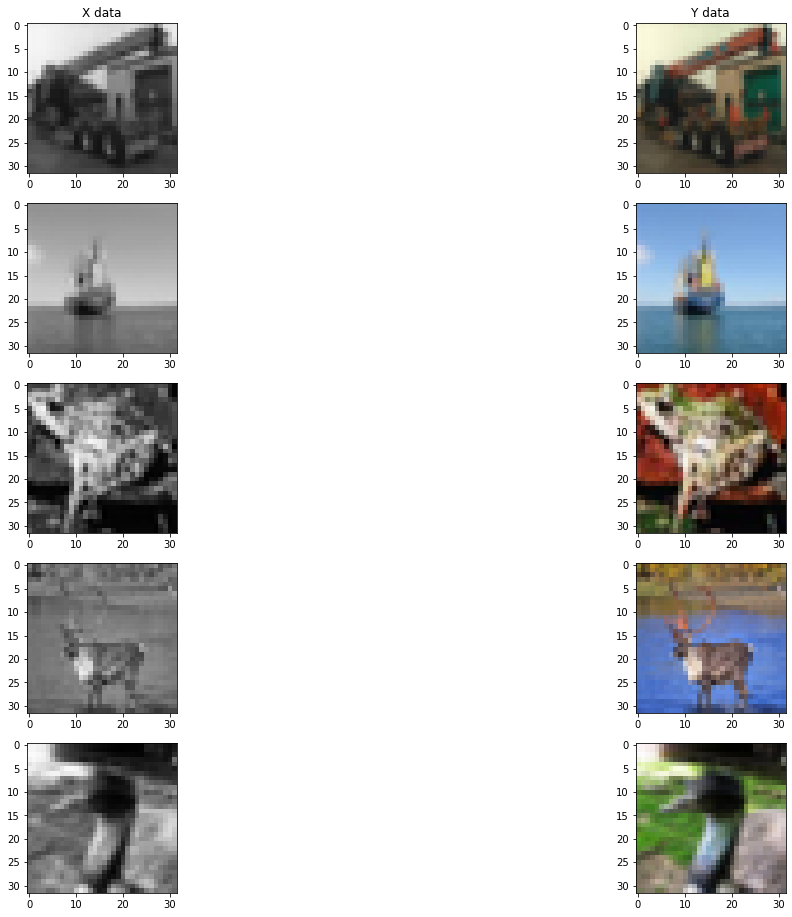

In [3]:
# Set Y data as colored images

data = {}

data["y_train"] = unproccessed_data["X_train"]
data["y_val"] = unproccessed_data["X_val"]
data["y_test"] = unproccessed_data["X_test"]

# Convert X data to B/W

def convertToBW(data):
     # Data shape is (N, 3, W, H)
     
     ret = np.zeros(data.shape)
     grayscale = 0.299 * data[:, 0, :, :] + 0.587 * data[:, 1, :, :] + 0.114 * data[:, 2, :, :]
     
     ret[:, 0, :, :] = grayscale
     ret[:, 1, :, :] = grayscale
     ret[:, 2, :, :] = grayscale
     
     return ret

data["X_train"] = convertToBW(unproccessed_data["X_train"]);
data["X_val"] = convertToBW(unproccessed_data["X_val"]);
data["X_test"] = convertToBW(unproccessed_data["X_test"]);

# Create subplots and choose random examples
fig, axs = plt.subplots(5, 2)
idx = np.random.choice(range(data["X_train"].shape[0]), 5)

# Set axis titles
axs[0, 0].title.set_text('X data')
axs[0, 1].title.set_text('Y data')

for i in range(5):
     axs[i, 0].imshow(data["X_train"][idx[i]].transpose(1, 2, 0))
     axs[i, 1].imshow(data["y_train"][idx[i]].transpose(1, 2, 0))


# Basic Model
Test basic model by using 1 FC layer

In [4]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

def flatten(x):
    N = x.shape[0] 
    return x.view(N, -1) 

using device: cpu


In [18]:
batch_size = 100
print_every = 20

def train(model, optimizer, epochs=1, x_train=data["X_train"], y_train=data["y_train"], criterion=nn.MSELoss()):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
     
    model = model.to(device=device)  # move the model parameters to CPU/GPU\
     
    for e in range(epochs):
        model.epochsTrained += 1
        print("--- Epoch " + str(e + 1) + " / " + str(epochs) + " - " + str(model.epochsTrained) + " epochs total")
        idx = np.random.choice(range(x_train.shape[0]), batch_size)
        x_batch = torch.from_numpy(x_train[idx])
        y_batch = flatten(torch.from_numpy(y_train[idx]))
                    
        for t in range(x_batch.size()[0]):
            model.train()  # put model to training mode
            x = x_batch[t].to(device=device, dtype=dtype) 
            y = y_batch[t].to(device=device, dtype=dtype)
               
            scores = model(x)
            
            loss = criterion(scores.view(-1), y.view(-1))

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))

In [19]:
class BasicNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        
        self.epochsTrained = 0
        self.fc = nn.Linear(input_size, input_size)

    def forward(self, x):
        x = x.view(-1)
        scores = self.fc(x)
          
        return scores

In [21]:
learning_rate = 1e-2
model1 = BasicNet(3 * data["X_train"].shape[2] * data["X_train"].shape[3])
optimizer = optim.SGD(model1.parameters(), lr=learning_rate)

train(model1, optimizer, epochs=25)

--- Epoch 1 / 25 - 1 epochs total
Iteration 0, loss = 0.1488
Iteration 20, loss = 0.2187
Iteration 40, loss = 0.4903
Iteration 60, loss = 0.6881
Iteration 80, loss = 0.1929
--- Epoch 2 / 25 - 2 epochs total
Iteration 0, loss = 0.1037
Iteration 20, loss = 0.0865
Iteration 40, loss = 0.0571
Iteration 60, loss = 0.1310
Iteration 80, loss = 0.1437
--- Epoch 3 / 25 - 3 epochs total
Iteration 0, loss = 0.0813
Iteration 20, loss = 0.2574
Iteration 40, loss = 0.0593
Iteration 60, loss = 0.1005
Iteration 80, loss = 0.0389
--- Epoch 4 / 25 - 4 epochs total
Iteration 0, loss = 0.0145
Iteration 20, loss = 0.1109
Iteration 40, loss = 0.0839
Iteration 60, loss = 0.0890
Iteration 80, loss = 0.1745
--- Epoch 5 / 25 - 5 epochs total
Iteration 0, loss = 0.0308
Iteration 20, loss = 0.0375
Iteration 40, loss = 0.1164
Iteration 60, loss = 0.0505
Iteration 80, loss = 0.0474
--- Epoch 6 / 25 - 6 epochs total
Iteration 0, loss = 0.0188
Iteration 20, loss = 0.0376
Iteration 40, loss = 0.0421
Iteration 60, loss

In [145]:
def testModel(model, n=10, x_test=data["X_test"], y_test=data["y_test"], criterion=nn.MSELoss()):
     model.eval()
     
     # Create subplots and choose random examples
     fig, axs = plt.subplots(n, 3)
     fig.tight_layout()
     fig.set_size_inches(10, 25)
     idx = np.random.choice(range(x_test.shape[0]), n)

     # Set axis titles
     
     for i in range(n):
          sample = x_test[idx[i]]
          x_data = torch.from_numpy(sample).to(device=device, dtype=dtype)
          predicted = model(x_data)
          
          y_data = y_test[idx[i]]
          loss = criterion(predicted.view(3, 32, 32), torch.from_numpy(y_data).to(device=device, dtype=dtype))

          axs[i, 0].title.set_text('X data')
          axs[i, 1].title.set_text('Loss=' + "{:.9f}".format(loss.item()))
          axs[i, 2].title.set_text('Actual')
          
          axs[i, 0].imshow(x_test[idx[i]].transpose(1, 2, 0))
          axs[i, 1].imshow(predicted.view(3, 32, 32).detach().numpy().transpose(1, 2, 0))
          axs[i, 2].imshow(y_data.transpose(1, 2, 0))
          

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


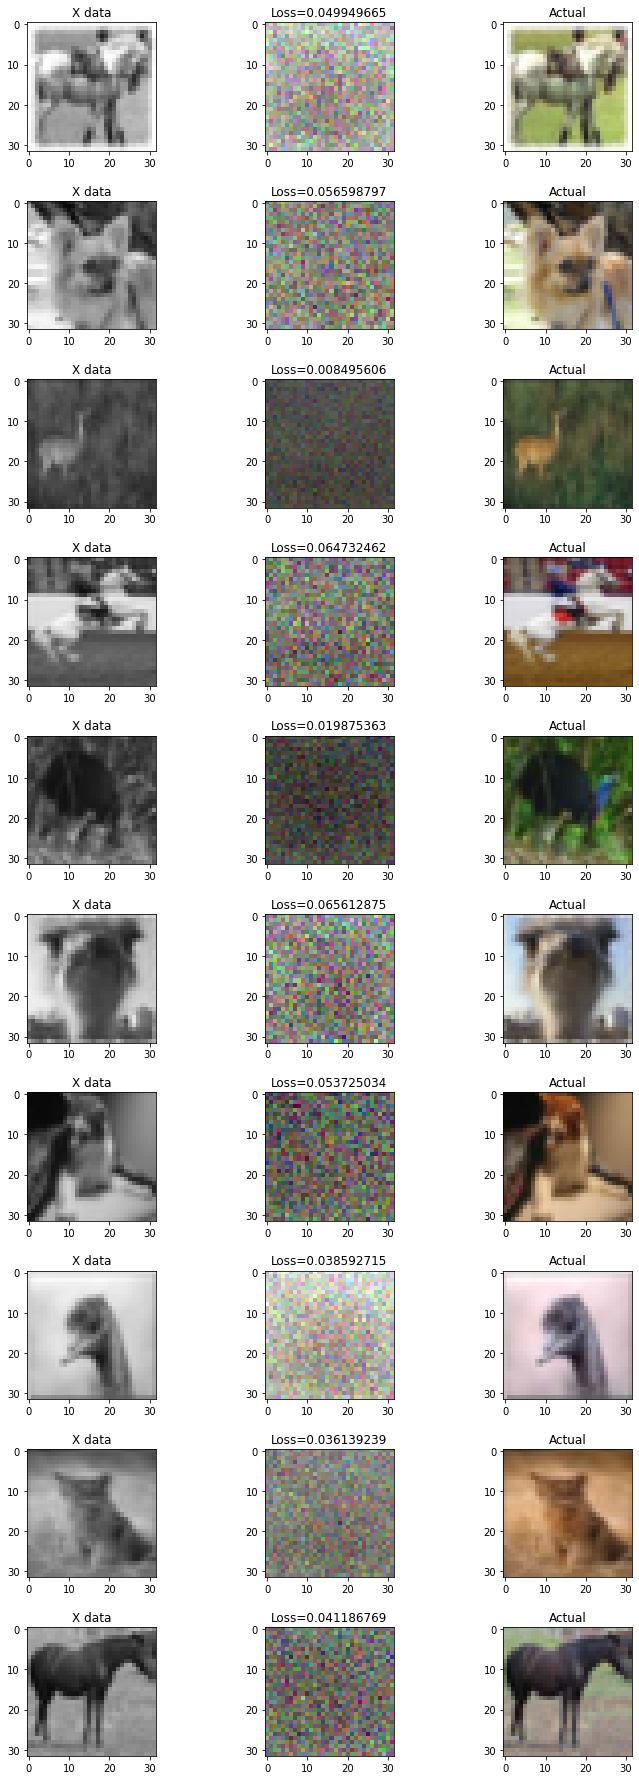

In [170]:
testModel(model1)

In [22]:
class BasicConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.epochsTrained = 0
    
        self.conv1 = nn.Conv2d(3, 24, kernel_size=3, stride=1, padding=0) # 24 3x3 filters
        self.conv2 = nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=0) # 24 3x3 filters
        self.conv3 = nn.Conv2d(24, 12, kernel_size=3, stride=1, padding=0) # 12 3x3 filters
        self.fc = nn.Linear(8112, 32 * 32 * 3)

    def forward(self, x):
        x = x.unsqueeze(0)
        scores = F.relu(self.conv1(x));
        scores = F.relu(self.conv2(scores));
        scores = F.relu(self.conv3(scores));
        scores = self.fc(scores.view(-1))
          
        return scores

In [172]:
learning_rate = 1e-2
model2 = BasicConvNet()
optimizer = optim.SGD(model2.parameters(), lr=learning_rate)

train(model2, optimizer, epochs=25, criterion=nn.MSELoss())

--- Epoch 1 / 25 - 1 epochs total
Iteration 0, loss = 0.3250
Iteration 20, loss = 0.1401
Iteration 40, loss = 0.2926
Iteration 60, loss = 0.3218
Iteration 80, loss = 0.2827
--- Epoch 2 / 25 - 2 epochs total
Iteration 0, loss = 0.3426
Iteration 20, loss = 0.1222
Iteration 40, loss = 0.5539
Iteration 60, loss = 0.1707
Iteration 80, loss = 0.3535
--- Epoch 3 / 25 - 3 epochs total
Iteration 0, loss = 0.2681
Iteration 20, loss = 0.2246
Iteration 40, loss = 0.3098
Iteration 60, loss = 0.1848
Iteration 80, loss = 0.3872
--- Epoch 4 / 25 - 4 epochs total
Iteration 0, loss = 0.0420
Iteration 20, loss = 0.2622
Iteration 40, loss = 0.1603
Iteration 60, loss = 0.0840
Iteration 80, loss = 0.1690
--- Epoch 5 / 25 - 5 epochs total
Iteration 0, loss = 0.0431
Iteration 20, loss = 0.1285
Iteration 40, loss = 0.0655
Iteration 60, loss = 0.0661
Iteration 80, loss = 0.0665
--- Epoch 6 / 25 - 6 epochs total
Iteration 0, loss = 0.0418
Iteration 20, loss = 0.0540
Iteration 40, loss = 0.1009
Iteration 60, loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


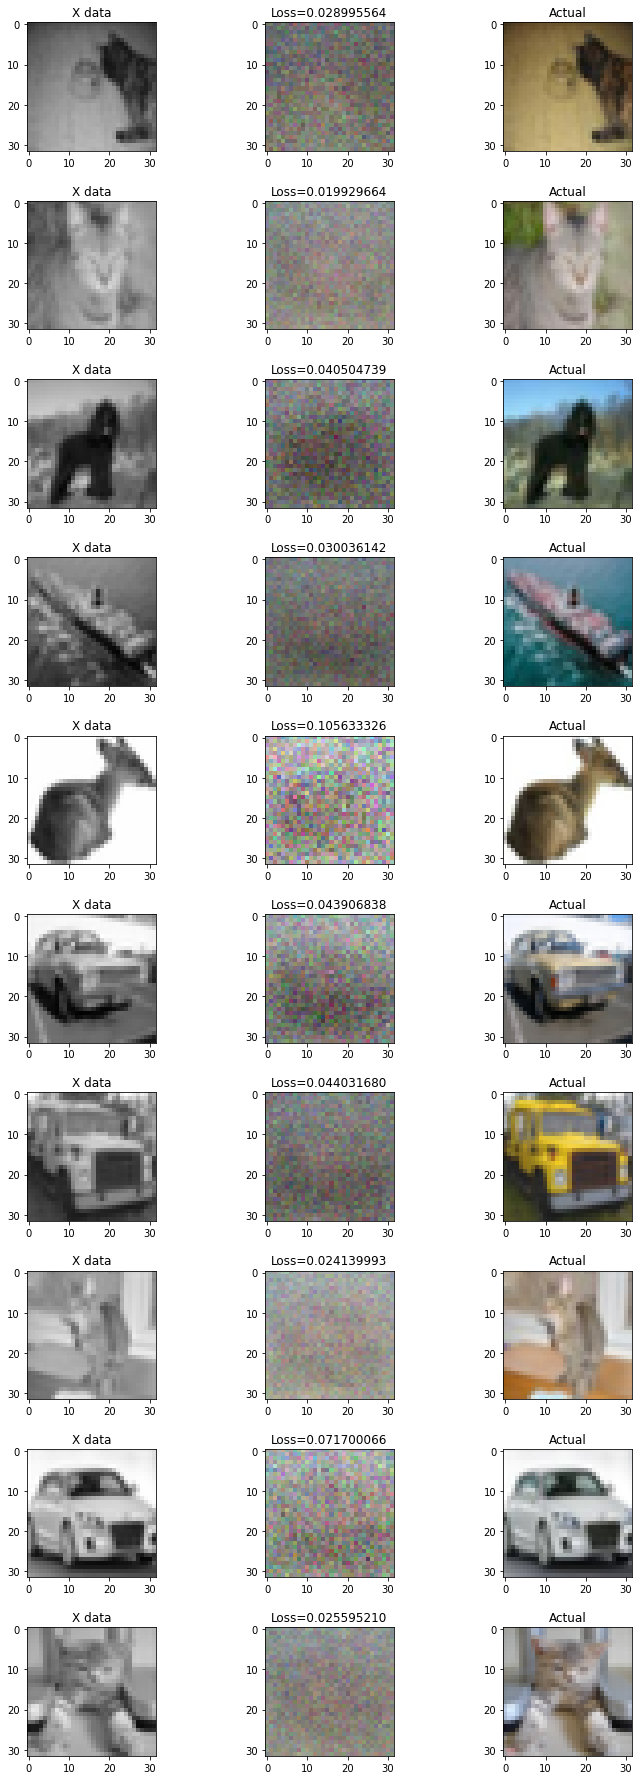

In [173]:
testModel(model2)

In [150]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.epochsTrained = 0
          
        self.batchnorm48 = nn.BatchNorm2d(24)
        self.batchnorm24 = nn.BatchNorm2d(12)
    
        self.conv1 = nn.Conv2d(3, 24, kernel_size=5, stride=1, padding=0) # 48 3x3 filters
        self.conv2 = nn.Conv2d(24, 24, kernel_size=4, stride=1, padding=0) # 48 3x3 filters
        self.conv3 = nn.Conv2d(24, 12, kernel_size=3, stride=1, padding=0) # 24 3x3 filters
        self.fc = nn.Linear(9420, 32 * 32 * 3)

    def forward(self, x):
        x2 = x.unsqueeze(0)
        scores = self.batchnorm48(F.relu(self.conv1(x2)));
        scores = self.batchnorm48(F.relu(self.conv2(scores)));
        scores = self.batchnorm24(F.relu(self.conv3(scores)));
     
        with_x = torch.cat((scores.view(-1), x.view(-1)), 0)
        scores = self.fc(with_x)
          
        return scores

In [152]:
learning_rate = 1e-2
model3 = ConvNet()
optimizer = optim.SGD(model3.parameters(), lr=learning_rate)

train(model3, optimizer, epochs=50)

--- Epoch 1 / 50 - 1 epochs total
Iteration 0, loss = 0.4640
Iteration 20, loss = 0.6072
Iteration 40, loss = 0.3148
Iteration 60, loss = 0.4069
Iteration 80, loss = 0.4691
--- Epoch 2 / 50 - 2 epochs total
Iteration 0, loss = 0.3967
Iteration 20, loss = 0.2838
Iteration 40, loss = 0.3281
Iteration 60, loss = 0.2043
Iteration 80, loss = 0.2292
--- Epoch 3 / 50 - 3 epochs total
Iteration 0, loss = 0.1746
Iteration 20, loss = 0.2492
Iteration 40, loss = 0.3015
Iteration 60, loss = 0.2115
Iteration 80, loss = 0.1473
--- Epoch 4 / 50 - 4 epochs total
Iteration 0, loss = 0.2002
Iteration 20, loss = 0.1324
Iteration 40, loss = 0.1655
Iteration 60, loss = 0.1047
Iteration 80, loss = 0.1279
--- Epoch 5 / 50 - 5 epochs total
Iteration 0, loss = 0.0658
Iteration 20, loss = 0.1138
Iteration 40, loss = 0.0834
Iteration 60, loss = 0.0691
Iteration 80, loss = 0.1292
--- Epoch 6 / 50 - 6 epochs total
Iteration 0, loss = 0.0616
Iteration 20, loss = 0.0694
Iteration 40, loss = 0.0584
Iteration 60, loss

--- Epoch 48 / 50 - 48 epochs total
Iteration 0, loss = 0.0172
Iteration 20, loss = 0.0176
Iteration 40, loss = 0.0553
Iteration 60, loss = 0.0299
Iteration 80, loss = 0.0244
--- Epoch 49 / 50 - 49 epochs total
Iteration 0, loss = 0.0242
Iteration 20, loss = 0.0572
Iteration 40, loss = 0.0327
Iteration 60, loss = 0.0355
Iteration 80, loss = 0.0435
--- Epoch 50 / 50 - 50 epochs total
Iteration 0, loss = 0.0332
Iteration 20, loss = 0.0262
Iteration 40, loss = 0.0292
Iteration 60, loss = 0.0533
Iteration 80, loss = 0.0221


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

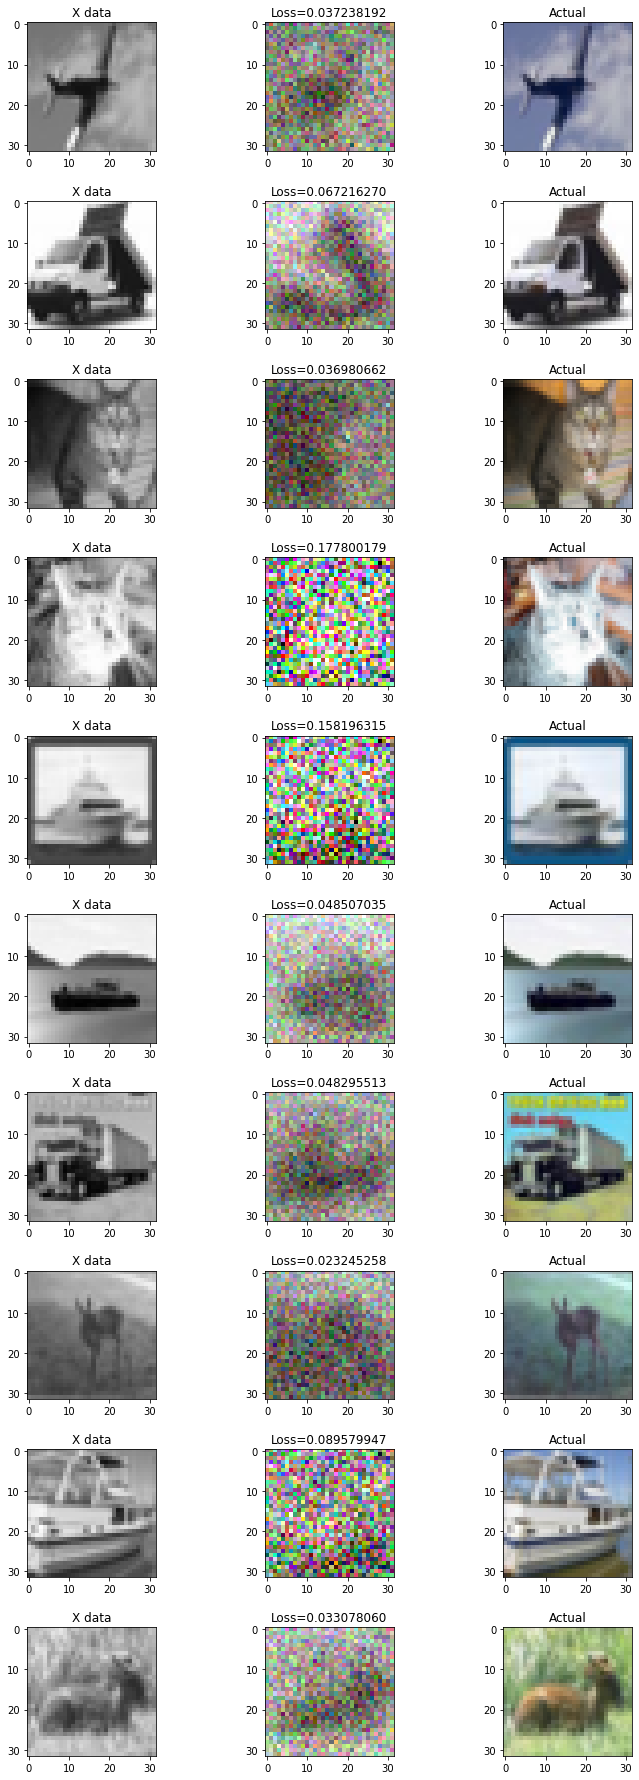

In [153]:
testModel(model3)

In [62]:
def detectEdges(image):
     ret = torch.zeros(image.shape)
     
     filter = torch.tensor([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]).to(device=device, dtype=dtype).view(1, 1, 3, 3)
     grayscale = image[0, :, :].view(1, 1, 32, 32)
     
     edges = F.conv2d(grayscale, filter, padding=1)
     edges = edges[0][0]
#      edges = ndimage.convolve(grayscale, filter, mode='constant', cval=0.0)
     
     ret[0, :, :] = edges
     ret[1, :, :] = edges
     ret[2, :, :] = edges
    
     ret[ret < 0.15] = 0
     ret[ret > 0.15] = 1
     return ret

Test edge detection

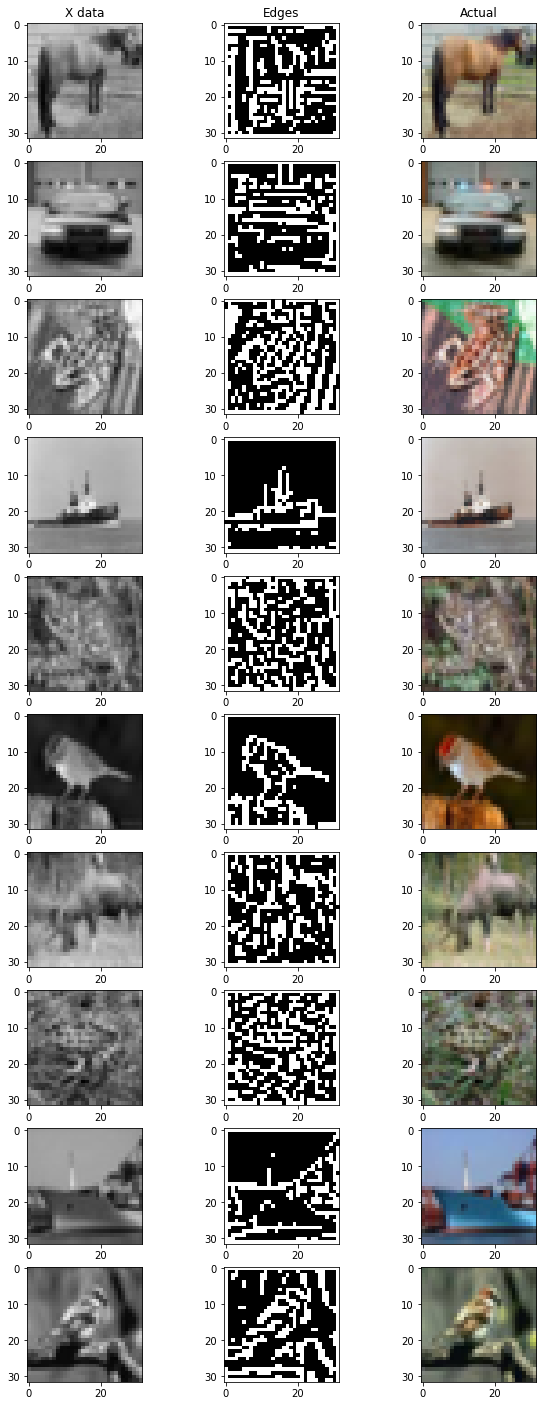

In [63]:
n = 10
idx = np.random.choice(range(data["X_test"].shape[0]), n)

fig, axs = plt.subplots(n, 3)
fig.set_size_inches(10, 25)

# Set axis titles
axs[0, 0].title.set_text('X data')
axs[0, 1].title.set_text('Edges')
axs[0, 2].title.set_text('Actual')

for i in range(n):
     x_data = data["X_test"][idx[i]]
     y_data = data["y_test"][idx[i]]

     axs[i, 0].imshow(x_data.transpose(1, 2, 0))
     axs[i, 1].imshow(detectEdges(torch.from_numpy(y_data).to(device=device, dtype=dtype)).detach().numpy().transpose(1, 2, 0))
     axs[i, 2].imshow(y_data.transpose(1, 2, 0))


Build custom loss functions using adjacent difference to smoothen results and edge detection to keep image structure (Edge detection loss didnt work well in any of my tests so it is not widely used later on)

In [337]:
def custom_loss(output, target):
     output = output.view(3, 32, 32)
     target = target.view(3, 32, 32)
     
     # Overall mean squared error
     color_loss = torch.mean((output - target) ** 2)
     
     # Take difference between adjacent pixels into account to smoothen results
     horizontal_loss = torch.mean((output[:, 1:] - output[:, :-1]) ** 2)
     vertical_loss = torch.mean((output[1:, :] - output[:-1, :]) ** 2)

     loss = color_loss * 0.8 + horizontal_loss * 0.1 + vertical_loss * 0.11
    
     return loss

In [225]:
def custom_loss_edges(output, target):
     output = output.view(3, 32, 32)
     target = target.view(3, 32, 32)
     
     output_edges = detectEdges(output)
     target_edges = detectEdges(target)
     
     edge_loss = torch.mean((output_edges - target_edges) ** 2)
     
     color_loss = torch.mean((output - target) ** 2)
     horizontal_loss = torch.mean((output[:, 1:] - output[:, :-1]) ** 2)
     vertical_loss = torch.mean((output[1:, :] - output[:-1, :]) ** 2)
     
     loss = color_loss * 0.6 + horizontal_loss * 0.1 + vertical_loss * 0.1 + edge_loss * 0.2

     return loss

In [ ]:
learning_rate = 1e-2
model4 = ConvNet()
optimizer = optim.SGD(model4.parameters(), lr=learning_rate)

In [452]:
train(model4, optimizer, epochs=300, criterion=custom_loss)

--- Epoch 1 / 300
Iteration 0, loss = 0.0092
Iteration 20, loss = 0.0071
Iteration 40, loss = 0.0094
Iteration 60, loss = 0.0125
Iteration 80, loss = 0.0049
--- Epoch 2 / 300
Iteration 0, loss = 0.0107
Iteration 20, loss = 0.0072
Iteration 40, loss = 0.0085
Iteration 60, loss = 0.0063
Iteration 80, loss = 0.0119
--- Epoch 3 / 300
Iteration 0, loss = 0.0120
Iteration 20, loss = 0.0098
Iteration 40, loss = 0.0176
Iteration 60, loss = 0.0105
Iteration 80, loss = 0.0149
--- Epoch 4 / 300
Iteration 0, loss = 0.0054
Iteration 20, loss = 0.0100
Iteration 40, loss = 0.0185
Iteration 60, loss = 0.0155
Iteration 80, loss = 0.0162
--- Epoch 5 / 300
Iteration 0, loss = 0.0103
Iteration 20, loss = 0.0117
Iteration 40, loss = 0.0125
Iteration 60, loss = 0.0195
Iteration 80, loss = 0.0104
--- Epoch 6 / 300
Iteration 0, loss = 0.0161
Iteration 20, loss = 0.0251
Iteration 40, loss = 0.0237
Iteration 60, loss = 0.0107
Iteration 80, loss = 0.0178
--- Epoch 7 / 300
Iteration 0, loss = 0.0089
Iteration 20,

--- Epoch 53 / 300
Iteration 0, loss = 0.0064
Iteration 20, loss = 0.0259
Iteration 40, loss = 0.0297
Iteration 60, loss = 0.0106
Iteration 80, loss = 0.0121
--- Epoch 54 / 300
Iteration 0, loss = 0.0173
Iteration 20, loss = 0.0101
Iteration 40, loss = 0.0150
Iteration 60, loss = 0.0087
Iteration 80, loss = 0.0102
--- Epoch 55 / 300
Iteration 0, loss = 0.0096
Iteration 20, loss = 0.0079
Iteration 40, loss = 0.0097
Iteration 60, loss = 0.0074
Iteration 80, loss = 0.0293
--- Epoch 56 / 300
Iteration 0, loss = 0.0089
Iteration 20, loss = 0.0106
Iteration 40, loss = 0.0055
Iteration 60, loss = 0.0038
Iteration 80, loss = 0.0176
--- Epoch 57 / 300
Iteration 0, loss = 0.0089
Iteration 20, loss = 0.0134
Iteration 40, loss = 0.0059
Iteration 60, loss = 0.0188
Iteration 80, loss = 0.0059
--- Epoch 58 / 300
Iteration 0, loss = 0.0087
Iteration 20, loss = 0.0098
Iteration 40, loss = 0.0035
Iteration 60, loss = 0.0145
Iteration 80, loss = 0.0094
--- Epoch 59 / 300
Iteration 0, loss = 0.0132
Iterat

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


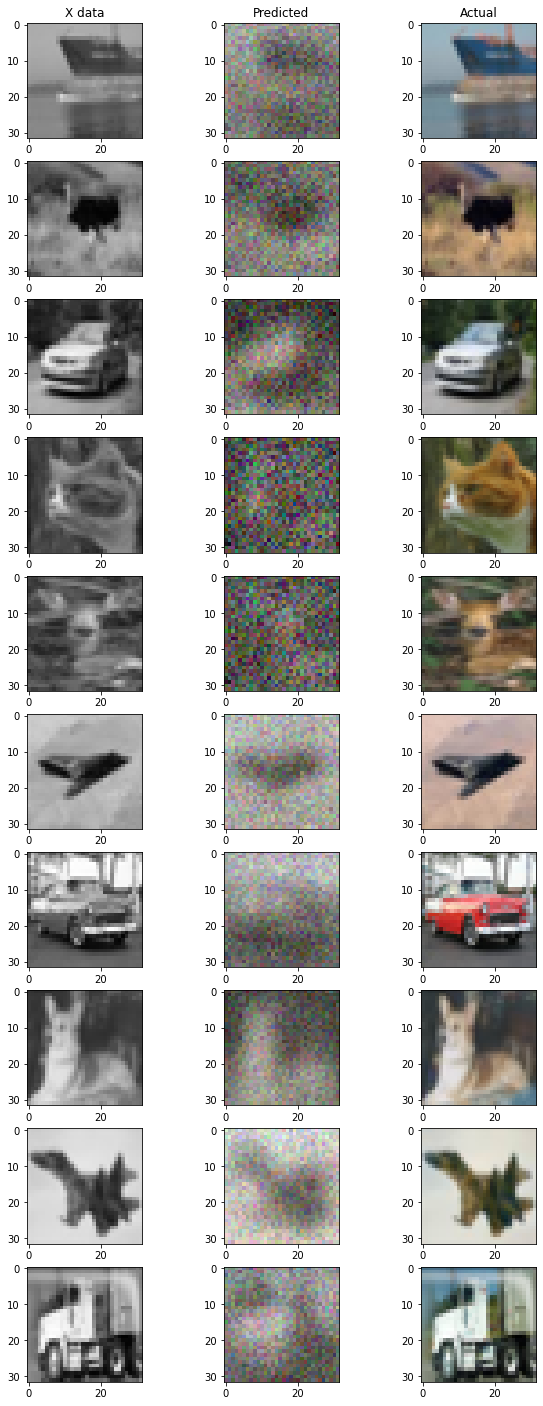

In [453]:
testModel(model4)

In [66]:
learning_rate = 1e-2
model5 = ConvNet()
optimizer = optim.SGD(model5.parameters(), lr=learning_rate)

In [72]:
train(model5, optimizer, epochs=300, criterion=custom_loss_edges)

--- Epoch 1 / 300
Iteration 0, loss = 0.1264
Iteration 20, loss = 0.0959
Iteration 40, loss = 0.0950
Iteration 60, loss = 0.1142
Iteration 80, loss = 0.1146
--- Epoch 2 / 300
Iteration 0, loss = 0.1114
Iteration 20, loss = 0.0938
Iteration 40, loss = 0.0967
Iteration 60, loss = 0.1293
Iteration 80, loss = 0.1029
--- Epoch 3 / 300
Iteration 0, loss = 0.1161
Iteration 20, loss = 0.1257
Iteration 40, loss = 0.1162
Iteration 60, loss = 0.1176
Iteration 80, loss = 0.0968
--- Epoch 4 / 300
Iteration 0, loss = 0.0887
Iteration 20, loss = 0.1108
Iteration 40, loss = 0.0977
Iteration 60, loss = 0.1076
Iteration 80, loss = 0.0902
--- Epoch 5 / 300
Iteration 0, loss = 0.1177
Iteration 20, loss = 0.0982
Iteration 40, loss = 0.0957
Iteration 60, loss = 0.1109
Iteration 80, loss = 0.1038
--- Epoch 6 / 300
Iteration 0, loss = 0.0996
Iteration 20, loss = 0.0890
Iteration 40, loss = 0.1083
Iteration 60, loss = 0.1139
Iteration 80, loss = 0.1148
--- Epoch 7 / 300
Iteration 0, loss = 0.1036
Iteration 20,

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


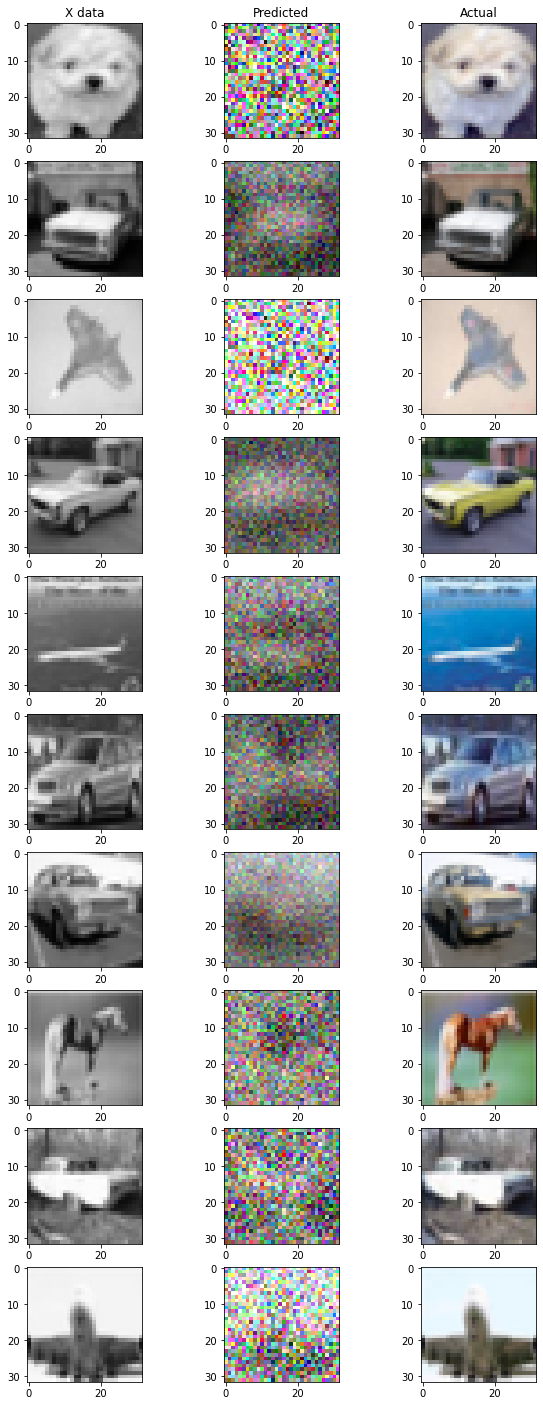

In [73]:
testModel(model5)

In [189]:
class ConvNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.epochsTrained = 0
          
        self.batchnorm1 = nn.BatchNorm2d(24)
        self.batchnorm2 = nn.BatchNorm2d(24)
        self.batchnorm3 = nn.BatchNorm2d(12)
        self.batchnorm4 = nn.BatchNorm2d(12)
    
        self.conv1 = nn.Conv2d(3, 24, kernel_size=6, stride=1, padding=2) # 48 6x6 filters
        self.conv2 = nn.Conv2d(24, 24, kernel_size=4, stride=1, padding=1) # 48 4x4 filters
        self.conv3 = nn.Conv2d(24, 12, kernel_size=4, stride=1, padding=1) # 24 4x4 filters
        self.conv4 = nn.Conv2d(12, 12, kernel_size=3, stride=1, padding=1) # 24 3x3 filters
        self.fc = nn.Linear(13164, 32 * 32 * 3)

    def forward(self, x):
        x2 = x.unsqueeze(0)
        scores = self.batchnorm1(F.relu(self.conv1(x2)));
        scores = self.batchnorm2(F.relu(self.conv2(scores)));
        scores = self.batchnorm3(F.relu(self.conv3(scores)));
        scores = self.batchnorm4(torch.tanh(self.conv4(scores)));
               
        with_x = torch.cat((scores.view(-1), x.view(-1)), 0)
        scores = self.fc(with_x)
          
        return scores

In [125]:
learning_rate = 1e-2
model6 = ConvNet2()
optimizer = optim.SGD(model6.parameters(), lr=learning_rate)

In [128]:
train(model6, optimizer, epochs=250, criterion=custom_loss)

--- Epoch 1 / 250
Iteration 0, loss = 0.1323
Iteration 20, loss = 0.1473
Iteration 40, loss = 0.1414
Iteration 60, loss = 0.1272
Iteration 80, loss = 0.1903
--- Epoch 2 / 250
Iteration 0, loss = 0.0930
Iteration 20, loss = 0.0972
Iteration 40, loss = 0.1379
Iteration 60, loss = 0.0825
Iteration 80, loss = 0.1351
--- Epoch 3 / 250
Iteration 0, loss = 0.1339
Iteration 20, loss = 0.1859
Iteration 40, loss = 0.1257
Iteration 60, loss = 0.1184
Iteration 80, loss = 0.0991
--- Epoch 4 / 250
Iteration 0, loss = 0.1137
Iteration 20, loss = 0.0941
Iteration 40, loss = 0.1762
Iteration 60, loss = 0.1596
Iteration 80, loss = 0.1572
--- Epoch 5 / 250
Iteration 0, loss = 0.1331
Iteration 20, loss = 0.1142
Iteration 40, loss = 0.1244
Iteration 60, loss = 0.1387
Iteration 80, loss = 0.1038
--- Epoch 6 / 250
Iteration 0, loss = 0.0847
Iteration 20, loss = 0.1252
Iteration 40, loss = 0.1097
Iteration 60, loss = 0.1029
Iteration 80, loss = 0.1377
--- Epoch 7 / 250
Iteration 0, loss = 0.1077
Iteration 20,

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


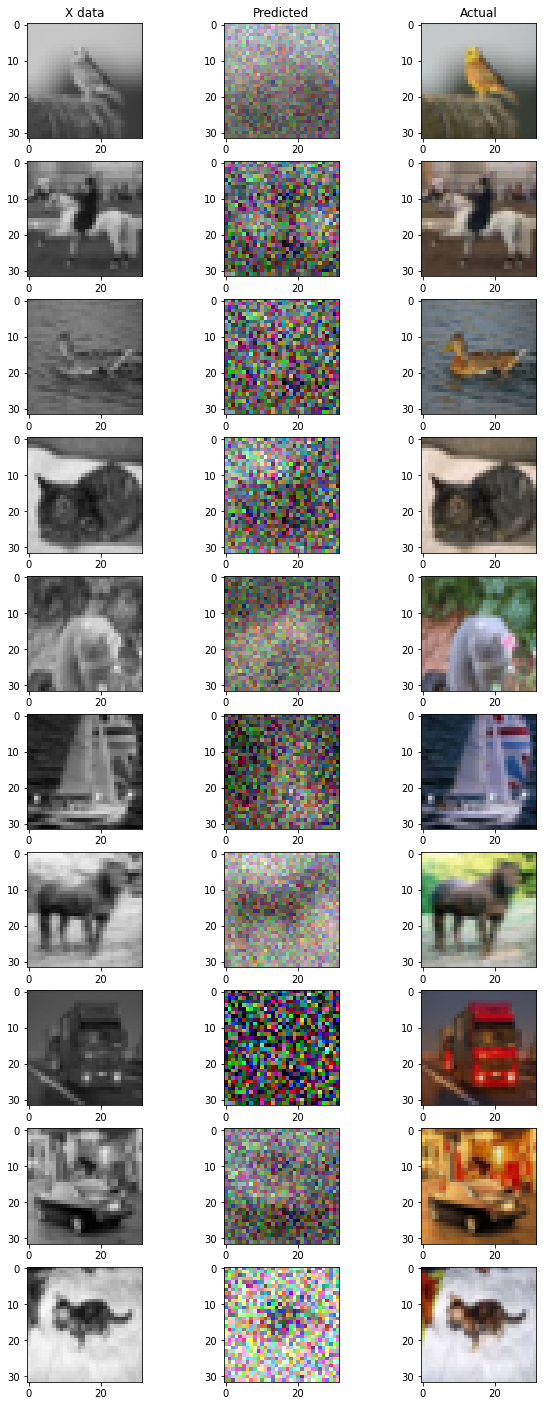

In [129]:
testModel(model5)

Try training on a specific class type to make it easier for netowrk

In [6]:
classes = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

for c in range(len(classes)):
     cname = classes[c]
     train_idx = np.where(unproccessed_data["y_train"] == c)
     test_idx = np.where(unproccessed_data["y_test"] == c)
     val_idx = np.where(unproccessed_data["y_val"] == c)

     data["y_train_" + cname] = unproccessed_data["X_train"][train_idx]
     data["y_val_" + cname] = unproccessed_data["X_val"][val_idx]
     data["y_test_" + cname] = unproccessed_data["X_test"][test_idx]

     data["X_train_" + cname] = convertToBW(unproccessed_data["X_train"][train_idx]);
     data["X_val_" + cname] = convertToBW(unproccessed_data["X_val"][val_idx]);
     data["X_test_" + cname] = convertToBW(unproccessed_data["X_test"][test_idx]);

dict_keys(['y_train', 'y_val', 'y_test', 'X_train', 'X_val', 'X_test', 'y_train_airplane', 'y_val_airplane', 'y_test_airplane', 'X_train_airplane', 'X_val_airplane', 'X_test_airplane', 'y_train_automobile', 'y_val_automobile', 'y_test_automobile', 'X_train_automobile', 'X_val_automobile', 'X_test_automobile', 'y_train_bird', 'y_val_bird', 'y_test_bird', 'X_train_bird', 'X_val_bird', 'X_test_bird', 'y_train_cat', 'y_val_cat', 'y_test_cat', 'X_train_cat', 'X_val_cat', 'X_test_cat', 'y_train_deer', 'y_val_deer', 'y_test_deer', 'X_train_deer', 'X_val_deer', 'X_test_deer', 'y_train_dog', 'y_val_dog', 'y_test_dog', 'X_train_dog', 'X_val_dog', 'X_test_dog', 'y_train_frog', 'y_val_frog', 'y_test_frog', 'X_train_frog', 'X_val_frog', 'X_test_frog', 'y_train_horse', 'y_val_horse', 'y_test_horse', 'X_train_horse', 'X_val_horse', 'X_test_horse', 'y_train_ship', 'y_val_ship', 'y_test_ship', 'X_train_ship', 'X_val_ship', 'X_test_ship', 'y_train_truck', 'y_val_truck', 'y_test_truck', 'X_train_truck', 

In [214]:
learning_rate = 5e-3
model7 = ConvNet2()
optimizer = optim.SGD(model7.parameters(), lr=learning_rate)

In [215]:
train(model7, optimizer, epochs=1000, x_train=data["X_train_class"],  y_train=data["y_train_class"], criterion=custom_loss)

--- Epoch 1 / 1000
Iteration 0, loss = 0.5163
Iteration 20, loss = 0.4907
Iteration 40, loss = 0.3813
Iteration 60, loss = 0.2225
Iteration 80, loss = 0.2141
--- Epoch 2 / 1000
Iteration 0, loss = 0.1437
Iteration 20, loss = 0.1209
Iteration 40, loss = 0.1181
Iteration 60, loss = 0.1140
Iteration 80, loss = 0.1295
--- Epoch 3 / 1000
Iteration 0, loss = 0.1044
Iteration 20, loss = 0.0945
Iteration 40, loss = 0.0883
Iteration 60, loss = 0.0771
Iteration 80, loss = 0.1358
--- Epoch 4 / 1000
Iteration 0, loss = 0.0540
Iteration 20, loss = 0.0467
Iteration 40, loss = 0.0336
Iteration 60, loss = 0.0385
Iteration 80, loss = 0.0180
--- Epoch 5 / 1000
Iteration 0, loss = 0.0517
Iteration 20, loss = 0.0614
Iteration 40, loss = 0.0143
Iteration 60, loss = 0.0386
Iteration 80, loss = 0.2632
--- Epoch 6 / 1000
Iteration 0, loss = 0.0245
Iteration 20, loss = 0.0095
Iteration 40, loss = 0.1029
Iteration 60, loss = 0.0547
Iteration 80, loss = 0.0560
--- Epoch 7 / 1000
Iteration 0, loss = 0.0149
Iterat

Iteration 60, loss = 0.0072
Iteration 80, loss = 0.0352
--- Epoch 53 / 1000
Iteration 0, loss = 0.0365
Iteration 20, loss = 0.0185
Iteration 40, loss = 0.0211
Iteration 60, loss = 0.0462
Iteration 80, loss = 0.0185
--- Epoch 54 / 1000
Iteration 0, loss = 0.0172
Iteration 20, loss = 0.0149
Iteration 40, loss = 0.0452
Iteration 60, loss = 0.0118
Iteration 80, loss = 0.0195
--- Epoch 55 / 1000
Iteration 0, loss = 0.0202
Iteration 20, loss = 0.0232
Iteration 40, loss = 0.0166
Iteration 60, loss = 0.0251
Iteration 80, loss = 0.0262
--- Epoch 56 / 1000
Iteration 0, loss = 0.0095
Iteration 20, loss = 0.0177
Iteration 40, loss = 0.0215
Iteration 60, loss = 0.0106
Iteration 80, loss = 0.0312
--- Epoch 57 / 1000
Iteration 0, loss = 0.0200
Iteration 20, loss = 0.0347
Iteration 40, loss = 0.0095
Iteration 60, loss = 0.0166
Iteration 80, loss = 0.0248
--- Epoch 58 / 1000
Iteration 0, loss = 0.0280
Iteration 20, loss = 0.0231
Iteration 40, loss = 0.0176
Iteration 60, loss = 0.0302
Iteration 80, loss

Iteration 20, loss = 0.0187
Iteration 40, loss = 0.0205
Iteration 60, loss = 0.0180
Iteration 80, loss = 0.0181
--- Epoch 105 / 1000
Iteration 0, loss = 0.0194
Iteration 20, loss = 0.0241
Iteration 40, loss = 0.0272
Iteration 60, loss = 0.0337
Iteration 80, loss = 0.0334
--- Epoch 106 / 1000
Iteration 0, loss = 0.0300
Iteration 20, loss = 0.0127
Iteration 40, loss = 0.0125
Iteration 60, loss = 0.0095
Iteration 80, loss = 0.0927
--- Epoch 107 / 1000
Iteration 0, loss = 0.0250
Iteration 20, loss = 0.0132
Iteration 40, loss = 0.0149
Iteration 60, loss = 0.0352
Iteration 80, loss = 0.0198
--- Epoch 108 / 1000
Iteration 0, loss = 0.0142
Iteration 20, loss = 0.0213
Iteration 40, loss = 0.0570
Iteration 60, loss = 0.0148
Iteration 80, loss = 0.0147
--- Epoch 109 / 1000
Iteration 0, loss = 0.0063
Iteration 20, loss = 0.0108
Iteration 40, loss = 0.0142
Iteration 60, loss = 0.0420
Iteration 80, loss = 0.0142
--- Epoch 110 / 1000
Iteration 0, loss = 0.0169
Iteration 20, loss = 0.0265
Iteration 40

Iteration 60, loss = 0.0237
Iteration 80, loss = 0.0104
--- Epoch 156 / 1000
Iteration 0, loss = 0.0142
Iteration 20, loss = 0.0370
Iteration 40, loss = 0.0170
Iteration 60, loss = 0.0217
Iteration 80, loss = 0.0153
--- Epoch 157 / 1000
Iteration 0, loss = 0.0184
Iteration 20, loss = 0.0155
Iteration 40, loss = 0.0086
Iteration 60, loss = 0.0199
Iteration 80, loss = 0.0119
--- Epoch 158 / 1000
Iteration 0, loss = 0.0114
Iteration 20, loss = 0.0164
Iteration 40, loss = 0.0101
Iteration 60, loss = 0.0160
Iteration 80, loss = 0.0396
--- Epoch 159 / 1000
Iteration 0, loss = 0.0092
Iteration 20, loss = 0.0062
Iteration 40, loss = 0.0238
Iteration 60, loss = 0.0293
Iteration 80, loss = 0.0063
--- Epoch 160 / 1000
Iteration 0, loss = 0.0252
Iteration 20, loss = 0.0167
Iteration 40, loss = 0.0104
Iteration 60, loss = 0.0087
Iteration 80, loss = 0.0262
--- Epoch 161 / 1000
Iteration 0, loss = 0.0194
Iteration 20, loss = 0.0164
Iteration 40, loss = 0.0148
Iteration 60, loss = 0.0281
Iteration 80

--- Epoch 207 / 1000
Iteration 0, loss = 0.0238
Iteration 20, loss = 0.0155
Iteration 40, loss = 0.0245
Iteration 60, loss = 0.0267
Iteration 80, loss = 0.0070
--- Epoch 208 / 1000
Iteration 0, loss = 0.0077
Iteration 20, loss = 0.0057
Iteration 40, loss = 0.0126
Iteration 60, loss = 0.0175
Iteration 80, loss = 0.0144
--- Epoch 209 / 1000
Iteration 0, loss = 0.0298
Iteration 20, loss = 0.0078
Iteration 40, loss = 0.0256
Iteration 60, loss = 0.0217
Iteration 80, loss = 0.0206
--- Epoch 210 / 1000
Iteration 0, loss = 0.0072
Iteration 20, loss = 0.0136
Iteration 40, loss = 0.0147
Iteration 60, loss = 0.0080
Iteration 80, loss = 0.0139
--- Epoch 211 / 1000
Iteration 0, loss = 0.0111
Iteration 20, loss = 0.0232
Iteration 40, loss = 0.0185
Iteration 60, loss = 0.0180
Iteration 80, loss = 0.0102
--- Epoch 212 / 1000
Iteration 0, loss = 0.0171
Iteration 20, loss = 0.0048
Iteration 40, loss = 0.0264
Iteration 60, loss = 0.0139
Iteration 80, loss = 0.0261
--- Epoch 213 / 1000
Iteration 0, loss =

Iteration 20, loss = 0.0116
Iteration 40, loss = 0.0137
Iteration 60, loss = 0.0120
Iteration 80, loss = 0.0153
--- Epoch 259 / 1000
Iteration 0, loss = 0.0135
Iteration 20, loss = 0.0253
Iteration 40, loss = 0.0175
Iteration 60, loss = 0.0205
Iteration 80, loss = 0.0199
--- Epoch 260 / 1000
Iteration 0, loss = 0.0098
Iteration 20, loss = 0.0286
Iteration 40, loss = 0.0129
Iteration 60, loss = 0.0216
Iteration 80, loss = 0.0232
--- Epoch 261 / 1000
Iteration 0, loss = 0.0125
Iteration 20, loss = 0.0155
Iteration 40, loss = 0.0080
Iteration 60, loss = 0.0039
Iteration 80, loss = 0.0131
--- Epoch 262 / 1000
Iteration 0, loss = 0.0050
Iteration 20, loss = 0.0181
Iteration 40, loss = 0.0133
Iteration 60, loss = 0.0109
Iteration 80, loss = 0.0137
--- Epoch 263 / 1000
Iteration 0, loss = 0.0203
Iteration 20, loss = 0.0042
Iteration 40, loss = 0.0337
Iteration 60, loss = 0.0099
Iteration 80, loss = 0.0056
--- Epoch 264 / 1000
Iteration 0, loss = 0.0312
Iteration 20, loss = 0.0090
Iteration 40

Iteration 60, loss = 0.0100
Iteration 80, loss = 0.0047
--- Epoch 310 / 1000
Iteration 0, loss = 0.0117
Iteration 20, loss = 0.0135
Iteration 40, loss = 0.0144
Iteration 60, loss = 0.0087
Iteration 80, loss = 0.0205
--- Epoch 311 / 1000
Iteration 0, loss = 0.0071
Iteration 20, loss = 0.0058
Iteration 40, loss = 0.0137
Iteration 60, loss = 0.0172
Iteration 80, loss = 0.0197
--- Epoch 312 / 1000
Iteration 0, loss = 0.0092
Iteration 20, loss = 0.0017
Iteration 40, loss = 0.0057
Iteration 60, loss = 0.0113
Iteration 80, loss = 0.0130
--- Epoch 313 / 1000
Iteration 0, loss = 0.0190
Iteration 20, loss = 0.0161
Iteration 40, loss = 0.0208
Iteration 60, loss = 0.0214
Iteration 80, loss = 0.0053
--- Epoch 314 / 1000
Iteration 0, loss = 0.0145
Iteration 20, loss = 0.0106
Iteration 40, loss = 0.0161
Iteration 60, loss = 0.0202
Iteration 80, loss = 0.0238
--- Epoch 315 / 1000
Iteration 0, loss = 0.0204
Iteration 20, loss = 0.0139
Iteration 40, loss = 0.0303
Iteration 60, loss = 0.0055
Iteration 80

--- Epoch 361 / 1000
Iteration 0, loss = 0.0078
Iteration 20, loss = 0.0090
Iteration 40, loss = 0.0332
Iteration 60, loss = 0.0302
Iteration 80, loss = 0.0122
--- Epoch 362 / 1000
Iteration 0, loss = 0.0156
Iteration 20, loss = 0.0143
Iteration 40, loss = 0.0109
Iteration 60, loss = 0.0219
Iteration 80, loss = 0.0073
--- Epoch 363 / 1000
Iteration 0, loss = 0.0153
Iteration 20, loss = 0.0123
Iteration 40, loss = 0.0296
Iteration 60, loss = 0.0104
Iteration 80, loss = 0.0233
--- Epoch 364 / 1000
Iteration 0, loss = 0.0101
Iteration 20, loss = 0.0125
Iteration 40, loss = 0.0040
Iteration 60, loss = 0.0144
Iteration 80, loss = 0.0089
--- Epoch 365 / 1000
Iteration 0, loss = 0.0114
Iteration 20, loss = 0.0070
Iteration 40, loss = 0.0116
Iteration 60, loss = 0.0247
Iteration 80, loss = 0.0143
--- Epoch 366 / 1000
Iteration 0, loss = 0.0148
Iteration 20, loss = 0.0129
Iteration 40, loss = 0.0164
Iteration 60, loss = 0.0129
Iteration 80, loss = 0.0155
--- Epoch 367 / 1000
Iteration 0, loss =

KeyboardInterrupt: 

In [7]:
testModel(model7, x_test=data["X_test_ship"], y_test=data["y_test_ship"])

NameError: name 'testModel' is not defined

In [559]:
class ConvNet3(nn.Module):
    def __init__(self):
        super().__init__()
        self.epochsTrained = 0
          
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.batchnorm4 = nn.BatchNorm2d(128)
        self.batchnorm5 = nn.BatchNorm2d(64)
        self.batchnorm6 = nn.BatchNorm2d(32)
          
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
              
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) 
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1) 
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(32, 3, kernel_size=3, padding=1)
     
    def forward(self, x):
        x = x[0, :, :].unsqueeze(0).unsqueeze(0)
          
        # Encoder
        scores = F.relu(self.batchnorm1(self.conv1(x)))
        scores = F.relu(self.batchnorm2(self.conv2(scores)))
        scores = F.relu(self.batchnorm3(self.conv3(scores)))
        scores = F.relu(self.batchnorm4(self.conv4(scores)))
     
        # Decoder
        scores = self.upsample(scores)
        scores = F.relu(self.batchnorm5(self.conv5(scores)))
        scores = self.upsample(scores)
        scores = F.relu(self.batchnorm6(self.conv6(scores)))
        scores = self.upsample(scores)
        scores = torch.tanh(self.conv7(scores))
               
        return scores

In [560]:
learning_rate = 5e-2
model8 = ConvNet3()
optimizer = optim.SGD(model8.parameters(), lr=learning_rate)

In [561]:
train(model8, optimizer, epochs=100000, x_train=data["X_train_class"],  y_train=data["y_train_class"], criterion=nn.MSELoss())

--- Epoch 1 / 100000
Iteration 0, loss = 0.1976
Iteration 20, loss = 0.0927
Iteration 40, loss = 0.1733
Iteration 60, loss = 0.0530
Iteration 80, loss = 0.0337
--- Epoch 2 / 100000
Iteration 0, loss = 0.0477
Iteration 20, loss = 0.0444
Iteration 40, loss = 0.0882
Iteration 60, loss = 0.0287
Iteration 80, loss = 0.0167
--- Epoch 3 / 100000
Iteration 0, loss = 0.0318
Iteration 20, loss = 0.0313
Iteration 40, loss = 0.0402
Iteration 60, loss = 0.0319
Iteration 80, loss = 0.0271
--- Epoch 4 / 100000
Iteration 0, loss = 0.1399
Iteration 20, loss = 0.0340
Iteration 40, loss = 0.0406
Iteration 60, loss = 0.0521
Iteration 80, loss = 0.0920
--- Epoch 5 / 100000
Iteration 0, loss = 0.0605
Iteration 20, loss = 0.0213
Iteration 40, loss = 0.0415
Iteration 60, loss = 0.0706
Iteration 80, loss = 0.0520
--- Epoch 6 / 100000
Iteration 0, loss = 0.0535
Iteration 20, loss = 0.0244
Iteration 40, loss = 0.0672
Iteration 60, loss = 0.0459
Iteration 80, loss = 0.0288
--- Epoch 7 / 100000
Iteration 0, loss =

--- Epoch 52 / 100000
Iteration 0, loss = 0.0192
Iteration 20, loss = 0.0375
Iteration 40, loss = 0.0173
Iteration 60, loss = 0.0467
Iteration 80, loss = 0.0378
--- Epoch 53 / 100000
Iteration 0, loss = 0.0385
Iteration 20, loss = 0.0208
Iteration 40, loss = 0.0355
Iteration 60, loss = 0.0177
Iteration 80, loss = 0.0161
--- Epoch 54 / 100000
Iteration 0, loss = 0.0229
Iteration 20, loss = 0.0135
Iteration 40, loss = 0.0315
Iteration 60, loss = 0.0478
Iteration 80, loss = 0.0824
--- Epoch 55 / 100000
Iteration 0, loss = 0.0202
Iteration 20, loss = 0.0190
Iteration 40, loss = 0.0150
Iteration 60, loss = 0.0137
Iteration 80, loss = 0.0324
--- Epoch 56 / 100000
Iteration 0, loss = 0.0191
Iteration 20, loss = 0.0187
Iteration 40, loss = 0.0197
Iteration 60, loss = 0.0164
Iteration 80, loss = 0.0195
--- Epoch 57 / 100000
Iteration 0, loss = 0.0454
Iteration 20, loss = 0.0171
Iteration 40, loss = 0.0229
Iteration 60, loss = 0.0178
Iteration 80, loss = 0.0260
--- Epoch 58 / 100000
Iteration 0,

--- Epoch 103 / 100000
Iteration 0, loss = 0.0282
Iteration 20, loss = 0.0186
Iteration 40, loss = 0.0125
Iteration 60, loss = 0.0235
Iteration 80, loss = 0.0505
--- Epoch 104 / 100000
Iteration 0, loss = 0.0222
Iteration 20, loss = 0.0290
Iteration 40, loss = 0.0215
Iteration 60, loss = 0.0255
Iteration 80, loss = 0.0255
--- Epoch 105 / 100000
Iteration 0, loss = 0.0590
Iteration 20, loss = 0.0231
Iteration 40, loss = 0.0360
Iteration 60, loss = 0.0256
Iteration 80, loss = 0.0158
--- Epoch 106 / 100000
Iteration 0, loss = 0.0207
Iteration 20, loss = 0.0402
Iteration 40, loss = 0.0454
Iteration 60, loss = 0.0185
Iteration 80, loss = 0.0253
--- Epoch 107 / 100000
Iteration 0, loss = 0.0115
Iteration 20, loss = 0.0201
Iteration 40, loss = 0.0140
Iteration 60, loss = 0.0155
Iteration 80, loss = 0.0224
--- Epoch 108 / 100000
Iteration 0, loss = 0.0117
Iteration 20, loss = 0.0162
Iteration 40, loss = 0.0330
Iteration 60, loss = 0.0233
Iteration 80, loss = 0.0241
--- Epoch 109 / 100000
Itera

Iteration 60, loss = 0.0167
Iteration 80, loss = 0.0164
--- Epoch 154 / 100000
Iteration 0, loss = 0.0162
Iteration 20, loss = 0.0229
Iteration 40, loss = 0.0284
Iteration 60, loss = 0.0121
Iteration 80, loss = 0.0207
--- Epoch 155 / 100000
Iteration 0, loss = 0.0122
Iteration 20, loss = 0.0159
Iteration 40, loss = 0.0188
Iteration 60, loss = 0.0190
Iteration 80, loss = 0.0225
--- Epoch 156 / 100000
Iteration 0, loss = 0.0281
Iteration 20, loss = 0.0389
Iteration 40, loss = 0.0348
Iteration 60, loss = 0.0414
Iteration 80, loss = 0.0276
--- Epoch 157 / 100000
Iteration 0, loss = 0.0107
Iteration 20, loss = 0.0173
Iteration 40, loss = 0.0189
Iteration 60, loss = 0.0467
Iteration 80, loss = 0.0183
--- Epoch 158 / 100000
Iteration 0, loss = 0.0158
Iteration 20, loss = 0.0233
Iteration 40, loss = 0.0283
Iteration 60, loss = 0.0241
Iteration 80, loss = 0.0135
--- Epoch 159 / 100000
Iteration 0, loss = 0.0125
Iteration 20, loss = 0.0260
Iteration 40, loss = 0.0169
Iteration 60, loss = 0.0170


Iteration 20, loss = 0.0227
Iteration 40, loss = 0.0189
Iteration 60, loss = 0.0109
Iteration 80, loss = 0.0576
--- Epoch 205 / 100000
Iteration 0, loss = 0.0111
Iteration 20, loss = 0.0390
Iteration 40, loss = 0.0197
Iteration 60, loss = 0.0272
Iteration 80, loss = 0.0527
--- Epoch 206 / 100000
Iteration 0, loss = 0.0151
Iteration 20, loss = 0.0332
Iteration 40, loss = 0.0161
Iteration 60, loss = 0.0375
Iteration 80, loss = 0.0193
--- Epoch 207 / 100000
Iteration 0, loss = 0.0144
Iteration 20, loss = 0.0264
Iteration 40, loss = 0.0384
Iteration 60, loss = 0.0151
Iteration 80, loss = 0.0113
--- Epoch 208 / 100000
Iteration 0, loss = 0.0173
Iteration 20, loss = 0.0164
Iteration 40, loss = 0.0225
Iteration 60, loss = 0.0305
Iteration 80, loss = 0.0426
--- Epoch 209 / 100000
Iteration 0, loss = 0.0201
Iteration 20, loss = 0.0174
Iteration 40, loss = 0.0195
Iteration 60, loss = 0.0126
Iteration 80, loss = 0.0535
--- Epoch 210 / 100000
Iteration 0, loss = 0.0336
Iteration 20, loss = 0.0185


--- Epoch 255 / 100000
Iteration 0, loss = 0.0239
Iteration 20, loss = 0.0158
Iteration 40, loss = 0.0114
Iteration 60, loss = 0.0106
Iteration 80, loss = 0.0084
--- Epoch 256 / 100000
Iteration 0, loss = 0.0178
Iteration 20, loss = 0.0268
Iteration 40, loss = 0.0113
Iteration 60, loss = 0.0278
Iteration 80, loss = 0.0157
--- Epoch 257 / 100000
Iteration 0, loss = 0.0178
Iteration 20, loss = 0.0385
Iteration 40, loss = 0.0138
Iteration 60, loss = 0.0159
Iteration 80, loss = 0.0119
--- Epoch 258 / 100000
Iteration 0, loss = 0.0312
Iteration 20, loss = 0.0140
Iteration 40, loss = 0.0195
Iteration 60, loss = 0.0105
Iteration 80, loss = 0.0161
--- Epoch 259 / 100000
Iteration 0, loss = 0.0274
Iteration 20, loss = 0.0339
Iteration 40, loss = 0.0163
Iteration 60, loss = 0.0164
Iteration 80, loss = 0.0158
--- Epoch 260 / 100000
Iteration 0, loss = 0.0286
Iteration 20, loss = 0.0190
Iteration 40, loss = 0.0125
Iteration 60, loss = 0.0121
Iteration 80, loss = 0.0119
--- Epoch 261 / 100000
Itera

Iteration 60, loss = 0.0175
Iteration 80, loss = 0.0152
--- Epoch 306 / 100000
Iteration 0, loss = 0.0112
Iteration 20, loss = 0.0155
Iteration 40, loss = 0.0152
Iteration 60, loss = 0.0319
Iteration 80, loss = 0.0282
--- Epoch 307 / 100000
Iteration 0, loss = 0.0154
Iteration 20, loss = 0.0150
Iteration 40, loss = 0.0171
Iteration 60, loss = 0.0342
Iteration 80, loss = 0.0150
--- Epoch 308 / 100000
Iteration 0, loss = 0.0174
Iteration 20, loss = 0.0217
Iteration 40, loss = 0.0163
Iteration 60, loss = 0.0136
Iteration 80, loss = 0.0193
--- Epoch 309 / 100000
Iteration 0, loss = 0.0170
Iteration 20, loss = 0.0317
Iteration 40, loss = 0.0203
Iteration 60, loss = 0.0164
Iteration 80, loss = 0.0251
--- Epoch 310 / 100000
Iteration 0, loss = 0.0098
Iteration 20, loss = 0.0189
Iteration 40, loss = 0.0159
Iteration 60, loss = 0.0188
Iteration 80, loss = 0.0189
--- Epoch 311 / 100000
Iteration 0, loss = 0.0185
Iteration 20, loss = 0.0121
Iteration 40, loss = 0.0213
Iteration 60, loss = 0.0110


Iteration 20, loss = 0.0085
Iteration 40, loss = 0.0110
Iteration 60, loss = 0.0135
Iteration 80, loss = 0.0412
--- Epoch 357 / 100000
Iteration 0, loss = 0.0148
Iteration 20, loss = 0.0294
Iteration 40, loss = 0.0138
Iteration 60, loss = 0.0069
Iteration 80, loss = 0.0162
--- Epoch 358 / 100000
Iteration 0, loss = 0.0173
Iteration 20, loss = 0.0270
Iteration 40, loss = 0.0254
Iteration 60, loss = 0.0258
Iteration 80, loss = 0.0110
--- Epoch 359 / 100000
Iteration 0, loss = 0.0268
Iteration 20, loss = 0.0112
Iteration 40, loss = 0.0145
Iteration 60, loss = 0.0186
Iteration 80, loss = 0.0188
--- Epoch 360 / 100000
Iteration 0, loss = 0.0199
Iteration 20, loss = 0.0155
Iteration 40, loss = 0.0179
Iteration 60, loss = 0.0269
Iteration 80, loss = 0.0104
--- Epoch 361 / 100000
Iteration 0, loss = 0.0207
Iteration 20, loss = 0.0222
Iteration 40, loss = 0.0093
Iteration 60, loss = 0.0343
Iteration 80, loss = 0.0260
--- Epoch 362 / 100000
Iteration 0, loss = 0.0143
Iteration 20, loss = 0.0142


--- Epoch 407 / 100000
Iteration 0, loss = 0.0161
Iteration 20, loss = 0.0165
Iteration 40, loss = 0.0298
Iteration 60, loss = 0.0225
Iteration 80, loss = 0.0206
--- Epoch 408 / 100000
Iteration 0, loss = 0.0160
Iteration 20, loss = 0.0089
Iteration 40, loss = 0.0214
Iteration 60, loss = 0.0237
Iteration 80, loss = 0.0137
--- Epoch 409 / 100000
Iteration 0, loss = 0.0163
Iteration 20, loss = 0.0401
Iteration 40, loss = 0.0120
Iteration 60, loss = 0.0140
Iteration 80, loss = 0.0118
--- Epoch 410 / 100000
Iteration 0, loss = 0.0165
Iteration 20, loss = 0.0385
Iteration 40, loss = 0.0127
Iteration 60, loss = 0.0073
Iteration 80, loss = 0.0164
--- Epoch 411 / 100000
Iteration 0, loss = 0.0293
Iteration 20, loss = 0.0213
Iteration 40, loss = 0.0363
Iteration 60, loss = 0.0120
Iteration 80, loss = 0.0143
--- Epoch 412 / 100000
Iteration 0, loss = 0.0225
Iteration 20, loss = 0.0174
Iteration 40, loss = 0.0160
Iteration 60, loss = 0.0177
Iteration 80, loss = 0.0118
--- Epoch 413 / 100000
Itera

Iteration 60, loss = 0.0178
Iteration 80, loss = 0.0315
--- Epoch 458 / 100000
Iteration 0, loss = 0.0155
Iteration 20, loss = 0.0252
Iteration 40, loss = 0.0165
Iteration 60, loss = 0.0160
Iteration 80, loss = 0.0102
--- Epoch 459 / 100000
Iteration 0, loss = 0.0163
Iteration 20, loss = 0.0070
Iteration 40, loss = 0.0119
Iteration 60, loss = 0.0093
Iteration 80, loss = 0.0233
--- Epoch 460 / 100000
Iteration 0, loss = 0.0095
Iteration 20, loss = 0.0169
Iteration 40, loss = 0.0145
Iteration 60, loss = 0.0147
Iteration 80, loss = 0.0226
--- Epoch 461 / 100000
Iteration 0, loss = 0.0298
Iteration 20, loss = 0.0283
Iteration 40, loss = 0.0169
Iteration 60, loss = 0.0151
Iteration 80, loss = 0.0165
--- Epoch 462 / 100000
Iteration 0, loss = 0.0146
Iteration 20, loss = 0.0234
Iteration 40, loss = 0.0141
Iteration 60, loss = 0.0228
Iteration 80, loss = 0.0141
--- Epoch 463 / 100000
Iteration 0, loss = 0.0171
Iteration 20, loss = 0.0115
Iteration 40, loss = 0.0212
Iteration 60, loss = 0.0122


Iteration 20, loss = 0.0171
Iteration 40, loss = 0.0100
Iteration 60, loss = 0.0093
Iteration 80, loss = 0.0163
--- Epoch 509 / 100000
Iteration 0, loss = 0.0340
Iteration 20, loss = 0.0196
Iteration 40, loss = 0.0203
Iteration 60, loss = 0.0215
Iteration 80, loss = 0.0229
--- Epoch 510 / 100000
Iteration 0, loss = 0.0132
Iteration 20, loss = 0.0122
Iteration 40, loss = 0.0139
Iteration 60, loss = 0.0165
Iteration 80, loss = 0.0223
--- Epoch 511 / 100000
Iteration 0, loss = 0.0473
Iteration 20, loss = 0.0231
Iteration 40, loss = 0.0227
Iteration 60, loss = 0.0334
Iteration 80, loss = 0.0215
--- Epoch 512 / 100000
Iteration 0, loss = 0.0200
Iteration 20, loss = 0.0149
Iteration 40, loss = 0.0158
Iteration 60, loss = 0.0189
Iteration 80, loss = 0.0278
--- Epoch 513 / 100000
Iteration 0, loss = 0.0143
Iteration 20, loss = 0.0093
Iteration 40, loss = 0.0282
Iteration 60, loss = 0.0073
Iteration 80, loss = 0.0178
--- Epoch 514 / 100000
Iteration 0, loss = 0.0129
Iteration 20, loss = 0.0243


--- Epoch 559 / 100000
Iteration 0, loss = 0.0119
Iteration 20, loss = 0.0103
Iteration 40, loss = 0.0126
Iteration 60, loss = 0.0116
Iteration 80, loss = 0.0151
--- Epoch 560 / 100000
Iteration 0, loss = 0.0233
Iteration 20, loss = 0.0196
Iteration 40, loss = 0.0181
Iteration 60, loss = 0.0134
Iteration 80, loss = 0.0156
--- Epoch 561 / 100000
Iteration 0, loss = 0.0118
Iteration 20, loss = 0.0172
Iteration 40, loss = 0.0217
Iteration 60, loss = 0.0399
Iteration 80, loss = 0.0123
--- Epoch 562 / 100000
Iteration 0, loss = 0.0166
Iteration 20, loss = 0.0230
Iteration 40, loss = 0.0287
Iteration 60, loss = 0.0078
Iteration 80, loss = 0.0454
--- Epoch 563 / 100000
Iteration 0, loss = 0.0147
Iteration 20, loss = 0.0156
Iteration 40, loss = 0.0156
Iteration 60, loss = 0.0107
Iteration 80, loss = 0.0136
--- Epoch 564 / 100000
Iteration 0, loss = 0.0145
Iteration 20, loss = 0.0162
Iteration 40, loss = 0.0121
Iteration 60, loss = 0.0050
Iteration 80, loss = 0.0289
--- Epoch 565 / 100000
Itera

Iteration 60, loss = 0.0206
Iteration 80, loss = 0.0112
--- Epoch 610 / 100000
Iteration 0, loss = 0.0655
Iteration 20, loss = 0.0145
Iteration 40, loss = 0.0157
Iteration 60, loss = 0.0192
Iteration 80, loss = 0.0088
--- Epoch 611 / 100000
Iteration 0, loss = 0.0383
Iteration 20, loss = 0.0351
Iteration 40, loss = 0.0173
Iteration 60, loss = 0.0073
Iteration 80, loss = 0.0160
--- Epoch 612 / 100000
Iteration 0, loss = 0.0168
Iteration 20, loss = 0.0151
Iteration 40, loss = 0.0118
Iteration 60, loss = 0.0103
Iteration 80, loss = 0.0119
--- Epoch 613 / 100000
Iteration 0, loss = 0.0179
Iteration 20, loss = 0.0243
Iteration 40, loss = 0.0155
Iteration 60, loss = 0.0187
Iteration 80, loss = 0.0166
--- Epoch 614 / 100000
Iteration 0, loss = 0.0101
Iteration 20, loss = 0.0073
Iteration 40, loss = 0.0100
Iteration 60, loss = 0.0215
Iteration 80, loss = 0.0118
--- Epoch 615 / 100000
Iteration 0, loss = 0.0087
Iteration 20, loss = 0.0086
Iteration 40, loss = 0.0267
Iteration 60, loss = 0.0077


Iteration 20, loss = 0.0269
Iteration 40, loss = 0.0095
Iteration 60, loss = 0.0192
Iteration 80, loss = 0.0145
--- Epoch 661 / 100000
Iteration 0, loss = 0.0200
Iteration 20, loss = 0.0086
Iteration 40, loss = 0.0247
Iteration 60, loss = 0.0107
Iteration 80, loss = 0.0115
--- Epoch 662 / 100000
Iteration 0, loss = 0.0120
Iteration 20, loss = 0.0134
Iteration 40, loss = 0.0086
Iteration 60, loss = 0.0209
Iteration 80, loss = 0.0208
--- Epoch 663 / 100000
Iteration 0, loss = 0.0183
Iteration 20, loss = 0.0118
Iteration 40, loss = 0.0149
Iteration 60, loss = 0.0162
Iteration 80, loss = 0.0141
--- Epoch 664 / 100000
Iteration 0, loss = 0.0110
Iteration 20, loss = 0.0093
Iteration 40, loss = 0.0300
Iteration 60, loss = 0.0192
Iteration 80, loss = 0.0147
--- Epoch 665 / 100000
Iteration 0, loss = 0.0272
Iteration 20, loss = 0.0121
Iteration 40, loss = 0.0117
Iteration 60, loss = 0.0307
Iteration 80, loss = 0.0146
--- Epoch 666 / 100000
Iteration 0, loss = 0.0132
Iteration 20, loss = 0.0152


--- Epoch 711 / 100000
Iteration 0, loss = 0.0158
Iteration 20, loss = 0.0185
Iteration 40, loss = 0.0091
Iteration 60, loss = 0.0290
Iteration 80, loss = 0.0244
--- Epoch 712 / 100000
Iteration 0, loss = 0.0331
Iteration 20, loss = 0.0128
Iteration 40, loss = 0.0449
Iteration 60, loss = 0.0112
Iteration 80, loss = 0.0223
--- Epoch 713 / 100000
Iteration 0, loss = 0.0122
Iteration 20, loss = 0.0115
Iteration 40, loss = 0.0127
Iteration 60, loss = 0.0117
Iteration 80, loss = 0.0136
--- Epoch 714 / 100000
Iteration 0, loss = 0.0144
Iteration 20, loss = 0.0241
Iteration 40, loss = 0.0166
Iteration 60, loss = 0.0130
Iteration 80, loss = 0.0106
--- Epoch 715 / 100000
Iteration 0, loss = 0.0150
Iteration 20, loss = 0.0156
Iteration 40, loss = 0.0140
Iteration 60, loss = 0.0139
Iteration 80, loss = 0.0209
--- Epoch 716 / 100000
Iteration 0, loss = 0.0204
Iteration 20, loss = 0.0094
Iteration 40, loss = 0.0162
Iteration 60, loss = 0.0150
Iteration 80, loss = 0.0129
--- Epoch 717 / 100000
Itera

Iteration 60, loss = 0.0128
Iteration 80, loss = 0.0090
--- Epoch 762 / 100000
Iteration 0, loss = 0.0118
Iteration 20, loss = 0.0267
Iteration 40, loss = 0.0120
Iteration 60, loss = 0.0112
Iteration 80, loss = 0.0198
--- Epoch 763 / 100000
Iteration 0, loss = 0.0288
Iteration 20, loss = 0.0081
Iteration 40, loss = 0.0242
Iteration 60, loss = 0.0382
Iteration 80, loss = 0.0124
--- Epoch 764 / 100000
Iteration 0, loss = 0.0114
Iteration 20, loss = 0.0422
Iteration 40, loss = 0.0114
Iteration 60, loss = 0.0122
Iteration 80, loss = 0.0175
--- Epoch 765 / 100000
Iteration 0, loss = 0.0092
Iteration 20, loss = 0.0144
Iteration 40, loss = 0.0153
Iteration 60, loss = 0.0231
Iteration 80, loss = 0.0148
--- Epoch 766 / 100000
Iteration 0, loss = 0.0069
Iteration 20, loss = 0.0100
Iteration 40, loss = 0.0147
Iteration 60, loss = 0.0170
Iteration 80, loss = 0.0177
--- Epoch 767 / 100000
Iteration 0, loss = 0.0108
Iteration 20, loss = 0.0155
Iteration 40, loss = 0.0089
Iteration 60, loss = 0.0141


Iteration 20, loss = 0.0102
Iteration 40, loss = 0.0140
Iteration 60, loss = 0.0102
Iteration 80, loss = 0.0162
--- Epoch 813 / 100000
Iteration 0, loss = 0.0144
Iteration 20, loss = 0.0080
Iteration 40, loss = 0.0103
Iteration 60, loss = 0.0203
Iteration 80, loss = 0.0122
--- Epoch 814 / 100000
Iteration 0, loss = 0.0121
Iteration 20, loss = 0.0194
Iteration 40, loss = 0.0084
Iteration 60, loss = 0.0194
Iteration 80, loss = 0.0182
--- Epoch 815 / 100000
Iteration 0, loss = 0.0089
Iteration 20, loss = 0.0089
Iteration 40, loss = 0.0123
Iteration 60, loss = 0.0110
Iteration 80, loss = 0.0172
--- Epoch 816 / 100000
Iteration 0, loss = 0.0115
Iteration 20, loss = 0.0099
Iteration 40, loss = 0.0149
Iteration 60, loss = 0.0171
Iteration 80, loss = 0.0107
--- Epoch 817 / 100000
Iteration 0, loss = 0.0089
Iteration 20, loss = 0.0200
Iteration 40, loss = 0.0265
Iteration 60, loss = 0.0224
Iteration 80, loss = 0.0229
--- Epoch 818 / 100000
Iteration 0, loss = 0.0094
Iteration 20, loss = 0.0116


--- Epoch 863 / 100000
Iteration 0, loss = 0.0216
Iteration 20, loss = 0.0201
Iteration 40, loss = 0.0205
Iteration 60, loss = 0.0117
Iteration 80, loss = 0.0267
--- Epoch 864 / 100000
Iteration 0, loss = 0.0246
Iteration 20, loss = 0.0429
Iteration 40, loss = 0.0097
Iteration 60, loss = 0.0084
Iteration 80, loss = 0.0109
--- Epoch 865 / 100000
Iteration 0, loss = 0.0105
Iteration 20, loss = 0.0167
Iteration 40, loss = 0.0139
Iteration 60, loss = 0.0114
Iteration 80, loss = 0.0146
--- Epoch 866 / 100000
Iteration 0, loss = 0.0152
Iteration 20, loss = 0.0087
Iteration 40, loss = 0.0108
Iteration 60, loss = 0.0199
Iteration 80, loss = 0.0114
--- Epoch 867 / 100000
Iteration 0, loss = 0.0146
Iteration 20, loss = 0.0089
Iteration 40, loss = 0.0153
Iteration 60, loss = 0.0106
Iteration 80, loss = 0.0123
--- Epoch 868 / 100000
Iteration 0, loss = 0.0104
Iteration 20, loss = 0.0149
Iteration 40, loss = 0.0112
Iteration 60, loss = 0.0161
Iteration 80, loss = 0.0193
--- Epoch 869 / 100000
Itera

Iteration 60, loss = 0.0142
Iteration 80, loss = 0.0121
--- Epoch 914 / 100000
Iteration 0, loss = 0.0195
Iteration 20, loss = 0.0265
Iteration 40, loss = 0.0103
Iteration 60, loss = 0.0260
Iteration 80, loss = 0.0140
--- Epoch 915 / 100000
Iteration 0, loss = 0.0133
Iteration 20, loss = 0.0089
Iteration 40, loss = 0.0104
Iteration 60, loss = 0.0198
Iteration 80, loss = 0.0100
--- Epoch 916 / 100000
Iteration 0, loss = 0.0181
Iteration 20, loss = 0.0205
Iteration 40, loss = 0.0175
Iteration 60, loss = 0.0120
Iteration 80, loss = 0.0218
--- Epoch 917 / 100000
Iteration 0, loss = 0.0197
Iteration 20, loss = 0.0269
Iteration 40, loss = 0.0162
Iteration 60, loss = 0.0157
Iteration 80, loss = 0.0099
--- Epoch 918 / 100000
Iteration 0, loss = 0.0088
Iteration 20, loss = 0.0180
Iteration 40, loss = 0.0170
Iteration 60, loss = 0.0145
Iteration 80, loss = 0.0212
--- Epoch 919 / 100000
Iteration 0, loss = 0.0362
Iteration 20, loss = 0.0069
Iteration 40, loss = 0.0136
Iteration 60, loss = 0.0166


Iteration 20, loss = 0.0078
Iteration 40, loss = 0.0171
Iteration 60, loss = 0.0147
Iteration 80, loss = 0.0091
--- Epoch 965 / 100000
Iteration 0, loss = 0.0115
Iteration 20, loss = 0.0267
Iteration 40, loss = 0.0103
Iteration 60, loss = 0.0139
Iteration 80, loss = 0.0209
--- Epoch 966 / 100000
Iteration 0, loss = 0.0124
Iteration 20, loss = 0.0107
Iteration 40, loss = 0.0132
Iteration 60, loss = 0.0161
Iteration 80, loss = 0.0216
--- Epoch 967 / 100000
Iteration 0, loss = 0.0113
Iteration 20, loss = 0.0121
Iteration 40, loss = 0.0213
Iteration 60, loss = 0.0129
Iteration 80, loss = 0.0173
--- Epoch 968 / 100000
Iteration 0, loss = 0.0134
Iteration 20, loss = 0.0126
Iteration 40, loss = 0.0091
Iteration 60, loss = 0.0151
Iteration 80, loss = 0.0228
--- Epoch 969 / 100000
Iteration 0, loss = 0.0104
Iteration 20, loss = 0.0118
Iteration 40, loss = 0.0102
Iteration 60, loss = 0.0103
Iteration 80, loss = 0.0672
--- Epoch 970 / 100000
Iteration 0, loss = 0.0139
Iteration 20, loss = 0.0114


Iteration 80, loss = 0.0091
--- Epoch 1015 / 100000
Iteration 0, loss = 0.0262
Iteration 20, loss = 0.0097
Iteration 40, loss = 0.0079
Iteration 60, loss = 0.0065
Iteration 80, loss = 0.0091
--- Epoch 1016 / 100000
Iteration 0, loss = 0.0257
Iteration 20, loss = 0.0113
Iteration 40, loss = 0.0118
Iteration 60, loss = 0.0116
Iteration 80, loss = 0.0173
--- Epoch 1017 / 100000
Iteration 0, loss = 0.0145
Iteration 20, loss = 0.0078
Iteration 40, loss = 0.0116
Iteration 60, loss = 0.0108
Iteration 80, loss = 0.0136
--- Epoch 1018 / 100000
Iteration 0, loss = 0.0158
Iteration 20, loss = 0.0113
Iteration 40, loss = 0.0171
Iteration 60, loss = 0.0122
Iteration 80, loss = 0.0118
--- Epoch 1019 / 100000
Iteration 0, loss = 0.0180
Iteration 20, loss = 0.0173
Iteration 40, loss = 0.0298
Iteration 60, loss = 0.0209
Iteration 80, loss = 0.0133
--- Epoch 1020 / 100000
Iteration 0, loss = 0.0194
Iteration 20, loss = 0.0114
Iteration 40, loss = 0.0091
Iteration 60, loss = 0.0119
Iteration 80, loss = 0

Iteration 20, loss = 0.0364
Iteration 40, loss = 0.0164
Iteration 60, loss = 0.0320
Iteration 80, loss = 0.0161
--- Epoch 1066 / 100000
Iteration 0, loss = 0.0109
Iteration 20, loss = 0.0115
Iteration 40, loss = 0.0109
Iteration 60, loss = 0.0145
Iteration 80, loss = 0.0118
--- Epoch 1067 / 100000
Iteration 0, loss = 0.0137
Iteration 20, loss = 0.0083
Iteration 40, loss = 0.0282
Iteration 60, loss = 0.0182
Iteration 80, loss = 0.0304
--- Epoch 1068 / 100000
Iteration 0, loss = 0.0222
Iteration 20, loss = 0.0067
Iteration 40, loss = 0.0096
Iteration 60, loss = 0.0069
Iteration 80, loss = 0.0125
--- Epoch 1069 / 100000
Iteration 0, loss = 0.0134
Iteration 20, loss = 0.0104
Iteration 40, loss = 0.0099
Iteration 60, loss = 0.0118
Iteration 80, loss = 0.0111
--- Epoch 1070 / 100000
Iteration 0, loss = 0.0105
Iteration 20, loss = 0.0124
Iteration 40, loss = 0.0147
Iteration 60, loss = 0.0130
Iteration 80, loss = 0.0109
--- Epoch 1071 / 100000
Iteration 0, loss = 0.0092
Iteration 20, loss = 0

Iteration 60, loss = 0.0194
Iteration 80, loss = 0.0142
--- Epoch 1116 / 100000
Iteration 0, loss = 0.0090
Iteration 20, loss = 0.0210
Iteration 40, loss = 0.0369
Iteration 60, loss = 0.0135
Iteration 80, loss = 0.0231
--- Epoch 1117 / 100000
Iteration 0, loss = 0.0111
Iteration 20, loss = 0.0078
Iteration 40, loss = 0.0118
Iteration 60, loss = 0.0092
Iteration 80, loss = 0.0087
--- Epoch 1118 / 100000
Iteration 0, loss = 0.0450
Iteration 20, loss = 0.0223
Iteration 40, loss = 0.0127
Iteration 60, loss = 0.0143
Iteration 80, loss = 0.0152
--- Epoch 1119 / 100000
Iteration 0, loss = 0.0132
Iteration 20, loss = 0.0127
Iteration 40, loss = 0.0167
Iteration 60, loss = 0.0151
Iteration 80, loss = 0.0093
--- Epoch 1120 / 100000
Iteration 0, loss = 0.0127
Iteration 20, loss = 0.0130
Iteration 40, loss = 0.0087
Iteration 60, loss = 0.0173
Iteration 80, loss = 0.0099
--- Epoch 1121 / 100000
Iteration 0, loss = 0.0073
Iteration 20, loss = 0.0136
Iteration 40, loss = 0.0097
Iteration 60, loss = 0

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


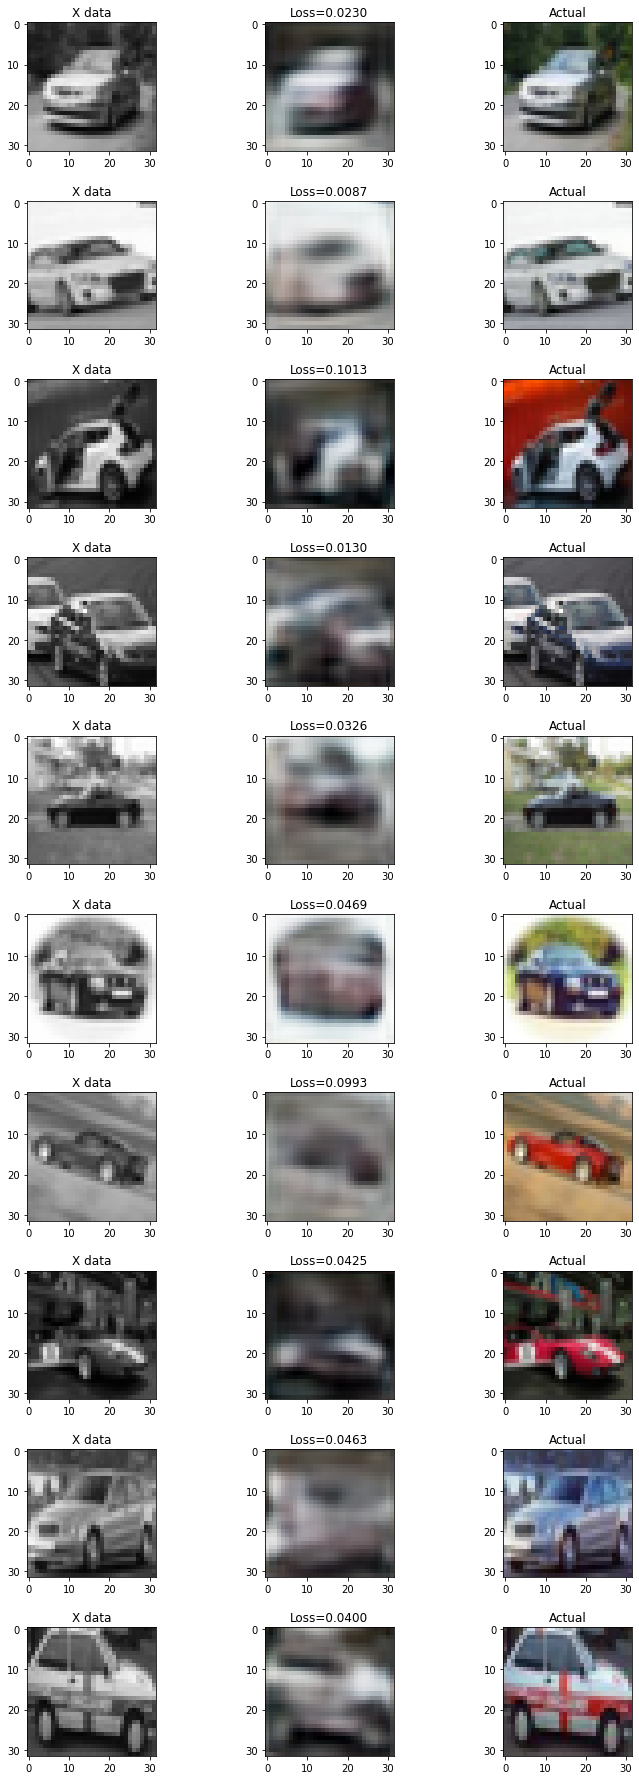

In [562]:
testModel(model8, x_test=data["X_test_class"], y_test=data["y_test_class"], criterion=nn.L1Loss())

In [24]:
class ConvNet4(nn.Module):
    def __init__(self):
        super().__init__()
        self.epochsTrained = 0
     
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.batchnorm4 = nn.BatchNorm2d(128)
        self.batchnorm5 = nn.BatchNorm2d(64)
        self.batchnorm6 = nn.BatchNorm2d(32)
          
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
              
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) 
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1) 
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(32, 3, kernel_size=3, padding=1)
     
    def forward(self, x):
        x = x[0, :, :].unsqueeze(0).unsqueeze(0)
          
        # Encoder
        scores = F.relu(self.batchnorm1(self.conv1(x)))
        scores = F.relu(self.batchnorm2(self.conv2(scores)))
        scores = F.relu(self.batchnorm3(self.conv3(scores)))
        scores = F.relu(self.batchnorm4(self.conv4(scores)))
     
        # Decoder
        scores = self.upsample(scores)
        scores = F.relu(self.batchnorm5(self.conv5(scores)))
        scores = self.upsample(scores)
        scores = F.relu(self.batchnorm6(self.conv6(scores)))
        scores = self.upsample(scores)
          
        # Add x so scores so network is better learning how to color x but not the structure of x
        scores = (torch.tanh(self.conv7(scores)) + x)
     
        # Normalize between 0-1
        scores = scores.view(-1)
        scores = (scores - torch.min(scores)) / (torch.max(scores) - torch.min(scores))

        return scores

In [116]:
learning_rate = 1e-2
model9 = ConvNet4()
optimizer = optim.SGD(model9.parameters(), lr=learning_rate)

In [117]:
train(model9, optimizer, epochs=2000, x_train=data["X_train_ship"],  y_train=data["y_train_ship"], criterion=nn.MSELoss())

--- Epoch 1 / 2000 - 1 epochs total
Iteration 0, loss = 0.0564
Iteration 20, loss = 0.0359
Iteration 40, loss = 0.0359
Iteration 60, loss = 0.0223
Iteration 80, loss = 0.0284
--- Epoch 2 / 2000 - 2 epochs total
Iteration 0, loss = 0.0162
Iteration 20, loss = 0.0177
Iteration 40, loss = 0.0427
Iteration 60, loss = 0.0245
Iteration 80, loss = 0.0186
--- Epoch 3 / 2000 - 3 epochs total
Iteration 0, loss = 0.0228
Iteration 20, loss = 0.0115
Iteration 40, loss = 0.0079
Iteration 60, loss = 0.0230
Iteration 80, loss = 0.0183
--- Epoch 4 / 2000 - 4 epochs total
Iteration 0, loss = 0.0417
Iteration 20, loss = 0.0443
Iteration 40, loss = 0.0128
Iteration 60, loss = 0.0161
Iteration 80, loss = 0.0675
--- Epoch 5 / 2000 - 5 epochs total
Iteration 0, loss = 0.0193
Iteration 20, loss = 0.0121
Iteration 40, loss = 0.0114
Iteration 60, loss = 0.0103
Iteration 80, loss = 0.0118
--- Epoch 6 / 2000 - 6 epochs total
Iteration 0, loss = 0.0122
Iteration 20, loss = 0.0150
Iteration 40, loss = 0.0095
Iterat

Iteration 40, loss = 0.0069
Iteration 60, loss = 0.0053
Iteration 80, loss = 0.0057
--- Epoch 48 / 2000 - 48 epochs total
Iteration 0, loss = 0.0211
Iteration 20, loss = 0.0081
Iteration 40, loss = 0.0137
Iteration 60, loss = 0.0073
Iteration 80, loss = 0.0190
--- Epoch 49 / 2000 - 49 epochs total
Iteration 0, loss = 0.0319
Iteration 20, loss = 0.0036
Iteration 40, loss = 0.0042
Iteration 60, loss = 0.0077
Iteration 80, loss = 0.0083
--- Epoch 50 / 2000 - 50 epochs total
Iteration 0, loss = 0.0193
Iteration 20, loss = 0.0070
Iteration 40, loss = 0.0141
Iteration 60, loss = 0.0069
Iteration 80, loss = 0.0136
--- Epoch 51 / 2000 - 51 epochs total
Iteration 0, loss = 0.0092
Iteration 20, loss = 0.0135
Iteration 40, loss = 0.0039
Iteration 60, loss = 0.0053
Iteration 80, loss = 0.0073
--- Epoch 52 / 2000 - 52 epochs total
Iteration 0, loss = 0.0134
Iteration 20, loss = 0.0284
Iteration 40, loss = 0.0093
Iteration 60, loss = 0.0035
Iteration 80, loss = 0.0096
--- Epoch 53 / 2000 - 53 epochs

Iteration 80, loss = 0.0036
--- Epoch 94 / 2000 - 94 epochs total
Iteration 0, loss = 0.0071
Iteration 20, loss = 0.0118
Iteration 40, loss = 0.0365
Iteration 60, loss = 0.0136
Iteration 80, loss = 0.0058
--- Epoch 95 / 2000 - 95 epochs total
Iteration 0, loss = 0.0229
Iteration 20, loss = 0.0042
Iteration 40, loss = 0.0121
Iteration 60, loss = 0.0134
Iteration 80, loss = 0.0080
--- Epoch 96 / 2000 - 96 epochs total
Iteration 0, loss = 0.0051
Iteration 20, loss = 0.0042
Iteration 40, loss = 0.0039
Iteration 60, loss = 0.0088
Iteration 80, loss = 0.0078
--- Epoch 97 / 2000 - 97 epochs total
Iteration 0, loss = 0.0064
Iteration 20, loss = 0.0129
Iteration 40, loss = 0.0053
Iteration 60, loss = 0.0034
Iteration 80, loss = 0.0093
--- Epoch 98 / 2000 - 98 epochs total
Iteration 0, loss = 0.0051
Iteration 20, loss = 0.0114
Iteration 40, loss = 0.0052
Iteration 60, loss = 0.0040
Iteration 80, loss = 0.0215
--- Epoch 99 / 2000 - 99 epochs total
Iteration 0, loss = 0.0035
Iteration 20, loss = 0

Iteration 60, loss = 0.0022
Iteration 80, loss = 0.0020
--- Epoch 140 / 2000 - 140 epochs total
Iteration 0, loss = 0.0022
Iteration 20, loss = 0.0082
Iteration 40, loss = 0.0074
Iteration 60, loss = 0.0028
Iteration 80, loss = 0.0020
--- Epoch 141 / 2000 - 141 epochs total
Iteration 0, loss = 0.0151
Iteration 20, loss = 0.0017
Iteration 40, loss = 0.0036
Iteration 60, loss = 0.0076
Iteration 80, loss = 0.0057
--- Epoch 142 / 2000 - 142 epochs total
Iteration 0, loss = 0.0112
Iteration 20, loss = 0.0024
Iteration 40, loss = 0.0167
Iteration 60, loss = 0.0030
Iteration 80, loss = 0.0096
--- Epoch 143 / 2000 - 143 epochs total
Iteration 0, loss = 0.0063
Iteration 20, loss = 0.0076
Iteration 40, loss = 0.0022
Iteration 60, loss = 0.0074
Iteration 80, loss = 0.0031
--- Epoch 144 / 2000 - 144 epochs total
Iteration 0, loss = 0.0203
Iteration 20, loss = 0.0069
Iteration 40, loss = 0.0070
Iteration 60, loss = 0.0058
Iteration 80, loss = 0.0025
--- Epoch 145 / 2000 - 145 epochs total
Iteration

Iteration 40, loss = 0.0055
Iteration 60, loss = 0.0044
Iteration 80, loss = 0.0046
--- Epoch 186 / 2000 - 186 epochs total
Iteration 0, loss = 0.0108
Iteration 20, loss = 0.0050
Iteration 40, loss = 0.0149
Iteration 60, loss = 0.0325
Iteration 80, loss = 0.0009
--- Epoch 187 / 2000 - 187 epochs total
Iteration 0, loss = 0.0070
Iteration 20, loss = 0.0038
Iteration 40, loss = 0.0063
Iteration 60, loss = 0.0100
Iteration 80, loss = 0.0046
--- Epoch 188 / 2000 - 188 epochs total
Iteration 0, loss = 0.0013
Iteration 20, loss = 0.0069
Iteration 40, loss = 0.0024
Iteration 60, loss = 0.0320
Iteration 80, loss = 0.0042
--- Epoch 189 / 2000 - 189 epochs total
Iteration 0, loss = 0.0077
Iteration 20, loss = 0.0012
Iteration 40, loss = 0.0152
Iteration 60, loss = 0.0055
Iteration 80, loss = 0.0023
--- Epoch 190 / 2000 - 190 epochs total
Iteration 0, loss = 0.0118
Iteration 20, loss = 0.0151
Iteration 40, loss = 0.0109
Iteration 60, loss = 0.0158
Iteration 80, loss = 0.0042
--- Epoch 191 / 2000 

Iteration 20, loss = 0.0047
Iteration 40, loss = 0.0477
Iteration 60, loss = 0.0045
Iteration 80, loss = 0.0081
--- Epoch 232 / 2000 - 232 epochs total
Iteration 0, loss = 0.0021
Iteration 20, loss = 0.0033
Iteration 40, loss = 0.0093
Iteration 60, loss = 0.0019
Iteration 80, loss = 0.0062
--- Epoch 233 / 2000 - 233 epochs total
Iteration 0, loss = 0.0078
Iteration 20, loss = 0.0053
Iteration 40, loss = 0.0030
Iteration 60, loss = 0.0042
Iteration 80, loss = 0.0047
--- Epoch 234 / 2000 - 234 epochs total
Iteration 0, loss = 0.0187
Iteration 20, loss = 0.0021
Iteration 40, loss = 0.0040
Iteration 60, loss = 0.0087
Iteration 80, loss = 0.0051
--- Epoch 235 / 2000 - 235 epochs total
Iteration 0, loss = 0.0046
Iteration 20, loss = 0.0104
Iteration 40, loss = 0.0049
Iteration 60, loss = 0.0050
Iteration 80, loss = 0.0062
--- Epoch 236 / 2000 - 236 epochs total
Iteration 0, loss = 0.0113
Iteration 20, loss = 0.0038
Iteration 40, loss = 0.0147
Iteration 60, loss = 0.0094
Iteration 80, loss = 

Iteration 20, loss = 0.0040
Iteration 40, loss = 0.0118
Iteration 60, loss = 0.0065
Iteration 80, loss = 0.0065
--- Epoch 278 / 2000 - 278 epochs total
Iteration 0, loss = 0.0040
Iteration 20, loss = 0.0135
Iteration 40, loss = 0.0134
Iteration 60, loss = 0.0120
Iteration 80, loss = 0.0341
--- Epoch 279 / 2000 - 279 epochs total
Iteration 0, loss = 0.0043
Iteration 20, loss = 0.0059
Iteration 40, loss = 0.0132
Iteration 60, loss = 0.0013
Iteration 80, loss = 0.0139
--- Epoch 280 / 2000 - 280 epochs total
Iteration 0, loss = 0.0022
Iteration 20, loss = 0.0027
Iteration 40, loss = 0.0037
Iteration 60, loss = 0.0083
Iteration 80, loss = 0.0023
--- Epoch 281 / 2000 - 281 epochs total
Iteration 0, loss = 0.0035
Iteration 20, loss = 0.0097
Iteration 40, loss = 0.0074
Iteration 60, loss = 0.0152
Iteration 80, loss = 0.0043
--- Epoch 282 / 2000 - 282 epochs total
Iteration 0, loss = 0.0128
Iteration 20, loss = 0.0039
Iteration 40, loss = 0.0206
Iteration 60, loss = 0.0032
Iteration 80, loss = 

Iteration 20, loss = 0.0168
Iteration 40, loss = 0.0052
Iteration 60, loss = 0.0031
Iteration 80, loss = 0.0017
--- Epoch 324 / 2000 - 324 epochs total
Iteration 0, loss = 0.0032
Iteration 20, loss = 0.0048
Iteration 40, loss = 0.0070
Iteration 60, loss = 0.0062
Iteration 80, loss = 0.0079
--- Epoch 325 / 2000 - 325 epochs total
Iteration 0, loss = 0.0094
Iteration 20, loss = 0.0091
Iteration 40, loss = 0.0014
Iteration 60, loss = 0.0015
Iteration 80, loss = 0.0013
--- Epoch 326 / 2000 - 326 epochs total
Iteration 0, loss = 0.0039
Iteration 20, loss = 0.0095
Iteration 40, loss = 0.0019
Iteration 60, loss = 0.0056
Iteration 80, loss = 0.0072
--- Epoch 327 / 2000 - 327 epochs total
Iteration 0, loss = 0.0060
Iteration 20, loss = 0.0028
Iteration 40, loss = 0.0015
Iteration 60, loss = 0.0055
Iteration 80, loss = 0.0143
--- Epoch 328 / 2000 - 328 epochs total
Iteration 0, loss = 0.0044
Iteration 20, loss = 0.0113
Iteration 40, loss = 0.0350
Iteration 60, loss = 0.0052
Iteration 80, loss = 

Iteration 20, loss = 0.0117
Iteration 40, loss = 0.0243
Iteration 60, loss = 0.0023
Iteration 80, loss = 0.0033
--- Epoch 370 / 2000 - 370 epochs total
Iteration 0, loss = 0.0045
Iteration 20, loss = 0.0092
Iteration 40, loss = 0.0088
Iteration 60, loss = 0.0076
Iteration 80, loss = 0.0254
--- Epoch 371 / 2000 - 371 epochs total
Iteration 0, loss = 0.0055
Iteration 20, loss = 0.0142
Iteration 40, loss = 0.0043
Iteration 60, loss = 0.0100
Iteration 80, loss = 0.0119
--- Epoch 372 / 2000 - 372 epochs total
Iteration 0, loss = 0.0025
Iteration 20, loss = 0.0020
Iteration 40, loss = 0.0052
Iteration 60, loss = 0.0070
Iteration 80, loss = 0.0049
--- Epoch 373 / 2000 - 373 epochs total
Iteration 0, loss = 0.0015
Iteration 20, loss = 0.0063
Iteration 40, loss = 0.0014
Iteration 60, loss = 0.0198
Iteration 80, loss = 0.0058
--- Epoch 374 / 2000 - 374 epochs total
Iteration 0, loss = 0.0346
Iteration 20, loss = 0.0059
Iteration 40, loss = 0.0054
Iteration 60, loss = 0.0048
Iteration 80, loss = 

Iteration 20, loss = 0.0102
Iteration 40, loss = 0.0079
Iteration 60, loss = 0.0049
Iteration 80, loss = 0.0036
--- Epoch 416 / 2000 - 416 epochs total
Iteration 0, loss = 0.0019
Iteration 20, loss = 0.0025
Iteration 40, loss = 0.0030
Iteration 60, loss = 0.0042
Iteration 80, loss = 0.0045
--- Epoch 417 / 2000 - 417 epochs total
Iteration 0, loss = 0.0047
Iteration 20, loss = 0.0059
Iteration 40, loss = 0.0053
Iteration 60, loss = 0.0083
Iteration 80, loss = 0.0026
--- Epoch 418 / 2000 - 418 epochs total
Iteration 0, loss = 0.0046
Iteration 20, loss = 0.0337
Iteration 40, loss = 0.0027
Iteration 60, loss = 0.0018
Iteration 80, loss = 0.0070
--- Epoch 419 / 2000 - 419 epochs total
Iteration 0, loss = 0.0022
Iteration 20, loss = 0.0035
Iteration 40, loss = 0.0043
Iteration 60, loss = 0.0059
Iteration 80, loss = 0.0078
--- Epoch 420 / 2000 - 420 epochs total
Iteration 0, loss = 0.0052
Iteration 20, loss = 0.0044
Iteration 40, loss = 0.0100
Iteration 60, loss = 0.0117
Iteration 80, loss = 

Iteration 20, loss = 0.0037
Iteration 40, loss = 0.0014
Iteration 60, loss = 0.0049
Iteration 80, loss = 0.0136
--- Epoch 462 / 2000 - 462 epochs total
Iteration 0, loss = 0.0019
Iteration 20, loss = 0.0084
Iteration 40, loss = 0.0079
Iteration 60, loss = 0.0015
Iteration 80, loss = 0.0042
--- Epoch 463 / 2000 - 463 epochs total
Iteration 0, loss = 0.0331
Iteration 20, loss = 0.0125
Iteration 40, loss = 0.0026
Iteration 60, loss = 0.0041
Iteration 80, loss = 0.0039
--- Epoch 464 / 2000 - 464 epochs total
Iteration 0, loss = 0.0014
Iteration 20, loss = 0.0022
Iteration 40, loss = 0.0118
Iteration 60, loss = 0.0029
Iteration 80, loss = 0.0032
--- Epoch 465 / 2000 - 465 epochs total
Iteration 0, loss = 0.0067
Iteration 20, loss = 0.0022
Iteration 40, loss = 0.0062
Iteration 60, loss = 0.0022
Iteration 80, loss = 0.0107
--- Epoch 466 / 2000 - 466 epochs total
Iteration 0, loss = 0.0080
Iteration 20, loss = 0.0019
Iteration 40, loss = 0.0036
Iteration 60, loss = 0.0055
Iteration 80, loss = 

Iteration 20, loss = 0.0063
Iteration 40, loss = 0.0063
Iteration 60, loss = 0.0022
Iteration 80, loss = 0.0102
--- Epoch 508 / 2000 - 508 epochs total
Iteration 0, loss = 0.0036
Iteration 20, loss = 0.0040
Iteration 40, loss = 0.0309
Iteration 60, loss = 0.0015
Iteration 80, loss = 0.0050
--- Epoch 509 / 2000 - 509 epochs total
Iteration 0, loss = 0.0045
Iteration 20, loss = 0.0102
Iteration 40, loss = 0.0032
Iteration 60, loss = 0.0040
Iteration 80, loss = 0.0013
--- Epoch 510 / 2000 - 510 epochs total
Iteration 0, loss = 0.0097
Iteration 20, loss = 0.0018
Iteration 40, loss = 0.0018
Iteration 60, loss = 0.0038
Iteration 80, loss = 0.0047
--- Epoch 511 / 2000 - 511 epochs total
Iteration 0, loss = 0.0130
Iteration 20, loss = 0.0079
Iteration 40, loss = 0.0033
Iteration 60, loss = 0.0241
Iteration 80, loss = 0.0061
--- Epoch 512 / 2000 - 512 epochs total
Iteration 0, loss = 0.0019
Iteration 20, loss = 0.0015
Iteration 40, loss = 0.0036
Iteration 60, loss = 0.0019
Iteration 80, loss = 

Iteration 20, loss = 0.0047
Iteration 40, loss = 0.0089
Iteration 60, loss = 0.0033
Iteration 80, loss = 0.0080
--- Epoch 554 / 2000 - 554 epochs total
Iteration 0, loss = 0.0134
Iteration 20, loss = 0.0040
Iteration 40, loss = 0.0072
Iteration 60, loss = 0.0047
Iteration 80, loss = 0.0050
--- Epoch 555 / 2000 - 555 epochs total
Iteration 0, loss = 0.0123
Iteration 20, loss = 0.0078
Iteration 40, loss = 0.0019
Iteration 60, loss = 0.0091
Iteration 80, loss = 0.0106
--- Epoch 556 / 2000 - 556 epochs total
Iteration 0, loss = 0.0063
Iteration 20, loss = 0.0080
Iteration 40, loss = 0.0037
Iteration 60, loss = 0.0016
Iteration 80, loss = 0.0023
--- Epoch 557 / 2000 - 557 epochs total
Iteration 0, loss = 0.0231
Iteration 20, loss = 0.0014
Iteration 40, loss = 0.0040
Iteration 60, loss = 0.0040
Iteration 80, loss = 0.0068
--- Epoch 558 / 2000 - 558 epochs total
Iteration 0, loss = 0.0040
Iteration 20, loss = 0.0039
Iteration 40, loss = 0.0115
Iteration 60, loss = 0.0070
Iteration 80, loss = 

Iteration 20, loss = 0.0023
Iteration 40, loss = 0.0047
Iteration 60, loss = 0.0028
Iteration 80, loss = 0.0025
--- Epoch 600 / 2000 - 600 epochs total
Iteration 0, loss = 0.0134
Iteration 20, loss = 0.0098
Iteration 40, loss = 0.0105
Iteration 60, loss = 0.0131
Iteration 80, loss = 0.0039
--- Epoch 601 / 2000 - 601 epochs total
Iteration 0, loss = 0.0117
Iteration 20, loss = 0.0024
Iteration 40, loss = 0.0023
Iteration 60, loss = 0.0234
Iteration 80, loss = 0.0014
--- Epoch 602 / 2000 - 602 epochs total
Iteration 0, loss = 0.0034
Iteration 20, loss = 0.0050
Iteration 40, loss = 0.0017
Iteration 60, loss = 0.0036
Iteration 80, loss = 0.0078
--- Epoch 603 / 2000 - 603 epochs total
Iteration 0, loss = 0.0020
Iteration 20, loss = 0.0022
Iteration 40, loss = 0.0076
Iteration 60, loss = 0.0009
Iteration 80, loss = 0.0038
--- Epoch 604 / 2000 - 604 epochs total
Iteration 0, loss = 0.0035
Iteration 20, loss = 0.0054
Iteration 40, loss = 0.0019
Iteration 60, loss = 0.0044
Iteration 80, loss = 

Iteration 20, loss = 0.0043
Iteration 40, loss = 0.0023
Iteration 60, loss = 0.0027
Iteration 80, loss = 0.0028
--- Epoch 646 / 2000 - 646 epochs total
Iteration 0, loss = 0.0037
Iteration 20, loss = 0.0033
Iteration 40, loss = 0.0190
Iteration 60, loss = 0.0045
Iteration 80, loss = 0.0037
--- Epoch 647 / 2000 - 647 epochs total
Iteration 0, loss = 0.0043
Iteration 20, loss = 0.0059
Iteration 40, loss = 0.0042
Iteration 60, loss = 0.0106
Iteration 80, loss = 0.0173
--- Epoch 648 / 2000 - 648 epochs total
Iteration 0, loss = 0.0015
Iteration 20, loss = 0.0098
Iteration 40, loss = 0.0045
Iteration 60, loss = 0.0024
Iteration 80, loss = 0.0080
--- Epoch 649 / 2000 - 649 epochs total
Iteration 0, loss = 0.0019
Iteration 20, loss = 0.0045
Iteration 40, loss = 0.0126
Iteration 60, loss = 0.0048
Iteration 80, loss = 0.0028
--- Epoch 650 / 2000 - 650 epochs total
Iteration 0, loss = 0.0058
Iteration 20, loss = 0.0128
Iteration 40, loss = 0.0045
Iteration 60, loss = 0.0033
Iteration 80, loss = 

Iteration 20, loss = 0.0042
Iteration 40, loss = 0.0185
Iteration 60, loss = 0.0014
Iteration 80, loss = 0.0022
--- Epoch 692 / 2000 - 692 epochs total
Iteration 0, loss = 0.0143
Iteration 20, loss = 0.0020
Iteration 40, loss = 0.0035
Iteration 60, loss = 0.0054
Iteration 80, loss = 0.0051
--- Epoch 693 / 2000 - 693 epochs total
Iteration 0, loss = 0.0021
Iteration 20, loss = 0.0091
Iteration 40, loss = 0.0086
Iteration 60, loss = 0.0056
Iteration 80, loss = 0.0052
--- Epoch 694 / 2000 - 694 epochs total
Iteration 0, loss = 0.0091
Iteration 20, loss = 0.0055
Iteration 40, loss = 0.0054
Iteration 60, loss = 0.0040
Iteration 80, loss = 0.0035
--- Epoch 695 / 2000 - 695 epochs total
Iteration 0, loss = 0.0026
Iteration 20, loss = 0.0085
Iteration 40, loss = 0.0056
Iteration 60, loss = 0.0069
Iteration 80, loss = 0.0087
--- Epoch 696 / 2000 - 696 epochs total
Iteration 0, loss = 0.0042
Iteration 20, loss = 0.0084
Iteration 40, loss = 0.0041
Iteration 60, loss = 0.0051
Iteration 80, loss = 

Iteration 20, loss = 0.0078
Iteration 40, loss = 0.0056
Iteration 60, loss = 0.0086
Iteration 80, loss = 0.0096
--- Epoch 738 / 2000 - 738 epochs total
Iteration 0, loss = 0.0134
Iteration 20, loss = 0.0044
Iteration 40, loss = 0.0085
Iteration 60, loss = 0.0087
Iteration 80, loss = 0.0018
--- Epoch 739 / 2000 - 739 epochs total
Iteration 0, loss = 0.0024
Iteration 20, loss = 0.0054
Iteration 40, loss = 0.0148
Iteration 60, loss = 0.0213
Iteration 80, loss = 0.0022
--- Epoch 740 / 2000 - 740 epochs total
Iteration 0, loss = 0.0016
Iteration 20, loss = 0.0030
Iteration 40, loss = 0.0017
Iteration 60, loss = 0.0041
Iteration 80, loss = 0.0067
--- Epoch 741 / 2000 - 741 epochs total
Iteration 0, loss = 0.0208
Iteration 20, loss = 0.0050
Iteration 40, loss = 0.0077
Iteration 60, loss = 0.0039
Iteration 80, loss = 0.0081
--- Epoch 742 / 2000 - 742 epochs total
Iteration 0, loss = 0.0055
Iteration 20, loss = 0.0051
Iteration 40, loss = 0.0112
Iteration 60, loss = 0.0079
Iteration 80, loss = 

Iteration 20, loss = 0.0041
Iteration 40, loss = 0.0058
Iteration 60, loss = 0.0027
Iteration 80, loss = 0.0020
--- Epoch 784 / 2000 - 784 epochs total
Iteration 0, loss = 0.0032
Iteration 20, loss = 0.0020
Iteration 40, loss = 0.0049
Iteration 60, loss = 0.0021
Iteration 80, loss = 0.0042
--- Epoch 785 / 2000 - 785 epochs total
Iteration 0, loss = 0.0053
Iteration 20, loss = 0.0094
Iteration 40, loss = 0.0030
Iteration 60, loss = 0.0035
Iteration 80, loss = 0.0062
--- Epoch 786 / 2000 - 786 epochs total
Iteration 0, loss = 0.0042
Iteration 20, loss = 0.0018
Iteration 40, loss = 0.0015
Iteration 60, loss = 0.0018
Iteration 80, loss = 0.0026
--- Epoch 787 / 2000 - 787 epochs total
Iteration 0, loss = 0.0047
Iteration 20, loss = 0.0024
Iteration 40, loss = 0.0044
Iteration 60, loss = 0.0031
Iteration 80, loss = 0.0067
--- Epoch 788 / 2000 - 788 epochs total
Iteration 0, loss = 0.0015
Iteration 20, loss = 0.0050
Iteration 40, loss = 0.0032
Iteration 60, loss = 0.0039
Iteration 80, loss = 

Iteration 20, loss = 0.0026
Iteration 40, loss = 0.0084
Iteration 60, loss = 0.0022
Iteration 80, loss = 0.0070
--- Epoch 830 / 2000 - 830 epochs total
Iteration 0, loss = 0.0017
Iteration 20, loss = 0.0028
Iteration 40, loss = 0.0034
Iteration 60, loss = 0.0031
Iteration 80, loss = 0.0059
--- Epoch 831 / 2000 - 831 epochs total
Iteration 0, loss = 0.0032
Iteration 20, loss = 0.0032
Iteration 40, loss = 0.0033
Iteration 60, loss = 0.0144
Iteration 80, loss = 0.0093
--- Epoch 832 / 2000 - 832 epochs total
Iteration 0, loss = 0.0022
Iteration 20, loss = 0.0020
Iteration 40, loss = 0.0026
Iteration 60, loss = 0.0052
Iteration 80, loss = 0.0113
--- Epoch 833 / 2000 - 833 epochs total
Iteration 0, loss = 0.0010
Iteration 20, loss = 0.0013
Iteration 40, loss = 0.0183
Iteration 60, loss = 0.0216
Iteration 80, loss = 0.0108
--- Epoch 834 / 2000 - 834 epochs total
Iteration 0, loss = 0.0097
Iteration 20, loss = 0.0063
Iteration 40, loss = 0.0085
Iteration 60, loss = 0.0143
Iteration 80, loss = 

Iteration 20, loss = 0.0019
Iteration 40, loss = 0.0018
Iteration 60, loss = 0.0040
Iteration 80, loss = 0.0053
--- Epoch 876 / 2000 - 876 epochs total
Iteration 0, loss = 0.0048
Iteration 20, loss = 0.0064
Iteration 40, loss = 0.0068
Iteration 60, loss = 0.0042
Iteration 80, loss = 0.0020
--- Epoch 877 / 2000 - 877 epochs total
Iteration 0, loss = 0.0024
Iteration 20, loss = 0.0021
Iteration 40, loss = 0.0014
Iteration 60, loss = 0.0045
Iteration 80, loss = 0.0069
--- Epoch 878 / 2000 - 878 epochs total
Iteration 0, loss = 0.0014
Iteration 20, loss = 0.0037
Iteration 40, loss = 0.0018
Iteration 60, loss = 0.0046
Iteration 80, loss = 0.0018
--- Epoch 879 / 2000 - 879 epochs total
Iteration 0, loss = 0.0030
Iteration 20, loss = 0.0021
Iteration 40, loss = 0.0066
Iteration 60, loss = 0.0030
Iteration 80, loss = 0.0228
--- Epoch 880 / 2000 - 880 epochs total
Iteration 0, loss = 0.0025
Iteration 20, loss = 0.0038
Iteration 40, loss = 0.0163
Iteration 60, loss = 0.0046
Iteration 80, loss = 

Iteration 20, loss = 0.0100
Iteration 40, loss = 0.0055
Iteration 60, loss = 0.0050
Iteration 80, loss = 0.0066
--- Epoch 922 / 2000 - 922 epochs total
Iteration 0, loss = 0.0024
Iteration 20, loss = 0.0060
Iteration 40, loss = 0.0040
Iteration 60, loss = 0.0105
Iteration 80, loss = 0.0018
--- Epoch 923 / 2000 - 923 epochs total
Iteration 0, loss = 0.0036
Iteration 20, loss = 0.0028
Iteration 40, loss = 0.0129
Iteration 60, loss = 0.0054
Iteration 80, loss = 0.0012
--- Epoch 924 / 2000 - 924 epochs total
Iteration 0, loss = 0.0044
Iteration 20, loss = 0.0041
Iteration 40, loss = 0.0034
Iteration 60, loss = 0.0023
Iteration 80, loss = 0.0102
--- Epoch 925 / 2000 - 925 epochs total
Iteration 0, loss = 0.0069
Iteration 20, loss = 0.0023
Iteration 40, loss = 0.0068
Iteration 60, loss = 0.0044
Iteration 80, loss = 0.0040
--- Epoch 926 / 2000 - 926 epochs total
Iteration 0, loss = 0.0016
Iteration 20, loss = 0.0038
Iteration 40, loss = 0.0045
Iteration 60, loss = 0.0046
Iteration 80, loss = 

Iteration 20, loss = 0.0015
Iteration 40, loss = 0.0078
Iteration 60, loss = 0.0024
Iteration 80, loss = 0.0022
--- Epoch 968 / 2000 - 968 epochs total
Iteration 0, loss = 0.0125
Iteration 20, loss = 0.0042
Iteration 40, loss = 0.0045
Iteration 60, loss = 0.0040
Iteration 80, loss = 0.0013
--- Epoch 969 / 2000 - 969 epochs total
Iteration 0, loss = 0.0073
Iteration 20, loss = 0.0042
Iteration 40, loss = 0.0034
Iteration 60, loss = 0.0029
Iteration 80, loss = 0.0021
--- Epoch 970 / 2000 - 970 epochs total
Iteration 0, loss = 0.0122
Iteration 20, loss = 0.0017
Iteration 40, loss = 0.0233
Iteration 60, loss = 0.0026
Iteration 80, loss = 0.0037
--- Epoch 971 / 2000 - 971 epochs total
Iteration 0, loss = 0.0038
Iteration 20, loss = 0.0012
Iteration 40, loss = 0.0027
Iteration 60, loss = 0.0021
Iteration 80, loss = 0.0020
--- Epoch 972 / 2000 - 972 epochs total
Iteration 0, loss = 0.0073
Iteration 20, loss = 0.0015
Iteration 40, loss = 0.0047
Iteration 60, loss = 0.0081
Iteration 80, loss = 

KeyboardInterrupt: 

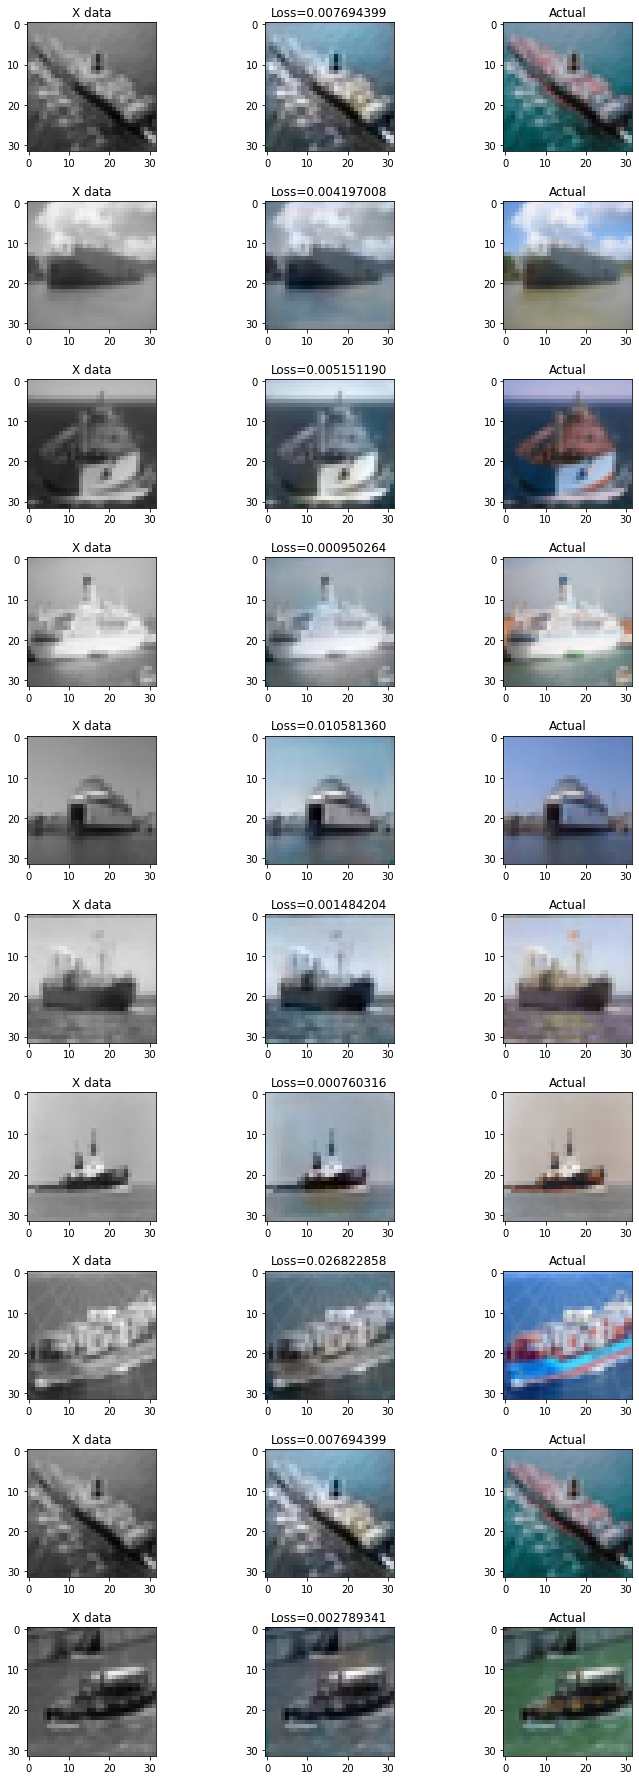

In [120]:
testModel(model9, x_test=data["X_test_ship"], y_test=data["y_test_ship"], criterion=nn.MSELoss())

In [47]:
learning_rate = 1e-2
model11 = ConvNet4()
optimizer = optim.SGD(model11.parameters(), lr=learning_rate)

In [130]:
train(model11, optimizer, epochs=419, x_train=data["X_train_frog"],  y_train=data["y_train_frog"], criterion=nn.MSELoss())

--- Epoch 1 / 419 - 2582 epochs total
Iteration 0, loss = 0.0035
Iteration 20, loss = 0.0050
Iteration 40, loss = 0.0089
Iteration 60, loss = 0.0039
Iteration 80, loss = 0.0044
--- Epoch 2 / 419 - 2583 epochs total
Iteration 0, loss = 0.0051
Iteration 20, loss = 0.0023
Iteration 40, loss = 0.0068
Iteration 60, loss = 0.0017
Iteration 80, loss = 0.0045
--- Epoch 3 / 419 - 2584 epochs total
Iteration 0, loss = 0.0016
Iteration 20, loss = 0.0024
Iteration 40, loss = 0.0044
Iteration 60, loss = 0.0061
Iteration 80, loss = 0.0018
--- Epoch 4 / 419 - 2585 epochs total
Iteration 0, loss = 0.0027
Iteration 20, loss = 0.0024
Iteration 40, loss = 0.0033
Iteration 60, loss = 0.0158
Iteration 80, loss = 0.0029
--- Epoch 5 / 419 - 2586 epochs total
Iteration 0, loss = 0.0046
Iteration 20, loss = 0.0022
Iteration 40, loss = 0.0053
Iteration 60, loss = 0.0011
Iteration 80, loss = 0.0019
--- Epoch 6 / 419 - 2587 epochs total
Iteration 0, loss = 0.0025
Iteration 20, loss = 0.0038
Iteration 40, loss = 0

Iteration 20, loss = 0.0022
Iteration 40, loss = 0.0067
Iteration 60, loss = 0.0038
Iteration 80, loss = 0.0061
--- Epoch 48 / 419 - 2629 epochs total
Iteration 0, loss = 0.0034
Iteration 20, loss = 0.0038
Iteration 40, loss = 0.0063


KeyboardInterrupt: 

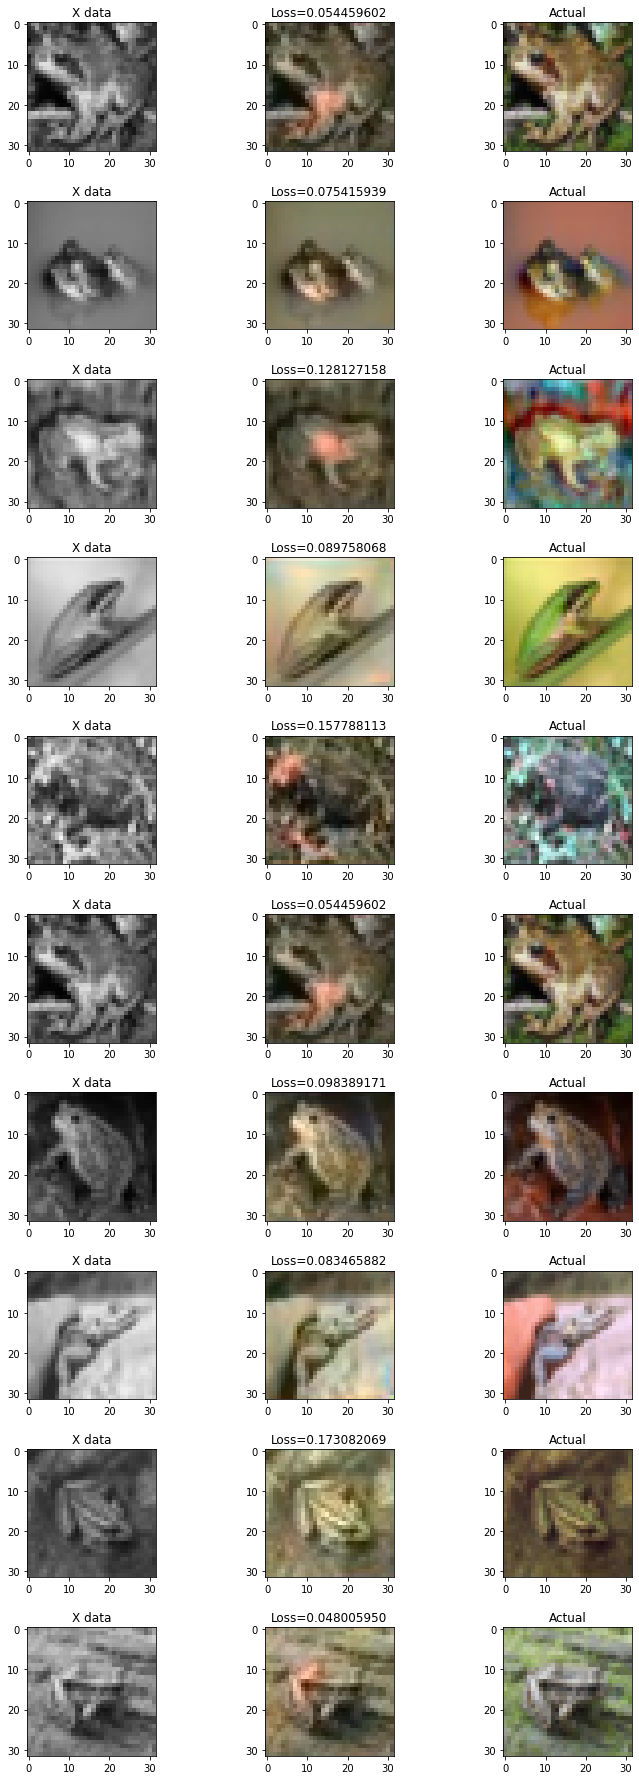

In [169]:
testModel(model11, x_test=data["X_test_frog"], y_test=data["y_test_frog"], criterion=nn.L1Loss())

In [52]:
learning_rate = 1e-2
model12 = ConvNet4()
optimizer = optim.SGD(model12.parameters(), lr=learning_rate)

In [124]:
train(model12, optimizer, epochs=1506, x_train=data["X_train_horse"],  y_train=data["y_train_horse"], criterion=nn.MSELoss())

--- Epoch 1 / 1506 - 1495 epochs total
Iteration 0, loss = 0.0038
Iteration 20, loss = 0.0025
Iteration 40, loss = 0.0029
Iteration 60, loss = 0.0021
Iteration 80, loss = 0.0085
--- Epoch 2 / 1506 - 1496 epochs total
Iteration 0, loss = 0.0033
Iteration 20, loss = 0.0085
Iteration 40, loss = 0.0043
Iteration 60, loss = 0.0025
Iteration 80, loss = 0.0037
--- Epoch 3 / 1506 - 1497 epochs total
Iteration 0, loss = 0.0035
Iteration 20, loss = 0.0051
Iteration 40, loss = 0.0038
Iteration 60, loss = 0.0160
Iteration 80, loss = 0.0053
--- Epoch 4 / 1506 - 1498 epochs total
Iteration 0, loss = 0.0024
Iteration 20, loss = 0.0028
Iteration 40, loss = 0.0023
Iteration 60, loss = 0.0024
Iteration 80, loss = 0.0053
--- Epoch 5 / 1506 - 1499 epochs total
Iteration 0, loss = 0.0037
Iteration 20, loss = 0.0059
Iteration 40, loss = 0.0021
Iteration 60, loss = 0.0059
Iteration 80, loss = 0.0034
--- Epoch 6 / 1506 - 1500 epochs total
Iteration 0, loss = 0.0059
Iteration 20, loss = 0.0060
Iteration 40, lo

Iteration 80, loss = 0.0034
--- Epoch 47 / 1506 - 1541 epochs total
Iteration 0, loss = 0.0194
Iteration 20, loss = 0.0026
Iteration 40, loss = 0.0036
Iteration 60, loss = 0.0037
Iteration 80, loss = 0.0026
--- Epoch 48 / 1506 - 1542 epochs total
Iteration 0, loss = 0.0069
Iteration 20, loss = 0.0071
Iteration 40, loss = 0.0068
Iteration 60, loss = 0.0024
Iteration 80, loss = 0.0026
--- Epoch 49 / 1506 - 1543 epochs total
Iteration 0, loss = 0.0021
Iteration 20, loss = 0.0036
Iteration 40, loss = 0.0057
Iteration 60, loss = 0.0015
Iteration 80, loss = 0.0025
--- Epoch 50 / 1506 - 1544 epochs total
Iteration 0, loss = 0.0036
Iteration 20, loss = 0.0037
Iteration 40, loss = 0.0072
Iteration 60, loss = 0.0028
Iteration 80, loss = 0.0226
--- Epoch 51 / 1506 - 1545 epochs total
Iteration 0, loss = 0.0025
Iteration 20, loss = 0.0033
Iteration 40, loss = 0.0048
Iteration 60, loss = 0.0027
Iteration 80, loss = 0.0097
--- Epoch 52 / 1506 - 1546 epochs total
Iteration 0, loss = 0.0109
Iteration 

Iteration 60, loss = 0.0048
Iteration 80, loss = 0.0052
--- Epoch 93 / 1506 - 1587 epochs total
Iteration 0, loss = 0.0013
Iteration 20, loss = 0.0107
Iteration 40, loss = 0.0040
Iteration 60, loss = 0.0051
Iteration 80, loss = 0.0040
--- Epoch 94 / 1506 - 1588 epochs total
Iteration 0, loss = 0.0031
Iteration 20, loss = 0.0016
Iteration 40, loss = 0.0043
Iteration 60, loss = 0.0070
Iteration 80, loss = 0.0037
--- Epoch 95 / 1506 - 1589 epochs total
Iteration 0, loss = 0.0064
Iteration 20, loss = 0.0047
Iteration 40, loss = 0.0041
Iteration 60, loss = 0.0032
Iteration 80, loss = 0.0028
--- Epoch 96 / 1506 - 1590 epochs total
Iteration 0, loss = 0.0029
Iteration 20, loss = 0.0059
Iteration 40, loss = 0.0043
Iteration 60, loss = 0.0043
Iteration 80, loss = 0.0044
--- Epoch 97 / 1506 - 1591 epochs total
Iteration 0, loss = 0.0018
Iteration 20, loss = 0.0020
Iteration 40, loss = 0.0025
Iteration 60, loss = 0.0032
Iteration 80, loss = 0.0028
--- Epoch 98 / 1506 - 1592 epochs total
Iteration

Iteration 20, loss = 0.0080
Iteration 40, loss = 0.0027
Iteration 60, loss = 0.0055
Iteration 80, loss = 0.0154
--- Epoch 139 / 1506 - 1633 epochs total
Iteration 0, loss = 0.0039
Iteration 20, loss = 0.0030
Iteration 40, loss = 0.0041
Iteration 60, loss = 0.0033
Iteration 80, loss = 0.0032
--- Epoch 140 / 1506 - 1634 epochs total
Iteration 0, loss = 0.0121
Iteration 20, loss = 0.0034
Iteration 40, loss = 0.0028
Iteration 60, loss = 0.0036
Iteration 80, loss = 0.0023
--- Epoch 141 / 1506 - 1635 epochs total
Iteration 0, loss = 0.0063
Iteration 20, loss = 0.0039
Iteration 40, loss = 0.0064
Iteration 60, loss = 0.0030
Iteration 80, loss = 0.0058
--- Epoch 142 / 1506 - 1636 epochs total
Iteration 0, loss = 0.0019
Iteration 20, loss = 0.0023
Iteration 40, loss = 0.0030
Iteration 60, loss = 0.0026
Iteration 80, loss = 0.0024
--- Epoch 143 / 1506 - 1637 epochs total
Iteration 0, loss = 0.0040
Iteration 20, loss = 0.0033
Iteration 40, loss = 0.0031
Iteration 60, loss = 0.0059
Iteration 80, lo

--- Epoch 184 / 1506 - 1678 epochs total
Iteration 0, loss = 0.0046
Iteration 20, loss = 0.0051
Iteration 40, loss = 0.0021
Iteration 60, loss = 0.0039
Iteration 80, loss = 0.0069
--- Epoch 185 / 1506 - 1679 epochs total
Iteration 0, loss = 0.0033
Iteration 20, loss = 0.0055
Iteration 40, loss = 0.0034
Iteration 60, loss = 0.0042
Iteration 80, loss = 0.0031
--- Epoch 186 / 1506 - 1680 epochs total
Iteration 0, loss = 0.0035
Iteration 20, loss = 0.0050
Iteration 40, loss = 0.0020
Iteration 60, loss = 0.0039
Iteration 80, loss = 0.0050
--- Epoch 187 / 1506 - 1681 epochs total
Iteration 0, loss = 0.0046
Iteration 20, loss = 0.0156
Iteration 40, loss = 0.0023
Iteration 60, loss = 0.0027
Iteration 80, loss = 0.0041
--- Epoch 188 / 1506 - 1682 epochs total
Iteration 0, loss = 0.0062
Iteration 20, loss = 0.0029
Iteration 40, loss = 0.0039
Iteration 60, loss = 0.0018
Iteration 80, loss = 0.0044
--- Epoch 189 / 1506 - 1683 epochs total
Iteration 0, loss = 0.0036
Iteration 20, loss = 0.0033
Iter

Iteration 40, loss = 0.0029
Iteration 60, loss = 0.0091
Iteration 80, loss = 0.0176
--- Epoch 230 / 1506 - 1724 epochs total
Iteration 0, loss = 0.0036
Iteration 20, loss = 0.0046
Iteration 40, loss = 0.0027
Iteration 60, loss = 0.0033
Iteration 80, loss = 0.0030
--- Epoch 231 / 1506 - 1725 epochs total
Iteration 0, loss = 0.0053
Iteration 20, loss = 0.0023
Iteration 40, loss = 0.0028
Iteration 60, loss = 0.0049
Iteration 80, loss = 0.0020
--- Epoch 232 / 1506 - 1726 epochs total
Iteration 0, loss = 0.0042
Iteration 20, loss = 0.0017
Iteration 40, loss = 0.0043
Iteration 60, loss = 0.0045
Iteration 80, loss = 0.0061
--- Epoch 233 / 1506 - 1727 epochs total
Iteration 0, loss = 0.0033
Iteration 20, loss = 0.0036
Iteration 40, loss = 0.0024
Iteration 60, loss = 0.0034
Iteration 80, loss = 0.0037
--- Epoch 234 / 1506 - 1728 epochs total
Iteration 0, loss = 0.0041
Iteration 20, loss = 0.0031
Iteration 40, loss = 0.0035
Iteration 60, loss = 0.0073
Iteration 80, loss = 0.0021
--- Epoch 235 / 

Iteration 20, loss = 0.0018
Iteration 40, loss = 0.0031
Iteration 60, loss = 0.0029
Iteration 80, loss = 0.0034
--- Epoch 276 / 1506 - 1770 epochs total
Iteration 0, loss = 0.0046
Iteration 20, loss = 0.0051
Iteration 40, loss = 0.0040
Iteration 60, loss = 0.0049
Iteration 80, loss = 0.0037
--- Epoch 277 / 1506 - 1771 epochs total
Iteration 0, loss = 0.0025
Iteration 20, loss = 0.0254
Iteration 40, loss = 0.0026
Iteration 60, loss = 0.0040
Iteration 80, loss = 0.0023
--- Epoch 278 / 1506 - 1772 epochs total
Iteration 0, loss = 0.0099
Iteration 20, loss = 0.0022
Iteration 40, loss = 0.0230
Iteration 60, loss = 0.0041
Iteration 80, loss = 0.0057
--- Epoch 279 / 1506 - 1773 epochs total
Iteration 0, loss = 0.0035
Iteration 20, loss = 0.0046
Iteration 40, loss = 0.0026
Iteration 60, loss = 0.0129
Iteration 80, loss = 0.0034
--- Epoch 280 / 1506 - 1774 epochs total
Iteration 0, loss = 0.0085
Iteration 20, loss = 0.0137
Iteration 40, loss = 0.0036
Iteration 60, loss = 0.0031
Iteration 80, lo

--- Epoch 321 / 1506 - 1815 epochs total
Iteration 0, loss = 0.0071
Iteration 20, loss = 0.0029
Iteration 40, loss = 0.0013
Iteration 60, loss = 0.0253
Iteration 80, loss = 0.0082
--- Epoch 322 / 1506 - 1816 epochs total
Iteration 0, loss = 0.0046
Iteration 20, loss = 0.0107
Iteration 40, loss = 0.0017
Iteration 60, loss = 0.0028
Iteration 80, loss = 0.0068
--- Epoch 323 / 1506 - 1817 epochs total
Iteration 0, loss = 0.0048
Iteration 20, loss = 0.0031
Iteration 40, loss = 0.0111
Iteration 60, loss = 0.0024
Iteration 80, loss = 0.0020
--- Epoch 324 / 1506 - 1818 epochs total
Iteration 0, loss = 0.0031
Iteration 20, loss = 0.0018
Iteration 40, loss = 0.0033
Iteration 60, loss = 0.0033
Iteration 80, loss = 0.0014
--- Epoch 325 / 1506 - 1819 epochs total
Iteration 0, loss = 0.0079
Iteration 20, loss = 0.0031
Iteration 40, loss = 0.0033
Iteration 60, loss = 0.0061
Iteration 80, loss = 0.0032
--- Epoch 326 / 1506 - 1820 epochs total
Iteration 0, loss = 0.0055
Iteration 20, loss = 0.0040
Iter

Iteration 40, loss = 0.0086
Iteration 60, loss = 0.0048
Iteration 80, loss = 0.0080
--- Epoch 367 / 1506 - 1861 epochs total
Iteration 0, loss = 0.0058
Iteration 20, loss = 0.0030
Iteration 40, loss = 0.0063
Iteration 60, loss = 0.0041
Iteration 80, loss = 0.0046
--- Epoch 368 / 1506 - 1862 epochs total
Iteration 0, loss = 0.0040
Iteration 20, loss = 0.0025
Iteration 40, loss = 0.0020
Iteration 60, loss = 0.0038
Iteration 80, loss = 0.0042
--- Epoch 369 / 1506 - 1863 epochs total
Iteration 0, loss = 0.0045
Iteration 20, loss = 0.0152
Iteration 40, loss = 0.0046
Iteration 60, loss = 0.0057
Iteration 80, loss = 0.0025
--- Epoch 370 / 1506 - 1864 epochs total
Iteration 0, loss = 0.0040
Iteration 20, loss = 0.0071
Iteration 40, loss = 0.0108
Iteration 60, loss = 0.0048
Iteration 80, loss = 0.0036
--- Epoch 371 / 1506 - 1865 epochs total
Iteration 0, loss = 0.0025
Iteration 20, loss = 0.0039
Iteration 40, loss = 0.0053
Iteration 60, loss = 0.0024
Iteration 80, loss = 0.0072
--- Epoch 372 / 

Iteration 20, loss = 0.0017
Iteration 40, loss = 0.0061
Iteration 60, loss = 0.0038
Iteration 80, loss = 0.0148
--- Epoch 413 / 1506 - 1907 epochs total
Iteration 0, loss = 0.0035
Iteration 20, loss = 0.0022
Iteration 40, loss = 0.0022
Iteration 60, loss = 0.0049
Iteration 80, loss = 0.0059
--- Epoch 414 / 1506 - 1908 epochs total
Iteration 0, loss = 0.0030
Iteration 20, loss = 0.0036
Iteration 40, loss = 0.0083
Iteration 60, loss = 0.0143
Iteration 80, loss = 0.0011
--- Epoch 415 / 1506 - 1909 epochs total
Iteration 0, loss = 0.0052
Iteration 20, loss = 0.0072
Iteration 40, loss = 0.0027
Iteration 60, loss = 0.0123
Iteration 80, loss = 0.0021
--- Epoch 416 / 1506 - 1910 epochs total
Iteration 0, loss = 0.0178
Iteration 20, loss = 0.0038
Iteration 40, loss = 0.0035
Iteration 60, loss = 0.0024
Iteration 80, loss = 0.0030
--- Epoch 417 / 1506 - 1911 epochs total
Iteration 0, loss = 0.0029
Iteration 20, loss = 0.0015
Iteration 40, loss = 0.0052
Iteration 60, loss = 0.0052
Iteration 80, lo

--- Epoch 458 / 1506 - 1952 epochs total
Iteration 0, loss = 0.0035
Iteration 20, loss = 0.0089
Iteration 40, loss = 0.0022
Iteration 60, loss = 0.0043
Iteration 80, loss = 0.0021
--- Epoch 459 / 1506 - 1953 epochs total
Iteration 0, loss = 0.0013
Iteration 20, loss = 0.0019
Iteration 40, loss = 0.0031
Iteration 60, loss = 0.0131
Iteration 80, loss = 0.0066
--- Epoch 460 / 1506 - 1954 epochs total
Iteration 0, loss = 0.0020
Iteration 20, loss = 0.0126
Iteration 40, loss = 0.0061
Iteration 60, loss = 0.0030
Iteration 80, loss = 0.0045
--- Epoch 461 / 1506 - 1955 epochs total
Iteration 0, loss = 0.0022
Iteration 20, loss = 0.0027
Iteration 40, loss = 0.0021
Iteration 60, loss = 0.0048
Iteration 80, loss = 0.0026
--- Epoch 462 / 1506 - 1956 epochs total
Iteration 0, loss = 0.0023
Iteration 20, loss = 0.0091
Iteration 40, loss = 0.0036
Iteration 60, loss = 0.0029
Iteration 80, loss = 0.0032
--- Epoch 463 / 1506 - 1957 epochs total
Iteration 0, loss = 0.0037
Iteration 20, loss = 0.0038
Iter

Iteration 40, loss = 0.0065
Iteration 60, loss = 0.0046
Iteration 80, loss = 0.0068
--- Epoch 504 / 1506 - 1998 epochs total
Iteration 0, loss = 0.0076
Iteration 20, loss = 0.0060
Iteration 40, loss = 0.0015
Iteration 60, loss = 0.0048
Iteration 80, loss = 0.0033
--- Epoch 505 / 1506 - 1999 epochs total
Iteration 0, loss = 0.0059
Iteration 20, loss = 0.0053
Iteration 40, loss = 0.0038
Iteration 60, loss = 0.0027
Iteration 80, loss = 0.0035
--- Epoch 506 / 1506 - 2000 epochs total
Iteration 0, loss = 0.0028
Iteration 20, loss = 0.0028
Iteration 40, loss = 0.0032
Iteration 60, loss = 0.0069
Iteration 80, loss = 0.0027
--- Epoch 507 / 1506 - 2001 epochs total
Iteration 0, loss = 0.0028
Iteration 20, loss = 0.0051
Iteration 40, loss = 0.0055
Iteration 60, loss = 0.0037
Iteration 80, loss = 0.0023
--- Epoch 508 / 1506 - 2002 epochs total
Iteration 0, loss = 0.0100
Iteration 20, loss = 0.0021
Iteration 40, loss = 0.0016
Iteration 60, loss = 0.0032
Iteration 80, loss = 0.0048
--- Epoch 509 / 

Iteration 20, loss = 0.0119
Iteration 40, loss = 0.0050
Iteration 60, loss = 0.0021
Iteration 80, loss = 0.0028
--- Epoch 550 / 1506 - 2044 epochs total
Iteration 0, loss = 0.0143
Iteration 20, loss = 0.0077
Iteration 40, loss = 0.0021
Iteration 60, loss = 0.0028
Iteration 80, loss = 0.0071
--- Epoch 551 / 1506 - 2045 epochs total
Iteration 0, loss = 0.0034
Iteration 20, loss = 0.0036
Iteration 40, loss = 0.0052
Iteration 60, loss = 0.0107
Iteration 80, loss = 0.0065
--- Epoch 552 / 1506 - 2046 epochs total
Iteration 0, loss = 0.0090
Iteration 20, loss = 0.0037
Iteration 40, loss = 0.0095
Iteration 60, loss = 0.0063
Iteration 80, loss = 0.0027
--- Epoch 553 / 1506 - 2047 epochs total
Iteration 0, loss = 0.0030
Iteration 20, loss = 0.0038
Iteration 40, loss = 0.0138
Iteration 60, loss = 0.0032
Iteration 80, loss = 0.0051
--- Epoch 554 / 1506 - 2048 epochs total
Iteration 0, loss = 0.0099
Iteration 20, loss = 0.0035
Iteration 40, loss = 0.0042
Iteration 60, loss = 0.0049
Iteration 80, lo

--- Epoch 595 / 1506 - 2089 epochs total
Iteration 0, loss = 0.0099
Iteration 20, loss = 0.0065
Iteration 40, loss = 0.0130
Iteration 60, loss = 0.0055
Iteration 80, loss = 0.0037
--- Epoch 596 / 1506 - 2090 epochs total
Iteration 0, loss = 0.0095
Iteration 20, loss = 0.0116
Iteration 40, loss = 0.0041
Iteration 60, loss = 0.0110
Iteration 80, loss = 0.0031
--- Epoch 597 / 1506 - 2091 epochs total
Iteration 0, loss = 0.0131
Iteration 20, loss = 0.0035
Iteration 40, loss = 0.0029
Iteration 60, loss = 0.0046
Iteration 80, loss = 0.0042
--- Epoch 598 / 1506 - 2092 epochs total
Iteration 0, loss = 0.0037
Iteration 20, loss = 0.0045
Iteration 40, loss = 0.0022
Iteration 60, loss = 0.0027
Iteration 80, loss = 0.0116
--- Epoch 599 / 1506 - 2093 epochs total
Iteration 0, loss = 0.0111
Iteration 20, loss = 0.0035
Iteration 40, loss = 0.0031
Iteration 60, loss = 0.0028
Iteration 80, loss = 0.0023
--- Epoch 600 / 1506 - 2094 epochs total
Iteration 0, loss = 0.0034
Iteration 20, loss = 0.0049
Iter

Iteration 40, loss = 0.0039
Iteration 60, loss = 0.0095
Iteration 80, loss = 0.0046
--- Epoch 641 / 1506 - 2135 epochs total
Iteration 0, loss = 0.0030
Iteration 20, loss = 0.0023
Iteration 40, loss = 0.0043
Iteration 60, loss = 0.0071
Iteration 80, loss = 0.0052
--- Epoch 642 / 1506 - 2136 epochs total
Iteration 0, loss = 0.0033
Iteration 20, loss = 0.0019
Iteration 40, loss = 0.0031
Iteration 60, loss = 0.0041
Iteration 80, loss = 0.0046
--- Epoch 643 / 1506 - 2137 epochs total
Iteration 0, loss = 0.0023
Iteration 20, loss = 0.0025
Iteration 40, loss = 0.0021
Iteration 60, loss = 0.0028
Iteration 80, loss = 0.0029
--- Epoch 644 / 1506 - 2138 epochs total
Iteration 0, loss = 0.0049
Iteration 20, loss = 0.0051
Iteration 40, loss = 0.0037
Iteration 60, loss = 0.0038
Iteration 80, loss = 0.0020
--- Epoch 645 / 1506 - 2139 epochs total
Iteration 0, loss = 0.0019
Iteration 20, loss = 0.0064
Iteration 40, loss = 0.0044
Iteration 60, loss = 0.0026
Iteration 80, loss = 0.0017
--- Epoch 646 / 

Iteration 20, loss = 0.0120
Iteration 40, loss = 0.0036
Iteration 60, loss = 0.0059
Iteration 80, loss = 0.0079
--- Epoch 687 / 1506 - 2181 epochs total
Iteration 0, loss = 0.0035
Iteration 20, loss = 0.0045
Iteration 40, loss = 0.0037
Iteration 60, loss = 0.0018
Iteration 80, loss = 0.0122
--- Epoch 688 / 1506 - 2182 epochs total
Iteration 0, loss = 0.0072
Iteration 20, loss = 0.0025
Iteration 40, loss = 0.0050
Iteration 60, loss = 0.0022
Iteration 80, loss = 0.0038
--- Epoch 689 / 1506 - 2183 epochs total
Iteration 0, loss = 0.0049
Iteration 20, loss = 0.0059
Iteration 40, loss = 0.0037
Iteration 60, loss = 0.0032
Iteration 80, loss = 0.0034
--- Epoch 690 / 1506 - 2184 epochs total
Iteration 0, loss = 0.0041
Iteration 20, loss = 0.0042
Iteration 40, loss = 0.0017
Iteration 60, loss = 0.0035
Iteration 80, loss = 0.0021
--- Epoch 691 / 1506 - 2185 epochs total
Iteration 0, loss = 0.0029
Iteration 20, loss = 0.0253
Iteration 40, loss = 0.0077
Iteration 60, loss = 0.0066
Iteration 80, lo

--- Epoch 732 / 1506 - 2226 epochs total
Iteration 0, loss = 0.0044
Iteration 20, loss = 0.0090
Iteration 40, loss = 0.0038
Iteration 60, loss = 0.0043
Iteration 80, loss = 0.0035
--- Epoch 733 / 1506 - 2227 epochs total
Iteration 0, loss = 0.0094
Iteration 20, loss = 0.0023
Iteration 40, loss = 0.0028
Iteration 60, loss = 0.0059
Iteration 80, loss = 0.0036
--- Epoch 734 / 1506 - 2228 epochs total
Iteration 0, loss = 0.0027
Iteration 20, loss = 0.0031
Iteration 40, loss = 0.0067
Iteration 60, loss = 0.0040
Iteration 80, loss = 0.0027
--- Epoch 735 / 1506 - 2229 epochs total
Iteration 0, loss = 0.0024
Iteration 20, loss = 0.0047
Iteration 40, loss = 0.0046
Iteration 60, loss = 0.0043
Iteration 80, loss = 0.0041
--- Epoch 736 / 1506 - 2230 epochs total
Iteration 0, loss = 0.0040
Iteration 20, loss = 0.0035
Iteration 40, loss = 0.0026
Iteration 60, loss = 0.0028
Iteration 80, loss = 0.0064
--- Epoch 737 / 1506 - 2231 epochs total
Iteration 0, loss = 0.0026
Iteration 20, loss = 0.0025
Iter

Iteration 40, loss = 0.0033
Iteration 60, loss = 0.0022
Iteration 80, loss = 0.0159
--- Epoch 778 / 1506 - 2272 epochs total
Iteration 0, loss = 0.0037
Iteration 20, loss = 0.0035
Iteration 40, loss = 0.0074
Iteration 60, loss = 0.0087
Iteration 80, loss = 0.0057
--- Epoch 779 / 1506 - 2273 epochs total
Iteration 0, loss = 0.0035
Iteration 20, loss = 0.0026
Iteration 40, loss = 0.0065
Iteration 60, loss = 0.0035
Iteration 80, loss = 0.0048
--- Epoch 780 / 1506 - 2274 epochs total
Iteration 0, loss = 0.0069
Iteration 20, loss = 0.0082
Iteration 40, loss = 0.0032
Iteration 60, loss = 0.0072
Iteration 80, loss = 0.0032
--- Epoch 781 / 1506 - 2275 epochs total
Iteration 0, loss = 0.0028
Iteration 20, loss = 0.0254
Iteration 40, loss = 0.0040
Iteration 60, loss = 0.0068
Iteration 80, loss = 0.0223
--- Epoch 782 / 1506 - 2276 epochs total
Iteration 0, loss = 0.0067
Iteration 20, loss = 0.0030
Iteration 40, loss = 0.0032
Iteration 60, loss = 0.0071
Iteration 80, loss = 0.0072
--- Epoch 783 / 

Iteration 20, loss = 0.0038
Iteration 40, loss = 0.0052
Iteration 60, loss = 0.0043
Iteration 80, loss = 0.0189
--- Epoch 824 / 1506 - 2318 epochs total
Iteration 0, loss = 0.0066
Iteration 20, loss = 0.0021
Iteration 40, loss = 0.0022
Iteration 60, loss = 0.0030
Iteration 80, loss = 0.0025
--- Epoch 825 / 1506 - 2319 epochs total
Iteration 0, loss = 0.0036
Iteration 20, loss = 0.0030
Iteration 40, loss = 0.0037
Iteration 60, loss = 0.0030
Iteration 80, loss = 0.0041
--- Epoch 826 / 1506 - 2320 epochs total
Iteration 0, loss = 0.0027
Iteration 20, loss = 0.0030
Iteration 40, loss = 0.0023
Iteration 60, loss = 0.0041
Iteration 80, loss = 0.0026
--- Epoch 827 / 1506 - 2321 epochs total
Iteration 0, loss = 0.0114
Iteration 20, loss = 0.0025
Iteration 40, loss = 0.0081
Iteration 60, loss = 0.0037
Iteration 80, loss = 0.0086
--- Epoch 828 / 1506 - 2322 epochs total
Iteration 0, loss = 0.0021
Iteration 20, loss = 0.0037
Iteration 40, loss = 0.0041
Iteration 60, loss = 0.0030
Iteration 80, lo

--- Epoch 869 / 1506 - 2363 epochs total
Iteration 0, loss = 0.0214
Iteration 20, loss = 0.0039
Iteration 40, loss = 0.0076
Iteration 60, loss = 0.0066
Iteration 80, loss = 0.0079
--- Epoch 870 / 1506 - 2364 epochs total
Iteration 0, loss = 0.0016
Iteration 20, loss = 0.0028
Iteration 40, loss = 0.0068
Iteration 60, loss = 0.0071
Iteration 80, loss = 0.0041
--- Epoch 871 / 1506 - 2365 epochs total
Iteration 0, loss = 0.0050
Iteration 20, loss = 0.0031
Iteration 40, loss = 0.0080
Iteration 60, loss = 0.0079
Iteration 80, loss = 0.0017
--- Epoch 872 / 1506 - 2366 epochs total
Iteration 0, loss = 0.0026
Iteration 20, loss = 0.0029
Iteration 40, loss = 0.0047
Iteration 60, loss = 0.0024
Iteration 80, loss = 0.0054
--- Epoch 873 / 1506 - 2367 epochs total
Iteration 0, loss = 0.0036
Iteration 20, loss = 0.0024
Iteration 40, loss = 0.0052
Iteration 60, loss = 0.0073
Iteration 80, loss = 0.0027
--- Epoch 874 / 1506 - 2368 epochs total
Iteration 0, loss = 0.0034
Iteration 20, loss = 0.0078
Iter

Iteration 40, loss = 0.0026
Iteration 60, loss = 0.0020
Iteration 80, loss = 0.0025
--- Epoch 915 / 1506 - 2409 epochs total
Iteration 0, loss = 0.0018
Iteration 20, loss = 0.0029
Iteration 40, loss = 0.0049
Iteration 60, loss = 0.0018
Iteration 80, loss = 0.0052
--- Epoch 916 / 1506 - 2410 epochs total
Iteration 0, loss = 0.0053
Iteration 20, loss = 0.0088
Iteration 40, loss = 0.0029
Iteration 60, loss = 0.0041
Iteration 80, loss = 0.0018
--- Epoch 917 / 1506 - 2411 epochs total
Iteration 0, loss = 0.0063
Iteration 20, loss = 0.0027
Iteration 40, loss = 0.0027
Iteration 60, loss = 0.0029
Iteration 80, loss = 0.0019
--- Epoch 918 / 1506 - 2412 epochs total
Iteration 0, loss = 0.0016
Iteration 20, loss = 0.0051
Iteration 40, loss = 0.0117
Iteration 60, loss = 0.0071
Iteration 80, loss = 0.0040
--- Epoch 919 / 1506 - 2413 epochs total
Iteration 0, loss = 0.0020
Iteration 20, loss = 0.0018
Iteration 40, loss = 0.0057
Iteration 60, loss = 0.0036
Iteration 80, loss = 0.0185
--- Epoch 920 / 

Iteration 20, loss = 0.0027
Iteration 40, loss = 0.0029
Iteration 60, loss = 0.0044
Iteration 80, loss = 0.0042
--- Epoch 961 / 1506 - 2455 epochs total
Iteration 0, loss = 0.0039
Iteration 20, loss = 0.0097
Iteration 40, loss = 0.0033
Iteration 60, loss = 0.0035
Iteration 80, loss = 0.0032
--- Epoch 962 / 1506 - 2456 epochs total
Iteration 0, loss = 0.0043
Iteration 20, loss = 0.0024
Iteration 40, loss = 0.0019
Iteration 60, loss = 0.0071
Iteration 80, loss = 0.0280
--- Epoch 963 / 1506 - 2457 epochs total
Iteration 0, loss = 0.0036
Iteration 20, loss = 0.0034
Iteration 40, loss = 0.0022
Iteration 60, loss = 0.0041
Iteration 80, loss = 0.0035
--- Epoch 964 / 1506 - 2458 epochs total
Iteration 0, loss = 0.0028
Iteration 20, loss = 0.0027
Iteration 40, loss = 0.0020
Iteration 60, loss = 0.0061
Iteration 80, loss = 0.0031
--- Epoch 965 / 1506 - 2459 epochs total
Iteration 0, loss = 0.0032
Iteration 20, loss = 0.0031
Iteration 40, loss = 0.0027
Iteration 60, loss = 0.0046
Iteration 80, lo

--- Epoch 1006 / 1506 - 2500 epochs total
Iteration 0, loss = 0.0027
Iteration 20, loss = 0.0019
Iteration 40, loss = 0.0028
Iteration 60, loss = 0.0044
Iteration 80, loss = 0.0036
--- Epoch 1007 / 1506 - 2501 epochs total
Iteration 0, loss = 0.0029
Iteration 20, loss = 0.0011
Iteration 40, loss = 0.0042
Iteration 60, loss = 0.0066
Iteration 80, loss = 0.0036
--- Epoch 1008 / 1506 - 2502 epochs total
Iteration 0, loss = 0.0061
Iteration 20, loss = 0.0030
Iteration 40, loss = 0.0022
Iteration 60, loss = 0.0043
Iteration 80, loss = 0.0047
--- Epoch 1009 / 1506 - 2503 epochs total
Iteration 0, loss = 0.0013
Iteration 20, loss = 0.0021
Iteration 40, loss = 0.0087
Iteration 60, loss = 0.0110
Iteration 80, loss = 0.0035
--- Epoch 1010 / 1506 - 2504 epochs total
Iteration 0, loss = 0.0035
Iteration 20, loss = 0.0044
Iteration 40, loss = 0.0027
Iteration 60, loss = 0.0024
Iteration 80, loss = 0.0069
--- Epoch 1011 / 1506 - 2505 epochs total
Iteration 0, loss = 0.0032
Iteration 20, loss = 0.013

Iteration 20, loss = 0.0050
Iteration 40, loss = 0.0020
Iteration 60, loss = 0.0035
Iteration 80, loss = 0.0062
--- Epoch 1052 / 1506 - 2546 epochs total
Iteration 0, loss = 0.0028
Iteration 20, loss = 0.0040
Iteration 40, loss = 0.0063
Iteration 60, loss = 0.0039
Iteration 80, loss = 0.0084
--- Epoch 1053 / 1506 - 2547 epochs total
Iteration 0, loss = 0.0111
Iteration 20, loss = 0.0026
Iteration 40, loss = 0.0133
Iteration 60, loss = 0.0028
Iteration 80, loss = 0.0061
--- Epoch 1054 / 1506 - 2548 epochs total
Iteration 0, loss = 0.0019
Iteration 20, loss = 0.0058
Iteration 40, loss = 0.0016
Iteration 60, loss = 0.0030
Iteration 80, loss = 0.0056
--- Epoch 1055 / 1506 - 2549 epochs total
Iteration 0, loss = 0.0129
Iteration 20, loss = 0.0138
Iteration 40, loss = 0.0044
Iteration 60, loss = 0.0093
Iteration 80, loss = 0.0060
--- Epoch 1056 / 1506 - 2550 epochs total
Iteration 0, loss = 0.0150
Iteration 20, loss = 0.0050
Iteration 40, loss = 0.0030
Iteration 60, loss = 0.0061
Iteration 8

Iteration 60, loss = 0.0029
Iteration 80, loss = 0.0031
--- Epoch 1097 / 1506 - 2591 epochs total
Iteration 0, loss = 0.0020
Iteration 20, loss = 0.0041
Iteration 40, loss = 0.0037
Iteration 60, loss = 0.0038
Iteration 80, loss = 0.0034
--- Epoch 1098 / 1506 - 2592 epochs total
Iteration 0, loss = 0.0035
Iteration 20, loss = 0.0052
Iteration 40, loss = 0.0044
Iteration 60, loss = 0.0024
Iteration 80, loss = 0.0067
--- Epoch 1099 / 1506 - 2593 epochs total
Iteration 0, loss = 0.0025
Iteration 20, loss = 0.0026
Iteration 40, loss = 0.0051
Iteration 60, loss = 0.0024
Iteration 80, loss = 0.0025
--- Epoch 1100 / 1506 - 2594 epochs total
Iteration 0, loss = 0.0046
Iteration 20, loss = 0.0022
Iteration 40, loss = 0.0129
Iteration 60, loss = 0.0031
Iteration 80, loss = 0.0030
--- Epoch 1101 / 1506 - 2595 epochs total
Iteration 0, loss = 0.0254
Iteration 20, loss = 0.0084
Iteration 40, loss = 0.0018
Iteration 60, loss = 0.0031
Iteration 80, loss = 0.0033
--- Epoch 1102 / 1506 - 2596 epochs tot

--- Epoch 1142 / 1506 - 2636 epochs total
Iteration 0, loss = 0.0028
Iteration 20, loss = 0.0026
Iteration 40, loss = 0.0090
Iteration 60, loss = 0.0066
Iteration 80, loss = 0.0023
--- Epoch 1143 / 1506 - 2637 epochs total
Iteration 0, loss = 0.0056
Iteration 20, loss = 0.0031
Iteration 40, loss = 0.0036
Iteration 60, loss = 0.0059
Iteration 80, loss = 0.0065
--- Epoch 1144 / 1506 - 2638 epochs total
Iteration 0, loss = 0.0044
Iteration 20, loss = 0.0045
Iteration 40, loss = 0.0029
Iteration 60, loss = 0.0039
Iteration 80, loss = 0.0039
--- Epoch 1145 / 1506 - 2639 epochs total
Iteration 0, loss = 0.0036
Iteration 20, loss = 0.0024
Iteration 40, loss = 0.0054
Iteration 60, loss = 0.0046
Iteration 80, loss = 0.0023
--- Epoch 1146 / 1506 - 2640 epochs total
Iteration 0, loss = 0.0021
Iteration 20, loss = 0.0036
Iteration 40, loss = 0.0048
Iteration 60, loss = 0.0020
Iteration 80, loss = 0.0075
--- Epoch 1147 / 1506 - 2641 epochs total
Iteration 0, loss = 0.0027
Iteration 20, loss = 0.002

Iteration 20, loss = 0.0119
Iteration 40, loss = 0.0038
Iteration 60, loss = 0.0117
Iteration 80, loss = 0.0026
--- Epoch 1188 / 1506 - 2682 epochs total
Iteration 0, loss = 0.0016
Iteration 20, loss = 0.0029
Iteration 40, loss = 0.0087
Iteration 60, loss = 0.0082
Iteration 80, loss = 0.0024
--- Epoch 1189 / 1506 - 2683 epochs total
Iteration 0, loss = 0.0028
Iteration 20, loss = 0.0046
Iteration 40, loss = 0.0035
Iteration 60, loss = 0.0049
Iteration 80, loss = 0.0032
--- Epoch 1190 / 1506 - 2684 epochs total
Iteration 0, loss = 0.0045
Iteration 20, loss = 0.0126
Iteration 40, loss = 0.0051
Iteration 60, loss = 0.0027
Iteration 80, loss = 0.0077
--- Epoch 1191 / 1506 - 2685 epochs total
Iteration 0, loss = 0.0029
Iteration 20, loss = 0.0016
Iteration 40, loss = 0.0091
Iteration 60, loss = 0.0033
Iteration 80, loss = 0.0049
--- Epoch 1192 / 1506 - 2686 epochs total
Iteration 0, loss = 0.0020
Iteration 20, loss = 0.0033
Iteration 40, loss = 0.0031
Iteration 60, loss = 0.0047
Iteration 8

Iteration 60, loss = 0.0067
Iteration 80, loss = 0.0021
--- Epoch 1233 / 1506 - 2727 epochs total
Iteration 0, loss = 0.0013
Iteration 20, loss = 0.0018
Iteration 40, loss = 0.0025
Iteration 60, loss = 0.0091
Iteration 80, loss = 0.0059
--- Epoch 1234 / 1506 - 2728 epochs total
Iteration 0, loss = 0.0019
Iteration 20, loss = 0.0018
Iteration 40, loss = 0.0024
Iteration 60, loss = 0.0040
Iteration 80, loss = 0.0080
--- Epoch 1235 / 1506 - 2729 epochs total
Iteration 0, loss = 0.0031
Iteration 20, loss = 0.0063
Iteration 40, loss = 0.0023
Iteration 60, loss = 0.0040
Iteration 80, loss = 0.0058
--- Epoch 1236 / 1506 - 2730 epochs total
Iteration 0, loss = 0.0026
Iteration 20, loss = 0.0032
Iteration 40, loss = 0.0041
Iteration 60, loss = 0.0047
Iteration 80, loss = 0.0042
--- Epoch 1237 / 1506 - 2731 epochs total
Iteration 0, loss = 0.0056
Iteration 20, loss = 0.0020
Iteration 40, loss = 0.0037
Iteration 60, loss = 0.0101
Iteration 80, loss = 0.0080
--- Epoch 1238 / 1506 - 2732 epochs tot

--- Epoch 1278 / 1506 - 2772 epochs total
Iteration 0, loss = 0.0071
Iteration 20, loss = 0.0037
Iteration 40, loss = 0.0034
Iteration 60, loss = 0.0084
Iteration 80, loss = 0.0058
--- Epoch 1279 / 1506 - 2773 epochs total
Iteration 0, loss = 0.0097
Iteration 20, loss = 0.0018
Iteration 40, loss = 0.0064
Iteration 60, loss = 0.0039
Iteration 80, loss = 0.0060
--- Epoch 1280 / 1506 - 2774 epochs total
Iteration 0, loss = 0.0034
Iteration 20, loss = 0.0057
Iteration 40, loss = 0.0028
Iteration 60, loss = 0.0028
Iteration 80, loss = 0.0111
--- Epoch 1281 / 1506 - 2775 epochs total
Iteration 0, loss = 0.0021
Iteration 20, loss = 0.0028
Iteration 40, loss = 0.0184
Iteration 60, loss = 0.0062
Iteration 80, loss = 0.0027
--- Epoch 1282 / 1506 - 2776 epochs total
Iteration 0, loss = 0.0013
Iteration 20, loss = 0.0088
Iteration 40, loss = 0.0093
Iteration 60, loss = 0.0028
Iteration 80, loss = 0.0021
--- Epoch 1283 / 1506 - 2777 epochs total
Iteration 0, loss = 0.0122
Iteration 20, loss = 0.002

Iteration 20, loss = 0.0080
Iteration 40, loss = 0.0057
Iteration 60, loss = 0.0037
Iteration 80, loss = 0.0027
--- Epoch 1324 / 1506 - 2818 epochs total
Iteration 0, loss = 0.0065
Iteration 20, loss = 0.0063
Iteration 40, loss = 0.0043
Iteration 60, loss = 0.0031
Iteration 80, loss = 0.0041
--- Epoch 1325 / 1506 - 2819 epochs total
Iteration 0, loss = 0.0033
Iteration 20, loss = 0.0070
Iteration 40, loss = 0.0042
Iteration 60, loss = 0.0019
Iteration 80, loss = 0.0065
--- Epoch 1326 / 1506 - 2820 epochs total
Iteration 0, loss = 0.0073
Iteration 20, loss = 0.0055
Iteration 40, loss = 0.0020
Iteration 60, loss = 0.0029
Iteration 80, loss = 0.0039
--- Epoch 1327 / 1506 - 2821 epochs total
Iteration 0, loss = 0.0057
Iteration 20, loss = 0.0019
Iteration 40, loss = 0.0018
Iteration 60, loss = 0.0079
Iteration 80, loss = 0.0044
--- Epoch 1328 / 1506 - 2822 epochs total
Iteration 0, loss = 0.0029
Iteration 20, loss = 0.0028
Iteration 40, loss = 0.0069
Iteration 60, loss = 0.0114
Iteration 8

Iteration 60, loss = 0.0027
Iteration 80, loss = 0.0036
--- Epoch 1369 / 1506 - 2863 epochs total
Iteration 0, loss = 0.0050
Iteration 20, loss = 0.0043
Iteration 40, loss = 0.0045
Iteration 60, loss = 0.0033
Iteration 80, loss = 0.0018
--- Epoch 1370 / 1506 - 2864 epochs total
Iteration 0, loss = 0.0035
Iteration 20, loss = 0.0073
Iteration 40, loss = 0.0024
Iteration 60, loss = 0.0059
Iteration 80, loss = 0.0136
--- Epoch 1371 / 1506 - 2865 epochs total
Iteration 0, loss = 0.0026
Iteration 20, loss = 0.0044
Iteration 40, loss = 0.0027
Iteration 60, loss = 0.0031
Iteration 80, loss = 0.0043
--- Epoch 1372 / 1506 - 2866 epochs total
Iteration 0, loss = 0.0027
Iteration 20, loss = 0.0029
Iteration 40, loss = 0.0119
Iteration 60, loss = 0.0018
Iteration 80, loss = 0.0022
--- Epoch 1373 / 1506 - 2867 epochs total
Iteration 0, loss = 0.0051
Iteration 20, loss = 0.0065
Iteration 40, loss = 0.0035
Iteration 60, loss = 0.0058
Iteration 80, loss = 0.0038
--- Epoch 1374 / 1506 - 2868 epochs tot

--- Epoch 1414 / 1506 - 2908 epochs total
Iteration 0, loss = 0.0020
Iteration 20, loss = 0.0024
Iteration 40, loss = 0.0148
Iteration 60, loss = 0.0028
Iteration 80, loss = 0.0028
--- Epoch 1415 / 1506 - 2909 epochs total
Iteration 0, loss = 0.0029
Iteration 20, loss = 0.0040
Iteration 40, loss = 0.0058
Iteration 60, loss = 0.0043
Iteration 80, loss = 0.0031
--- Epoch 1416 / 1506 - 2910 epochs total
Iteration 0, loss = 0.0119
Iteration 20, loss = 0.0018
Iteration 40, loss = 0.0021
Iteration 60, loss = 0.0292
Iteration 80, loss = 0.0050
--- Epoch 1417 / 1506 - 2911 epochs total
Iteration 0, loss = 0.0019
Iteration 20, loss = 0.0134
Iteration 40, loss = 0.0043
Iteration 60, loss = 0.0038
Iteration 80, loss = 0.0049
--- Epoch 1418 / 1506 - 2912 epochs total
Iteration 0, loss = 0.0081
Iteration 20, loss = 0.0044
Iteration 40, loss = 0.0063
Iteration 60, loss = 0.0113
Iteration 80, loss = 0.0055
--- Epoch 1419 / 1506 - 2913 epochs total
Iteration 0, loss = 0.0099
Iteration 20, loss = 0.002

Iteration 20, loss = 0.0060
Iteration 40, loss = 0.0028
Iteration 60, loss = 0.0057
Iteration 80, loss = 0.0070
--- Epoch 1460 / 1506 - 2954 epochs total
Iteration 0, loss = 0.0069
Iteration 20, loss = 0.0031
Iteration 40, loss = 0.0021
Iteration 60, loss = 0.0049
Iteration 80, loss = 0.0023
--- Epoch 1461 / 1506 - 2955 epochs total
Iteration 0, loss = 0.0068
Iteration 20, loss = 0.0038
Iteration 40, loss = 0.0139
Iteration 60, loss = 0.0052
Iteration 80, loss = 0.0281
--- Epoch 1462 / 1506 - 2956 epochs total
Iteration 0, loss = 0.0033
Iteration 20, loss = 0.0016
Iteration 40, loss = 0.0060
Iteration 60, loss = 0.0032
Iteration 80, loss = 0.0088
--- Epoch 1463 / 1506 - 2957 epochs total
Iteration 0, loss = 0.0048
Iteration 20, loss = 0.0018
Iteration 40, loss = 0.0138
Iteration 60, loss = 0.0022
Iteration 80, loss = 0.0048
--- Epoch 1464 / 1506 - 2958 epochs total
Iteration 0, loss = 0.0049
Iteration 20, loss = 0.0034
Iteration 40, loss = 0.0019
Iteration 60, loss = 0.0080
Iteration 8

Iteration 60, loss = 0.0029
Iteration 80, loss = 0.0057
--- Epoch 1505 / 1506 - 2999 epochs total
Iteration 0, loss = 0.0037
Iteration 20, loss = 0.0043
Iteration 40, loss = 0.0074
Iteration 60, loss = 0.0069
Iteration 80, loss = 0.0016
--- Epoch 1506 / 1506 - 3000 epochs total
Iteration 0, loss = 0.0050
Iteration 20, loss = 0.0024
Iteration 40, loss = 0.0040
Iteration 60, loss = 0.0074
Iteration 80, loss = 0.0061


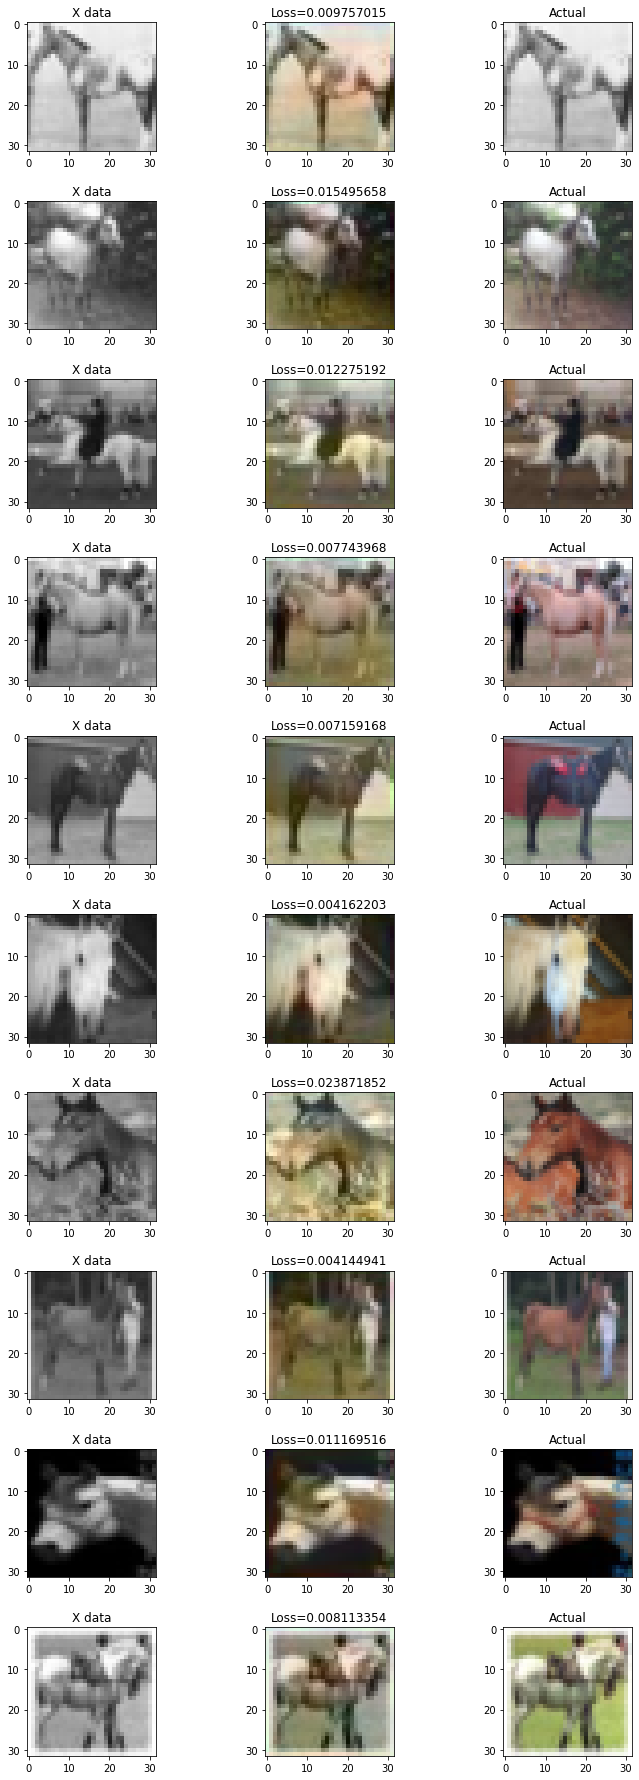

In [168]:
testModel(model12, x_test=data["X_test_horse"], y_test=data["y_test_horse"], criterion=nn.MSELoss())

In [68]:
learning_rate = 1e-2
model13 = ConvNet4()
optimizer = optim.SGD(model13.parameters(), lr=learning_rate)

In [135]:
train(model13, optimizer, epochs=1369, x_train=data["X_train_truck"],  y_train=data["y_train_truck"], criterion=nn.MSELoss())

--- Epoch 1 / 1369 - 1634 epochs total
Iteration 0, loss = 0.0019
Iteration 20, loss = 0.0016
Iteration 40, loss = 0.0017
Iteration 60, loss = 0.0040
Iteration 80, loss = 0.0030
--- Epoch 2 / 1369 - 1635 epochs total
Iteration 0, loss = 0.0028
Iteration 20, loss = 0.0029
Iteration 40, loss = 0.0008
Iteration 60, loss = 0.0044
Iteration 80, loss = 0.0036
--- Epoch 3 / 1369 - 1636 epochs total
Iteration 0, loss = 0.0025
Iteration 20, loss = 0.0043
Iteration 40, loss = 0.0025
Iteration 60, loss = 0.0061
Iteration 80, loss = 0.0037
--- Epoch 4 / 1369 - 1637 epochs total
Iteration 0, loss = 0.0042
Iteration 20, loss = 0.0030
Iteration 40, loss = 0.0071
Iteration 60, loss = 0.0023
Iteration 80, loss = 0.0020
--- Epoch 5 / 1369 - 1638 epochs total
Iteration 0, loss = 0.0016
Iteration 20, loss = 0.0044
Iteration 40, loss = 0.0016
Iteration 60, loss = 0.0073
Iteration 80, loss = 0.0046
--- Epoch 6 / 1369 - 1639 epochs total
Iteration 0, loss = 0.0086
Iteration 20, loss = 0.0017
Iteration 40, lo

Iteration 80, loss = 0.0059
--- Epoch 47 / 1369 - 1680 epochs total
Iteration 0, loss = 0.0047
Iteration 20, loss = 0.0022
Iteration 40, loss = 0.0059
Iteration 60, loss = 0.0005
Iteration 80, loss = 0.0042
--- Epoch 48 / 1369 - 1681 epochs total
Iteration 0, loss = 0.0082
Iteration 20, loss = 0.0052
Iteration 40, loss = 0.0091
Iteration 60, loss = 0.0032
Iteration 80, loss = 0.0072
--- Epoch 49 / 1369 - 1682 epochs total
Iteration 0, loss = 0.0060
Iteration 20, loss = 0.0021
Iteration 40, loss = 0.0020
Iteration 60, loss = 0.0096
Iteration 80, loss = 0.0041
--- Epoch 50 / 1369 - 1683 epochs total
Iteration 0, loss = 0.0072
Iteration 20, loss = 0.0073
Iteration 40, loss = 0.0023
Iteration 60, loss = 0.0023
Iteration 80, loss = 0.0010
--- Epoch 51 / 1369 - 1684 epochs total
Iteration 0, loss = 0.0026
Iteration 20, loss = 0.0046
Iteration 40, loss = 0.0069
Iteration 60, loss = 0.0035
Iteration 80, loss = 0.0118
--- Epoch 52 / 1369 - 1685 epochs total
Iteration 0, loss = 0.0048
Iteration 

Iteration 60, loss = 0.0015
Iteration 80, loss = 0.0029
--- Epoch 93 / 1369 - 1726 epochs total
Iteration 0, loss = 0.0034
Iteration 20, loss = 0.0033
Iteration 40, loss = 0.0054
Iteration 60, loss = 0.0029
Iteration 80, loss = 0.0010
--- Epoch 94 / 1369 - 1727 epochs total
Iteration 0, loss = 0.0023
Iteration 20, loss = 0.0009
Iteration 40, loss = 0.0047
Iteration 60, loss = 0.0145
Iteration 80, loss = 0.0021
--- Epoch 95 / 1369 - 1728 epochs total
Iteration 0, loss = 0.0013
Iteration 20, loss = 0.0117
Iteration 40, loss = 0.0210
Iteration 60, loss = 0.0022
Iteration 80, loss = 0.0029
--- Epoch 96 / 1369 - 1729 epochs total
Iteration 0, loss = 0.0055
Iteration 20, loss = 0.0009
Iteration 40, loss = 0.0039
Iteration 60, loss = 0.0053
Iteration 80, loss = 0.0093
--- Epoch 97 / 1369 - 1730 epochs total
Iteration 0, loss = 0.0088
Iteration 20, loss = 0.0051
Iteration 40, loss = 0.0074
Iteration 60, loss = 0.0149
Iteration 80, loss = 0.0015
--- Epoch 98 / 1369 - 1731 epochs total
Iteration

Iteration 20, loss = 0.0051
Iteration 40, loss = 0.0028
Iteration 60, loss = 0.0073
Iteration 80, loss = 0.0029
--- Epoch 139 / 1369 - 1772 epochs total
Iteration 0, loss = 0.0150
Iteration 20, loss = 0.0009
Iteration 40, loss = 0.0029
Iteration 60, loss = 0.0018
Iteration 80, loss = 0.0042
--- Epoch 140 / 1369 - 1773 epochs total
Iteration 0, loss = 0.0040
Iteration 20, loss = 0.0079
Iteration 40, loss = 0.0127
Iteration 60, loss = 0.0010
Iteration 80, loss = 0.0133
--- Epoch 141 / 1369 - 1774 epochs total
Iteration 0, loss = 0.0050
Iteration 20, loss = 0.0046
Iteration 40, loss = 0.0041
Iteration 60, loss = 0.0050
Iteration 80, loss = 0.0091
--- Epoch 142 / 1369 - 1775 epochs total
Iteration 0, loss = 0.0137
Iteration 20, loss = 0.0024
Iteration 40, loss = 0.0075
Iteration 60, loss = 0.0012
Iteration 80, loss = 0.0096
--- Epoch 143 / 1369 - 1776 epochs total
Iteration 0, loss = 0.0097
Iteration 20, loss = 0.0021
Iteration 40, loss = 0.0028
Iteration 60, loss = 0.0031
Iteration 80, lo

--- Epoch 184 / 1369 - 1817 epochs total
Iteration 0, loss = 0.0041
Iteration 20, loss = 0.0037
Iteration 40, loss = 0.0023
Iteration 60, loss = 0.0037
Iteration 80, loss = 0.0026
--- Epoch 185 / 1369 - 1818 epochs total
Iteration 0, loss = 0.0034
Iteration 20, loss = 0.0031
Iteration 40, loss = 0.0038
Iteration 60, loss = 0.0170
Iteration 80, loss = 0.0129
--- Epoch 186 / 1369 - 1819 epochs total
Iteration 0, loss = 0.0024
Iteration 20, loss = 0.0030
Iteration 40, loss = 0.0018
Iteration 60, loss = 0.0084
Iteration 80, loss = 0.0027
--- Epoch 187 / 1369 - 1820 epochs total
Iteration 0, loss = 0.0100
Iteration 20, loss = 0.0036
Iteration 40, loss = 0.0016
Iteration 60, loss = 0.0066
Iteration 80, loss = 0.0081
--- Epoch 188 / 1369 - 1821 epochs total
Iteration 0, loss = 0.0088
Iteration 20, loss = 0.0092
Iteration 40, loss = 0.0027
Iteration 60, loss = 0.0019
Iteration 80, loss = 0.0029
--- Epoch 189 / 1369 - 1822 epochs total
Iteration 0, loss = 0.0015
Iteration 20, loss = 0.0162
Iter

Iteration 40, loss = 0.0130
Iteration 60, loss = 0.0030
Iteration 80, loss = 0.0011
--- Epoch 230 / 1369 - 1863 epochs total
Iteration 0, loss = 0.0053
Iteration 20, loss = 0.0018
Iteration 40, loss = 0.0051
Iteration 60, loss = 0.0070
Iteration 80, loss = 0.0095
--- Epoch 231 / 1369 - 1864 epochs total
Iteration 0, loss = 0.0064
Iteration 20, loss = 0.0026
Iteration 40, loss = 0.0038
Iteration 60, loss = 0.0041
Iteration 80, loss = 0.0092
--- Epoch 232 / 1369 - 1865 epochs total
Iteration 0, loss = 0.0017
Iteration 20, loss = 0.0036
Iteration 40, loss = 0.0013
Iteration 60, loss = 0.0028
Iteration 80, loss = 0.0027
--- Epoch 233 / 1369 - 1866 epochs total
Iteration 0, loss = 0.0094
Iteration 20, loss = 0.0042
Iteration 40, loss = 0.0029
Iteration 60, loss = 0.0024
Iteration 80, loss = 0.0029
--- Epoch 234 / 1369 - 1867 epochs total
Iteration 0, loss = 0.0066
Iteration 20, loss = 0.0091
Iteration 40, loss = 0.0011
Iteration 60, loss = 0.0042
Iteration 80, loss = 0.0026
--- Epoch 235 / 

Iteration 20, loss = 0.0116
Iteration 40, loss = 0.0028
Iteration 60, loss = 0.0008
Iteration 80, loss = 0.0035
--- Epoch 276 / 1369 - 1909 epochs total
Iteration 0, loss = 0.0081
Iteration 20, loss = 0.0064
Iteration 40, loss = 0.0041
Iteration 60, loss = 0.0053
Iteration 80, loss = 0.0019
--- Epoch 277 / 1369 - 1910 epochs total
Iteration 0, loss = 0.0031
Iteration 20, loss = 0.0042
Iteration 40, loss = 0.0094
Iteration 60, loss = 0.0116
Iteration 80, loss = 0.0041
--- Epoch 278 / 1369 - 1911 epochs total
Iteration 0, loss = 0.0067
Iteration 20, loss = 0.0042
Iteration 40, loss = 0.0042
Iteration 60, loss = 0.0063
Iteration 80, loss = 0.0023
--- Epoch 279 / 1369 - 1912 epochs total
Iteration 0, loss = 0.0100
Iteration 20, loss = 0.0046
Iteration 40, loss = 0.0013
Iteration 60, loss = 0.0161
Iteration 80, loss = 0.0019
--- Epoch 280 / 1369 - 1913 epochs total
Iteration 0, loss = 0.0013
Iteration 20, loss = 0.0019
Iteration 40, loss = 0.0072
Iteration 60, loss = 0.0052
Iteration 80, lo

--- Epoch 321 / 1369 - 1954 epochs total
Iteration 0, loss = 0.0143
Iteration 20, loss = 0.0163
Iteration 40, loss = 0.0029
Iteration 60, loss = 0.0019
Iteration 80, loss = 0.0038
--- Epoch 322 / 1369 - 1955 epochs total
Iteration 0, loss = 0.0015
Iteration 20, loss = 0.0035
Iteration 40, loss = 0.0036
Iteration 60, loss = 0.0051
Iteration 80, loss = 0.0022
--- Epoch 323 / 1369 - 1956 epochs total
Iteration 0, loss = 0.0024
Iteration 20, loss = 0.0010
Iteration 40, loss = 0.0090
Iteration 60, loss = 0.0023
Iteration 80, loss = 0.0055
--- Epoch 324 / 1369 - 1957 epochs total
Iteration 0, loss = 0.0049
Iteration 20, loss = 0.0047
Iteration 40, loss = 0.0029
Iteration 60, loss = 0.0020
Iteration 80, loss = 0.0078
--- Epoch 325 / 1369 - 1958 epochs total
Iteration 0, loss = 0.0065
Iteration 20, loss = 0.0162
Iteration 40, loss = 0.0046
Iteration 60, loss = 0.0030
Iteration 80, loss = 0.0017
--- Epoch 326 / 1369 - 1959 epochs total
Iteration 0, loss = 0.0036
Iteration 20, loss = 0.0016
Iter

Iteration 40, loss = 0.0024
Iteration 60, loss = 0.0088
Iteration 80, loss = 0.0011
--- Epoch 367 / 1369 - 2000 epochs total
Iteration 0, loss = 0.0149
Iteration 20, loss = 0.0021
Iteration 40, loss = 0.0043
Iteration 60, loss = 0.0015
Iteration 80, loss = 0.0020
--- Epoch 368 / 1369 - 2001 epochs total
Iteration 0, loss = 0.0021
Iteration 20, loss = 0.0021
Iteration 40, loss = 0.0022
Iteration 60, loss = 0.0017
Iteration 80, loss = 0.0069
--- Epoch 369 / 1369 - 2002 epochs total
Iteration 0, loss = 0.0021
Iteration 20, loss = 0.0062
Iteration 40, loss = 0.0016
Iteration 60, loss = 0.0019
Iteration 80, loss = 0.0023
--- Epoch 370 / 1369 - 2003 epochs total
Iteration 0, loss = 0.0242
Iteration 20, loss = 0.0011
Iteration 40, loss = 0.0055
Iteration 60, loss = 0.0128
Iteration 80, loss = 0.0034
--- Epoch 371 / 1369 - 2004 epochs total
Iteration 0, loss = 0.0059
Iteration 20, loss = 0.0105
Iteration 40, loss = 0.0065
Iteration 60, loss = 0.0048
Iteration 80, loss = 0.0067
--- Epoch 372 / 

Iteration 20, loss = 0.0068
Iteration 40, loss = 0.0032
Iteration 60, loss = 0.0038
Iteration 80, loss = 0.0046
--- Epoch 413 / 1369 - 2046 epochs total
Iteration 0, loss = 0.0009
Iteration 20, loss = 0.0222
Iteration 40, loss = 0.0020
Iteration 60, loss = 0.0057
Iteration 80, loss = 0.0037
--- Epoch 414 / 1369 - 2047 epochs total
Iteration 0, loss = 0.0037
Iteration 20, loss = 0.0041
Iteration 40, loss = 0.0104
Iteration 60, loss = 0.0118
Iteration 80, loss = 0.0030
--- Epoch 415 / 1369 - 2048 epochs total
Iteration 0, loss = 0.0156
Iteration 20, loss = 0.0036
Iteration 40, loss = 0.0040
Iteration 60, loss = 0.0153
Iteration 80, loss = 0.0023
--- Epoch 416 / 1369 - 2049 epochs total
Iteration 0, loss = 0.0040
Iteration 20, loss = 0.0021
Iteration 40, loss = 0.0025
Iteration 60, loss = 0.0011
Iteration 80, loss = 0.0024
--- Epoch 417 / 1369 - 2050 epochs total
Iteration 0, loss = 0.0045
Iteration 20, loss = 0.0020
Iteration 40, loss = 0.0018
Iteration 60, loss = 0.0012
Iteration 80, lo

--- Epoch 458 / 1369 - 2091 epochs total
Iteration 0, loss = 0.0032
Iteration 20, loss = 0.0061
Iteration 40, loss = 0.0132
Iteration 60, loss = 0.0018
Iteration 80, loss = 0.0179
--- Epoch 459 / 1369 - 2092 epochs total
Iteration 0, loss = 0.0011
Iteration 20, loss = 0.0018
Iteration 40, loss = 0.0169
Iteration 60, loss = 0.0011
Iteration 80, loss = 0.0044
--- Epoch 460 / 1369 - 2093 epochs total
Iteration 0, loss = 0.0016
Iteration 20, loss = 0.0015
Iteration 40, loss = 0.0006
Iteration 60, loss = 0.0013
Iteration 80, loss = 0.0019
--- Epoch 461 / 1369 - 2094 epochs total
Iteration 0, loss = 0.0035
Iteration 20, loss = 0.0076
Iteration 40, loss = 0.0074
Iteration 60, loss = 0.0058
Iteration 80, loss = 0.0064
--- Epoch 462 / 1369 - 2095 epochs total
Iteration 0, loss = 0.0055
Iteration 20, loss = 0.0144
Iteration 40, loss = 0.0047
Iteration 60, loss = 0.0099
Iteration 80, loss = 0.0011
--- Epoch 463 / 1369 - 2096 epochs total
Iteration 0, loss = 0.0021
Iteration 20, loss = 0.0036
Iter

Iteration 40, loss = 0.0031
Iteration 60, loss = 0.0045
Iteration 80, loss = 0.0038
--- Epoch 504 / 1369 - 2137 epochs total
Iteration 0, loss = 0.0042
Iteration 20, loss = 0.0012
Iteration 40, loss = 0.0060
Iteration 60, loss = 0.0037
Iteration 80, loss = 0.0073
--- Epoch 505 / 1369 - 2138 epochs total
Iteration 0, loss = 0.0019
Iteration 20, loss = 0.0046
Iteration 40, loss = 0.0012
Iteration 60, loss = 0.0023
Iteration 80, loss = 0.0021
--- Epoch 506 / 1369 - 2139 epochs total
Iteration 0, loss = 0.0081
Iteration 20, loss = 0.0067
Iteration 40, loss = 0.0023
Iteration 60, loss = 0.0021
Iteration 80, loss = 0.0031
--- Epoch 507 / 1369 - 2140 epochs total
Iteration 0, loss = 0.0039
Iteration 20, loss = 0.0071
Iteration 40, loss = 0.0011
Iteration 60, loss = 0.0024
Iteration 80, loss = 0.0046
--- Epoch 508 / 1369 - 2141 epochs total
Iteration 0, loss = 0.0058
Iteration 20, loss = 0.0068
Iteration 40, loss = 0.0114
Iteration 60, loss = 0.0049
Iteration 80, loss = 0.0055
--- Epoch 509 / 

Iteration 20, loss = 0.0010
Iteration 40, loss = 0.0048
Iteration 60, loss = 0.0068
Iteration 80, loss = 0.0031
--- Epoch 550 / 1369 - 2183 epochs total
Iteration 0, loss = 0.0027
Iteration 20, loss = 0.0059
Iteration 40, loss = 0.0063
Iteration 60, loss = 0.0028
Iteration 80, loss = 0.0005
--- Epoch 551 / 1369 - 2184 epochs total
Iteration 0, loss = 0.0020
Iteration 20, loss = 0.0023
Iteration 40, loss = 0.0042
Iteration 60, loss = 0.0027
Iteration 80, loss = 0.0021
--- Epoch 552 / 1369 - 2185 epochs total
Iteration 0, loss = 0.0065
Iteration 20, loss = 0.0007
Iteration 40, loss = 0.0024
Iteration 60, loss = 0.0043
Iteration 80, loss = 0.0024
--- Epoch 553 / 1369 - 2186 epochs total
Iteration 0, loss = 0.0011
Iteration 20, loss = 0.0066
Iteration 40, loss = 0.0050
Iteration 60, loss = 0.0025
Iteration 80, loss = 0.0043
--- Epoch 554 / 1369 - 2187 epochs total
Iteration 0, loss = 0.0043
Iteration 20, loss = 0.0011
Iteration 40, loss = 0.0060
Iteration 60, loss = 0.0017
Iteration 80, lo

--- Epoch 595 / 1369 - 2228 epochs total
Iteration 0, loss = 0.0104
Iteration 20, loss = 0.0024
Iteration 40, loss = 0.0040
Iteration 60, loss = 0.0058
Iteration 80, loss = 0.0132
--- Epoch 596 / 1369 - 2229 epochs total
Iteration 0, loss = 0.0094
Iteration 20, loss = 0.0181
Iteration 40, loss = 0.0014
Iteration 60, loss = 0.0113
Iteration 80, loss = 0.0085
--- Epoch 597 / 1369 - 2230 epochs total
Iteration 0, loss = 0.0057
Iteration 20, loss = 0.0108
Iteration 40, loss = 0.0061
Iteration 60, loss = 0.0024
Iteration 80, loss = 0.0091
--- Epoch 598 / 1369 - 2231 epochs total
Iteration 0, loss = 0.0029
Iteration 20, loss = 0.0088
Iteration 40, loss = 0.0059
Iteration 60, loss = 0.0029
Iteration 80, loss = 0.0015
--- Epoch 599 / 1369 - 2232 epochs total
Iteration 0, loss = 0.0023
Iteration 20, loss = 0.0074
Iteration 40, loss = 0.0033
Iteration 60, loss = 0.0017
Iteration 80, loss = 0.0127
--- Epoch 600 / 1369 - 2233 epochs total
Iteration 0, loss = 0.0043
Iteration 20, loss = 0.0065
Iter

Iteration 40, loss = 0.0131
Iteration 60, loss = 0.0014
Iteration 80, loss = 0.0062
--- Epoch 641 / 1369 - 2274 epochs total
Iteration 0, loss = 0.0049
Iteration 20, loss = 0.0015
Iteration 40, loss = 0.0032
Iteration 60, loss = 0.0067
Iteration 80, loss = 0.0094
--- Epoch 642 / 1369 - 2275 epochs total
Iteration 0, loss = 0.0030
Iteration 20, loss = 0.0047
Iteration 40, loss = 0.0036
Iteration 60, loss = 0.0020
Iteration 80, loss = 0.0032
--- Epoch 643 / 1369 - 2276 epochs total
Iteration 0, loss = 0.0079
Iteration 20, loss = 0.0027
Iteration 40, loss = 0.0020
Iteration 60, loss = 0.0076
Iteration 80, loss = 0.0017
--- Epoch 644 / 1369 - 2277 epochs total
Iteration 0, loss = 0.0029
Iteration 20, loss = 0.0013
Iteration 40, loss = 0.0136
Iteration 60, loss = 0.0014
Iteration 80, loss = 0.0081
--- Epoch 645 / 1369 - 2278 epochs total
Iteration 0, loss = 0.0035
Iteration 20, loss = 0.0077
Iteration 40, loss = 0.0031
Iteration 60, loss = 0.0016
Iteration 80, loss = 0.0018
--- Epoch 646 / 

Iteration 20, loss = 0.0055
Iteration 40, loss = 0.0076
Iteration 60, loss = 0.0028
Iteration 80, loss = 0.0060
--- Epoch 687 / 1369 - 2320 epochs total
Iteration 0, loss = 0.0080
Iteration 20, loss = 0.0088
Iteration 40, loss = 0.0032
Iteration 60, loss = 0.0107
Iteration 80, loss = 0.0124
--- Epoch 688 / 1369 - 2321 epochs total
Iteration 0, loss = 0.0242
Iteration 20, loss = 0.0034
Iteration 40, loss = 0.0034
Iteration 60, loss = 0.0091
Iteration 80, loss = 0.0016
--- Epoch 689 / 1369 - 2322 epochs total
Iteration 0, loss = 0.0067
Iteration 20, loss = 0.0014
Iteration 40, loss = 0.0030
Iteration 60, loss = 0.0049
Iteration 80, loss = 0.0054
--- Epoch 690 / 1369 - 2323 epochs total
Iteration 0, loss = 0.0026
Iteration 20, loss = 0.0284
Iteration 40, loss = 0.0034
Iteration 60, loss = 0.0089
Iteration 80, loss = 0.0187
--- Epoch 691 / 1369 - 2324 epochs total
Iteration 0, loss = 0.0059
Iteration 20, loss = 0.0026
Iteration 40, loss = 0.0022
Iteration 60, loss = 0.0062
Iteration 80, lo

--- Epoch 732 / 1369 - 2365 epochs total
Iteration 0, loss = 0.0064
Iteration 20, loss = 0.0072
Iteration 40, loss = 0.0080
Iteration 60, loss = 0.0014
Iteration 80, loss = 0.0022
--- Epoch 733 / 1369 - 2366 epochs total
Iteration 0, loss = 0.0118
Iteration 20, loss = 0.0041
Iteration 40, loss = 0.0118
Iteration 60, loss = 0.0096
Iteration 80, loss = 0.0137
--- Epoch 734 / 1369 - 2367 epochs total
Iteration 0, loss = 0.0065
Iteration 20, loss = 0.0034
Iteration 40, loss = 0.0031
Iteration 60, loss = 0.0059
Iteration 80, loss = 0.0045
--- Epoch 735 / 1369 - 2368 epochs total
Iteration 0, loss = 0.0043
Iteration 20, loss = 0.0020
Iteration 40, loss = 0.0051
Iteration 60, loss = 0.0077
Iteration 80, loss = 0.0023
--- Epoch 736 / 1369 - 2369 epochs total
Iteration 0, loss = 0.0020
Iteration 20, loss = 0.0016
Iteration 40, loss = 0.0074
Iteration 60, loss = 0.0017
Iteration 80, loss = 0.0020
--- Epoch 737 / 1369 - 2370 epochs total
Iteration 0, loss = 0.0098
Iteration 20, loss = 0.0039
Iter

Iteration 40, loss = 0.0053
Iteration 60, loss = 0.0034
Iteration 80, loss = 0.0026
--- Epoch 778 / 1369 - 2411 epochs total
Iteration 0, loss = 0.0078
Iteration 20, loss = 0.0018
Iteration 40, loss = 0.0030
Iteration 60, loss = 0.0064
Iteration 80, loss = 0.0085
--- Epoch 779 / 1369 - 2412 epochs total
Iteration 0, loss = 0.0044
Iteration 20, loss = 0.0210
Iteration 40, loss = 0.0011
Iteration 60, loss = 0.0068
Iteration 80, loss = 0.0031
--- Epoch 780 / 1369 - 2413 epochs total
Iteration 0, loss = 0.0019
Iteration 20, loss = 0.0011
Iteration 40, loss = 0.0108
Iteration 60, loss = 0.0031
Iteration 80, loss = 0.0024
--- Epoch 781 / 1369 - 2414 epochs total
Iteration 0, loss = 0.0058
Iteration 20, loss = 0.0127
Iteration 40, loss = 0.0036
Iteration 60, loss = 0.0041
Iteration 80, loss = 0.0027
--- Epoch 782 / 1369 - 2415 epochs total
Iteration 0, loss = 0.0149
Iteration 20, loss = 0.0024
Iteration 40, loss = 0.0027
Iteration 60, loss = 0.0086
Iteration 80, loss = 0.0024
--- Epoch 783 / 

Iteration 20, loss = 0.0012
Iteration 40, loss = 0.0050
Iteration 60, loss = 0.0110
Iteration 80, loss = 0.0181
--- Epoch 824 / 1369 - 2457 epochs total
Iteration 0, loss = 0.0011
Iteration 20, loss = 0.0018
Iteration 40, loss = 0.0042
Iteration 60, loss = 0.0037
Iteration 80, loss = 0.0067
--- Epoch 825 / 1369 - 2458 epochs total
Iteration 0, loss = 0.0045
Iteration 20, loss = 0.0173
Iteration 40, loss = 0.0016
Iteration 60, loss = 0.0020
Iteration 80, loss = 0.0074
--- Epoch 826 / 1369 - 2459 epochs total
Iteration 0, loss = 0.0055
Iteration 20, loss = 0.0024
Iteration 40, loss = 0.0058
Iteration 60, loss = 0.0171
Iteration 80, loss = 0.0058
--- Epoch 827 / 1369 - 2460 epochs total
Iteration 0, loss = 0.0033
Iteration 20, loss = 0.0187
Iteration 40, loss = 0.0030
Iteration 60, loss = 0.0005
Iteration 80, loss = 0.0190
--- Epoch 828 / 1369 - 2461 epochs total
Iteration 0, loss = 0.0105
Iteration 20, loss = 0.0031
Iteration 40, loss = 0.0032
Iteration 60, loss = 0.0030
Iteration 80, lo

--- Epoch 869 / 1369 - 2502 epochs total
Iteration 0, loss = 0.0069
Iteration 20, loss = 0.0051
Iteration 40, loss = 0.0067
Iteration 60, loss = 0.0019
Iteration 80, loss = 0.0020
--- Epoch 870 / 1369 - 2503 epochs total
Iteration 0, loss = 0.0044
Iteration 20, loss = 0.0067
Iteration 40, loss = 0.0058
Iteration 60, loss = 0.0016
Iteration 80, loss = 0.0020
--- Epoch 871 / 1369 - 2504 epochs total
Iteration 0, loss = 0.0027
Iteration 20, loss = 0.0039
Iteration 40, loss = 0.0014
Iteration 60, loss = 0.0056
Iteration 80, loss = 0.0122
--- Epoch 872 / 1369 - 2505 epochs total
Iteration 0, loss = 0.0028
Iteration 20, loss = 0.0035
Iteration 40, loss = 0.0035
Iteration 60, loss = 0.0029
Iteration 80, loss = 0.0035
--- Epoch 873 / 1369 - 2506 epochs total
Iteration 0, loss = 0.0049
Iteration 20, loss = 0.0007
Iteration 40, loss = 0.0045
Iteration 60, loss = 0.0014
Iteration 80, loss = 0.0012
--- Epoch 874 / 1369 - 2507 epochs total
Iteration 0, loss = 0.0147
Iteration 20, loss = 0.0019
Iter

Iteration 40, loss = 0.0021
Iteration 60, loss = 0.0077
Iteration 80, loss = 0.0058
--- Epoch 915 / 1369 - 2548 epochs total
Iteration 0, loss = 0.0139
Iteration 20, loss = 0.0016
Iteration 40, loss = 0.0029
Iteration 60, loss = 0.0009
Iteration 80, loss = 0.0044
--- Epoch 916 / 1369 - 2549 epochs total
Iteration 0, loss = 0.0055
Iteration 20, loss = 0.0025
Iteration 40, loss = 0.0075
Iteration 60, loss = 0.0062
Iteration 80, loss = 0.0025
--- Epoch 917 / 1369 - 2550 epochs total
Iteration 0, loss = 0.0028
Iteration 20, loss = 0.0089
Iteration 40, loss = 0.0100
Iteration 60, loss = 0.0039
Iteration 80, loss = 0.0119
--- Epoch 918 / 1369 - 2551 epochs total
Iteration 0, loss = 0.0015
Iteration 20, loss = 0.0015
Iteration 40, loss = 0.0021
Iteration 60, loss = 0.0015
Iteration 80, loss = 0.0043
--- Epoch 919 / 1369 - 2552 epochs total
Iteration 0, loss = 0.0047
Iteration 20, loss = 0.0064
Iteration 40, loss = 0.0032
Iteration 60, loss = 0.0048
Iteration 80, loss = 0.0073
--- Epoch 920 / 

Iteration 20, loss = 0.0026
Iteration 40, loss = 0.0033
Iteration 60, loss = 0.0050
Iteration 80, loss = 0.0062
--- Epoch 961 / 1369 - 2594 epochs total
Iteration 0, loss = 0.0057
Iteration 20, loss = 0.0021
Iteration 40, loss = 0.0045
Iteration 60, loss = 0.0004
Iteration 80, loss = 0.0038
--- Epoch 962 / 1369 - 2595 epochs total
Iteration 0, loss = 0.0068
Iteration 20, loss = 0.0100
Iteration 40, loss = 0.0040
Iteration 60, loss = 0.0046
Iteration 80, loss = 0.0075
--- Epoch 963 / 1369 - 2596 epochs total
Iteration 0, loss = 0.0053
Iteration 20, loss = 0.0064
Iteration 40, loss = 0.0039
Iteration 60, loss = 0.0049
Iteration 80, loss = 0.0041
--- Epoch 964 / 1369 - 2597 epochs total
Iteration 0, loss = 0.0018
Iteration 20, loss = 0.0034
Iteration 40, loss = 0.0077
Iteration 60, loss = 0.0029
Iteration 80, loss = 0.0061
--- Epoch 965 / 1369 - 2598 epochs total
Iteration 0, loss = 0.0022
Iteration 20, loss = 0.0020
Iteration 40, loss = 0.0026
Iteration 60, loss = 0.0021
Iteration 80, lo

--- Epoch 1006 / 1369 - 2639 epochs total
Iteration 0, loss = 0.0034
Iteration 20, loss = 0.0015
Iteration 40, loss = 0.0186
Iteration 60, loss = 0.0079
Iteration 80, loss = 0.0020
--- Epoch 1007 / 1369 - 2640 epochs total
Iteration 0, loss = 0.0036
Iteration 20, loss = 0.0013
Iteration 40, loss = 0.0061
Iteration 60, loss = 0.0038
Iteration 80, loss = 0.0099
--- Epoch 1008 / 1369 - 2641 epochs total
Iteration 0, loss = 0.0035
Iteration 20, loss = 0.0037
Iteration 40, loss = 0.0039
Iteration 60, loss = 0.0280
Iteration 80, loss = 0.0097
--- Epoch 1009 / 1369 - 2642 epochs total
Iteration 0, loss = 0.0113
Iteration 20, loss = 0.0032
Iteration 40, loss = 0.0059
Iteration 60, loss = 0.0038
Iteration 80, loss = 0.0082
--- Epoch 1010 / 1369 - 2643 epochs total
Iteration 0, loss = 0.0043
Iteration 20, loss = 0.0040
Iteration 40, loss = 0.0311
Iteration 60, loss = 0.0034
Iteration 80, loss = 0.0029
--- Epoch 1011 / 1369 - 2644 epochs total
Iteration 0, loss = 0.0068
Iteration 20, loss = 0.001

Iteration 20, loss = 0.0065
Iteration 40, loss = 0.0089
Iteration 60, loss = 0.0172
Iteration 80, loss = 0.0015
--- Epoch 1052 / 1369 - 2685 epochs total
Iteration 0, loss = 0.0041
Iteration 20, loss = 0.0109
Iteration 40, loss = 0.0011
Iteration 60, loss = 0.0025
Iteration 80, loss = 0.0021
--- Epoch 1053 / 1369 - 2686 epochs total
Iteration 0, loss = 0.0058
Iteration 20, loss = 0.0013
Iteration 40, loss = 0.0212
Iteration 60, loss = 0.0127
Iteration 80, loss = 0.0021
--- Epoch 1054 / 1369 - 2687 epochs total
Iteration 0, loss = 0.0070
Iteration 20, loss = 0.0017
Iteration 40, loss = 0.0094
Iteration 60, loss = 0.0028
Iteration 80, loss = 0.0029
--- Epoch 1055 / 1369 - 2688 epochs total
Iteration 0, loss = 0.0037
Iteration 20, loss = 0.0034
Iteration 40, loss = 0.0025
Iteration 60, loss = 0.0053
Iteration 80, loss = 0.0017
--- Epoch 1056 / 1369 - 2689 epochs total
Iteration 0, loss = 0.0035
Iteration 20, loss = 0.0072
Iteration 40, loss = 0.0038
Iteration 60, loss = 0.0027
Iteration 8

Iteration 60, loss = 0.0069
Iteration 80, loss = 0.0033
--- Epoch 1097 / 1369 - 2730 epochs total
Iteration 0, loss = 0.0118
Iteration 20, loss = 0.0029
Iteration 40, loss = 0.0031
Iteration 60, loss = 0.0045
Iteration 80, loss = 0.0053
--- Epoch 1098 / 1369 - 2731 epochs total
Iteration 0, loss = 0.0068
Iteration 20, loss = 0.0024
Iteration 40, loss = 0.0015
Iteration 60, loss = 0.0021
Iteration 80, loss = 0.0022
--- Epoch 1099 / 1369 - 2732 epochs total
Iteration 0, loss = 0.0019
Iteration 20, loss = 0.0017
Iteration 40, loss = 0.0030
Iteration 60, loss = 0.0068
Iteration 80, loss = 0.0116
--- Epoch 1100 / 1369 - 2733 epochs total
Iteration 0, loss = 0.0040
Iteration 20, loss = 0.0031
Iteration 40, loss = 0.0175
Iteration 60, loss = 0.0019
Iteration 80, loss = 0.0028
--- Epoch 1101 / 1369 - 2734 epochs total
Iteration 0, loss = 0.0017
Iteration 20, loss = 0.0066
Iteration 40, loss = 0.0043
Iteration 60, loss = 0.0012
Iteration 80, loss = 0.0025
--- Epoch 1102 / 1369 - 2735 epochs tot

--- Epoch 1142 / 1369 - 2775 epochs total
Iteration 0, loss = 0.0040
Iteration 20, loss = 0.0045
Iteration 40, loss = 0.0007
Iteration 60, loss = 0.0024
Iteration 80, loss = 0.0049
--- Epoch 1143 / 1369 - 2776 epochs total
Iteration 0, loss = 0.0026
Iteration 20, loss = 0.0032
Iteration 40, loss = 0.0030
Iteration 60, loss = 0.0040
Iteration 80, loss = 0.0006
--- Epoch 1144 / 1369 - 2777 epochs total
Iteration 0, loss = 0.0112
Iteration 20, loss = 0.0027
Iteration 40, loss = 0.0009
Iteration 60, loss = 0.0031
Iteration 80, loss = 0.0113
--- Epoch 1145 / 1369 - 2778 epochs total
Iteration 0, loss = 0.0012
Iteration 20, loss = 0.0012
Iteration 40, loss = 0.0081
Iteration 60, loss = 0.0032
Iteration 80, loss = 0.0071
--- Epoch 1146 / 1369 - 2779 epochs total
Iteration 0, loss = 0.0019
Iteration 20, loss = 0.0073
Iteration 40, loss = 0.0037
Iteration 60, loss = 0.0007
Iteration 80, loss = 0.0050
--- Epoch 1147 / 1369 - 2780 epochs total
Iteration 0, loss = 0.0071
Iteration 20, loss = 0.003

Iteration 20, loss = 0.0089
Iteration 40, loss = 0.0026
Iteration 60, loss = 0.0034
Iteration 80, loss = 0.0039
--- Epoch 1188 / 1369 - 2821 epochs total
Iteration 0, loss = 0.0031
Iteration 20, loss = 0.0058
Iteration 40, loss = 0.0047
Iteration 60, loss = 0.0051
Iteration 80, loss = 0.0099
--- Epoch 1189 / 1369 - 2822 epochs total
Iteration 0, loss = 0.0026
Iteration 20, loss = 0.0025
Iteration 40, loss = 0.0164
Iteration 60, loss = 0.0028
Iteration 80, loss = 0.0032
--- Epoch 1190 / 1369 - 2823 epochs total
Iteration 0, loss = 0.0024
Iteration 20, loss = 0.0031
Iteration 40, loss = 0.0075
Iteration 60, loss = 0.0076
Iteration 80, loss = 0.0015
--- Epoch 1191 / 1369 - 2824 epochs total
Iteration 0, loss = 0.0032
Iteration 20, loss = 0.0044
Iteration 40, loss = 0.0013
Iteration 60, loss = 0.0069
Iteration 80, loss = 0.0085
--- Epoch 1192 / 1369 - 2825 epochs total
Iteration 0, loss = 0.0137
Iteration 20, loss = 0.0053
Iteration 40, loss = 0.0018
Iteration 60, loss = 0.0099
Iteration 8

Iteration 60, loss = 0.0020
Iteration 80, loss = 0.0055
--- Epoch 1233 / 1369 - 2866 epochs total
Iteration 0, loss = 0.0071
Iteration 20, loss = 0.0029
Iteration 40, loss = 0.0020
Iteration 60, loss = 0.0064
Iteration 80, loss = 0.0025
--- Epoch 1234 / 1369 - 2867 epochs total
Iteration 0, loss = 0.0011
Iteration 20, loss = 0.0058
Iteration 40, loss = 0.0100
Iteration 60, loss = 0.0007
Iteration 80, loss = 0.0041
--- Epoch 1235 / 1369 - 2868 epochs total
Iteration 0, loss = 0.0049
Iteration 20, loss = 0.0044
Iteration 40, loss = 0.0025
Iteration 60, loss = 0.0063
Iteration 80, loss = 0.0023
--- Epoch 1236 / 1369 - 2869 epochs total
Iteration 0, loss = 0.0156
Iteration 20, loss = 0.0050
Iteration 40, loss = 0.0014
Iteration 60, loss = 0.0062
Iteration 80, loss = 0.0016
--- Epoch 1237 / 1369 - 2870 epochs total
Iteration 0, loss = 0.0130
Iteration 20, loss = 0.0118
Iteration 40, loss = 0.0030
Iteration 60, loss = 0.0048
Iteration 80, loss = 0.0063
--- Epoch 1238 / 1369 - 2871 epochs tot

--- Epoch 1278 / 1369 - 2911 epochs total
Iteration 0, loss = 0.0039
Iteration 20, loss = 0.0092
Iteration 40, loss = 0.0030
Iteration 60, loss = 0.0019
Iteration 80, loss = 0.0041
--- Epoch 1279 / 1369 - 2912 epochs total
Iteration 0, loss = 0.0009
Iteration 20, loss = 0.0068
Iteration 40, loss = 0.0051
Iteration 60, loss = 0.0049
Iteration 80, loss = 0.0138
--- Epoch 1280 / 1369 - 2913 epochs total
Iteration 0, loss = 0.0041
Iteration 20, loss = 0.0027
Iteration 40, loss = 0.0014
Iteration 60, loss = 0.0037
Iteration 80, loss = 0.0022
--- Epoch 1281 / 1369 - 2914 epochs total
Iteration 0, loss = 0.0054
Iteration 20, loss = 0.0032
Iteration 40, loss = 0.0019
Iteration 60, loss = 0.0028
Iteration 80, loss = 0.0015
--- Epoch 1282 / 1369 - 2915 epochs total
Iteration 0, loss = 0.0019
Iteration 20, loss = 0.0129
Iteration 40, loss = 0.0019
Iteration 60, loss = 0.0086
Iteration 80, loss = 0.0050
--- Epoch 1283 / 1369 - 2916 epochs total
Iteration 0, loss = 0.0030
Iteration 20, loss = 0.001

Iteration 20, loss = 0.0032
Iteration 40, loss = 0.0064
Iteration 60, loss = 0.0010
Iteration 80, loss = 0.0069
--- Epoch 1324 / 1369 - 2957 epochs total
Iteration 0, loss = 0.0049
Iteration 20, loss = 0.0053
Iteration 40, loss = 0.0070
Iteration 60, loss = 0.0119
Iteration 80, loss = 0.0070
--- Epoch 1325 / 1369 - 2958 epochs total
Iteration 0, loss = 0.0034
Iteration 20, loss = 0.0021
Iteration 40, loss = 0.0011
Iteration 60, loss = 0.0022
Iteration 80, loss = 0.0183
--- Epoch 1326 / 1369 - 2959 epochs total
Iteration 0, loss = 0.0007
Iteration 20, loss = 0.0009
Iteration 40, loss = 0.0026
Iteration 60, loss = 0.0035
Iteration 80, loss = 0.0064
--- Epoch 1327 / 1369 - 2960 epochs total
Iteration 0, loss = 0.0145
Iteration 20, loss = 0.0015
Iteration 40, loss = 0.0033
Iteration 60, loss = 0.0094
Iteration 80, loss = 0.0034
--- Epoch 1328 / 1369 - 2961 epochs total
Iteration 0, loss = 0.0021
Iteration 20, loss = 0.0017
Iteration 40, loss = 0.0039
Iteration 60, loss = 0.0035
Iteration 8

Iteration 60, loss = 0.0190
Iteration 80, loss = 0.0012
--- Epoch 1369 / 1369 - 3002 epochs total
Iteration 0, loss = 0.0027
Iteration 20, loss = 0.0089
Iteration 40, loss = 0.0058
Iteration 60, loss = 0.0013
Iteration 80, loss = 0.0021


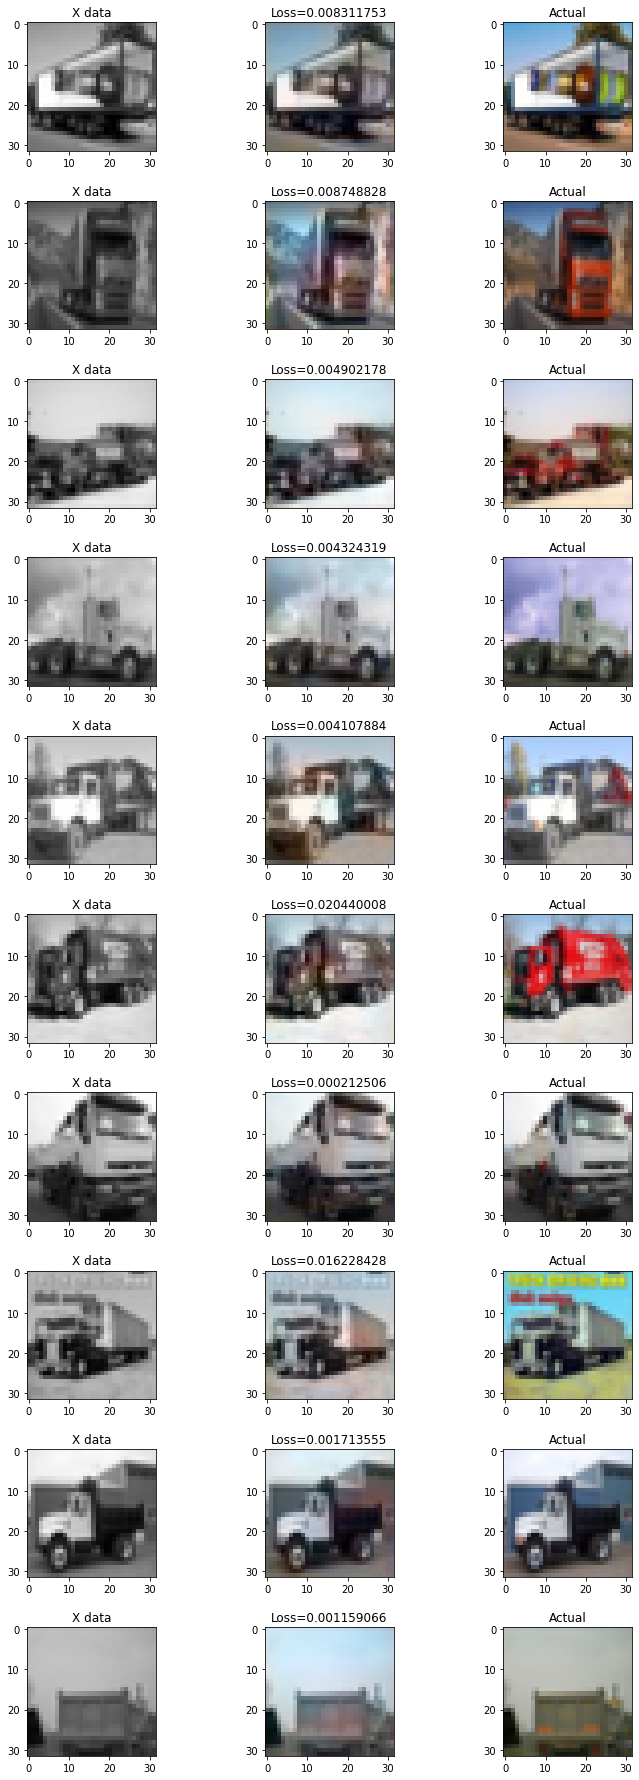

In [137]:
testModel(model13, x_test=data["X_test_truck"], y_test=data["y_test_truck"], criterion=nn.MSELoss())

In [138]:
learning_rate = 1e-2
model14 = ConvNet4()
optimizer = optim.SGD(model14.parameters(), lr=learning_rate)

In [161]:
train(model14, optimizer, epochs=100000, x_train=data["X_train"],  y_train=data["y_train"], criterion=nn.MSELoss())

--- Epoch 1 / 100000 - 2449 epochs total
Iteration 0, loss = 0.0090
Iteration 20, loss = 0.0238
Iteration 40, loss = 0.0048
Iteration 60, loss = 0.0129
Iteration 80, loss = 0.0043
--- Epoch 2 / 100000 - 2450 epochs total
Iteration 0, loss = 0.0062
Iteration 20, loss = 0.0110
Iteration 40, loss = 0.0187
Iteration 60, loss = 0.0036
Iteration 80, loss = 0.0032
--- Epoch 3 / 100000 - 2451 epochs total
Iteration 0, loss = 0.0042
Iteration 20, loss = 0.0462
Iteration 40, loss = 0.0058
Iteration 60, loss = 0.0107
Iteration 80, loss = 0.0043
--- Epoch 4 / 100000 - 2452 epochs total
Iteration 0, loss = 0.0074
Iteration 20, loss = 0.0072
Iteration 40, loss = 0.0059
Iteration 60, loss = 0.0076
Iteration 80, loss = 0.0051
--- Epoch 5 / 100000 - 2453 epochs total
Iteration 0, loss = 0.0064
Iteration 20, loss = 0.0047
Iteration 40, loss = 0.0130
Iteration 60, loss = 0.0011
Iteration 80, loss = 0.0027
--- Epoch 6 / 100000 - 2454 epochs total
Iteration 0, loss = 0.0042
Iteration 20, loss = 0.0022
Iter

Iteration 20, loss = 0.0032
Iteration 40, loss = 0.0035
Iteration 60, loss = 0.0073
Iteration 80, loss = 0.0048
--- Epoch 47 / 100000 - 2495 epochs total
Iteration 0, loss = 0.0053
Iteration 20, loss = 0.0045
Iteration 40, loss = 0.0103
Iteration 60, loss = 0.0291
Iteration 80, loss = 0.0039
--- Epoch 48 / 100000 - 2496 epochs total
Iteration 0, loss = 0.0088
Iteration 20, loss = 0.0020
Iteration 40, loss = 0.0220
Iteration 60, loss = 0.0108
Iteration 80, loss = 0.0243
--- Epoch 49 / 100000 - 2497 epochs total
Iteration 0, loss = 0.0029
Iteration 20, loss = 0.0150
Iteration 40, loss = 0.0111
Iteration 60, loss = 0.0418
Iteration 80, loss = 0.0075
--- Epoch 50 / 100000 - 2498 epochs total
Iteration 0, loss = 0.0012
Iteration 20, loss = 0.0141
Iteration 40, loss = 0.0040
Iteration 60, loss = 0.0062
Iteration 80, loss = 0.0037
--- Epoch 51 / 100000 - 2499 epochs total
Iteration 0, loss = 0.0046
Iteration 20, loss = 0.0141
Iteration 40, loss = 0.0067
Iteration 60, loss = 0.0061
Iteration 8

Iteration 60, loss = 0.0118
Iteration 80, loss = 0.0039
--- Epoch 92 / 100000 - 2540 epochs total
Iteration 0, loss = 0.0085
Iteration 20, loss = 0.0135
Iteration 40, loss = 0.0118
Iteration 60, loss = 0.0042
Iteration 80, loss = 0.0051
--- Epoch 93 / 100000 - 2541 epochs total
Iteration 0, loss = 0.0062
Iteration 20, loss = 0.0058
Iteration 40, loss = 0.0018
Iteration 60, loss = 0.0028
Iteration 80, loss = 0.0108
--- Epoch 94 / 100000 - 2542 epochs total
Iteration 0, loss = 0.0291
Iteration 20, loss = 0.0064
Iteration 40, loss = 0.0058
Iteration 60, loss = 0.0080
Iteration 80, loss = 0.0165
--- Epoch 95 / 100000 - 2543 epochs total
Iteration 0, loss = 0.0014
Iteration 20, loss = 0.0022
Iteration 40, loss = 0.0238
Iteration 60, loss = 0.0109
Iteration 80, loss = 0.0091
--- Epoch 96 / 100000 - 2544 epochs total
Iteration 0, loss = 0.0094
Iteration 20, loss = 0.0046
Iteration 40, loss = 0.0052
Iteration 60, loss = 0.0271
Iteration 80, loss = 0.0170
--- Epoch 97 / 100000 - 2545 epochs tot

Iteration 80, loss = 0.0045
--- Epoch 137 / 100000 - 2585 epochs total
Iteration 0, loss = 0.0039
Iteration 20, loss = 0.0018
Iteration 40, loss = 0.0038
Iteration 60, loss = 0.0029
Iteration 80, loss = 0.0191
--- Epoch 138 / 100000 - 2586 epochs total
Iteration 0, loss = 0.0043
Iteration 20, loss = 0.0098
Iteration 40, loss = 0.0025
Iteration 60, loss = 0.0042
Iteration 80, loss = 0.0126
--- Epoch 139 / 100000 - 2587 epochs total
Iteration 0, loss = 0.0240
Iteration 20, loss = 0.0053
Iteration 40, loss = 0.0126
Iteration 60, loss = 0.0080
Iteration 80, loss = 0.0046
--- Epoch 140 / 100000 - 2588 epochs total
Iteration 0, loss = 0.0033
Iteration 20, loss = 0.0051
Iteration 40, loss = 0.0091
Iteration 60, loss = 0.0036
Iteration 80, loss = 0.0111
--- Epoch 141 / 100000 - 2589 epochs total
Iteration 0, loss = 0.0088
Iteration 20, loss = 0.0035
Iteration 40, loss = 0.0599
Iteration 60, loss = 0.0014
Iteration 80, loss = 0.0042
--- Epoch 142 / 100000 - 2590 epochs total
Iteration 0, loss =

--- Epoch 182 / 100000 - 2630 epochs total
Iteration 0, loss = 0.0122
Iteration 20, loss = 0.0044
Iteration 40, loss = 0.0033
Iteration 60, loss = 0.0017
Iteration 80, loss = 0.0038
--- Epoch 183 / 100000 - 2631 epochs total
Iteration 0, loss = 0.0040
Iteration 20, loss = 0.0049
Iteration 40, loss = 0.0036
Iteration 60, loss = 0.0196
Iteration 80, loss = 0.0019
--- Epoch 184 / 100000 - 2632 epochs total
Iteration 0, loss = 0.0034
Iteration 20, loss = 0.0125
Iteration 40, loss = 0.0034
Iteration 60, loss = 0.0063
Iteration 80, loss = 0.0043
--- Epoch 185 / 100000 - 2633 epochs total
Iteration 0, loss = 0.0057
Iteration 20, loss = 0.0072
Iteration 40, loss = 0.0052
Iteration 60, loss = 0.0020
Iteration 80, loss = 0.0123
--- Epoch 186 / 100000 - 2634 epochs total
Iteration 0, loss = 0.0289
Iteration 20, loss = 0.0132
Iteration 40, loss = 0.0030
Iteration 60, loss = 0.0059
Iteration 80, loss = 0.0052
--- Epoch 187 / 100000 - 2635 epochs total
Iteration 0, loss = 0.0025
Iteration 20, loss =

Iteration 20, loss = 0.0317
Iteration 40, loss = 0.0046
Iteration 60, loss = 0.0254
Iteration 80, loss = 0.0030
--- Epoch 228 / 100000 - 2676 epochs total
Iteration 0, loss = 0.0028
Iteration 20, loss = 0.0054
Iteration 40, loss = 0.0099
Iteration 60, loss = 0.0118
Iteration 80, loss = 0.0119
--- Epoch 229 / 100000 - 2677 epochs total
Iteration 0, loss = 0.0358
Iteration 20, loss = 0.0037
Iteration 40, loss = 0.0057
Iteration 60, loss = 0.0249
Iteration 80, loss = 0.0260
--- Epoch 230 / 100000 - 2678 epochs total
Iteration 0, loss = 0.0333
Iteration 20, loss = 0.0120
Iteration 40, loss = 0.0145
Iteration 60, loss = 0.0066
Iteration 80, loss = 0.0051
--- Epoch 231 / 100000 - 2679 epochs total
Iteration 0, loss = 0.0091
Iteration 20, loss = 0.0153
Iteration 40, loss = 0.0158
Iteration 60, loss = 0.0090
Iteration 80, loss = 0.0017
--- Epoch 232 / 100000 - 2680 epochs total
Iteration 0, loss = 0.0517
Iteration 20, loss = 0.0103
Iteration 40, loss = 0.0180
Iteration 60, loss = 0.0068
Iterat

Iteration 40, loss = 0.0334
Iteration 60, loss = 0.0075
Iteration 80, loss = 0.0114
--- Epoch 273 / 100000 - 2721 epochs total
Iteration 0, loss = 0.0390
Iteration 20, loss = 0.0054
Iteration 40, loss = 0.0025
Iteration 60, loss = 0.0115
Iteration 80, loss = 0.0174
--- Epoch 274 / 100000 - 2722 epochs total
Iteration 0, loss = 0.0074
Iteration 20, loss = 0.0055
Iteration 40, loss = 0.0056
Iteration 60, loss = 0.0015
Iteration 80, loss = 0.0012
--- Epoch 275 / 100000 - 2723 epochs total
Iteration 0, loss = 0.0190
Iteration 20, loss = 0.0119
Iteration 40, loss = 0.0031
Iteration 60, loss = 0.0055
Iteration 80, loss = 0.0306
--- Epoch 276 / 100000 - 2724 epochs total
Iteration 0, loss = 0.0054
Iteration 20, loss = 0.0083
Iteration 40, loss = 0.0065
Iteration 60, loss = 0.0022
Iteration 80, loss = 0.0038
--- Epoch 277 / 100000 - 2725 epochs total
Iteration 0, loss = 0.0020
Iteration 20, loss = 0.0147
Iteration 40, loss = 0.0140
Iteration 60, loss = 0.0013
Iteration 80, loss = 0.0133
--- Ep

Iteration 60, loss = 0.0045
Iteration 80, loss = 0.0023
--- Epoch 318 / 100000 - 2766 epochs total
Iteration 0, loss = 0.0027
Iteration 20, loss = 0.0065
Iteration 40, loss = 0.0166
Iteration 60, loss = 0.0204
Iteration 80, loss = 0.0100
--- Epoch 319 / 100000 - 2767 epochs total
Iteration 0, loss = 0.0028
Iteration 20, loss = 0.0115
Iteration 40, loss = 0.0167
Iteration 60, loss = 0.0047
Iteration 80, loss = 0.0012
--- Epoch 320 / 100000 - 2768 epochs total
Iteration 0, loss = 0.0061
Iteration 20, loss = 0.0064
Iteration 40, loss = 0.0033
Iteration 60, loss = 0.0118
Iteration 80, loss = 0.0119
--- Epoch 321 / 100000 - 2769 epochs total
Iteration 0, loss = 0.0037
Iteration 20, loss = 0.0131
Iteration 40, loss = 0.0074
Iteration 60, loss = 0.0050
Iteration 80, loss = 0.0040
--- Epoch 322 / 100000 - 2770 epochs total
Iteration 0, loss = 0.0012
Iteration 20, loss = 0.0105
Iteration 40, loss = 0.0024
Iteration 60, loss = 0.0164
Iteration 80, loss = 0.0131
--- Epoch 323 / 100000 - 2771 epoc

Iteration 80, loss = 0.0010
--- Epoch 363 / 100000 - 2811 epochs total
Iteration 0, loss = 0.0099
Iteration 20, loss = 0.0081
Iteration 40, loss = 0.0047
Iteration 60, loss = 0.0135
Iteration 80, loss = 0.0036
--- Epoch 364 / 100000 - 2812 epochs total
Iteration 0, loss = 0.0280
Iteration 20, loss = 0.0048
Iteration 40, loss = 0.0068
Iteration 60, loss = 0.0109
Iteration 80, loss = 0.0158
--- Epoch 365 / 100000 - 2813 epochs total
Iteration 0, loss = 0.0064
Iteration 20, loss = 0.0018
Iteration 40, loss = 0.0144
Iteration 60, loss = 0.0022
Iteration 80, loss = 0.0027
--- Epoch 366 / 100000 - 2814 epochs total
Iteration 0, loss = 0.0039
Iteration 20, loss = 0.0078
Iteration 40, loss = 0.0322
Iteration 60, loss = 0.0016
Iteration 80, loss = 0.0015
--- Epoch 367 / 100000 - 2815 epochs total
Iteration 0, loss = 0.0107
Iteration 20, loss = 0.0282
Iteration 40, loss = 0.0015
Iteration 60, loss = 0.0016
Iteration 80, loss = 0.0063
--- Epoch 368 / 100000 - 2816 epochs total
Iteration 0, loss =

--- Epoch 408 / 100000 - 2856 epochs total
Iteration 0, loss = 0.0552
Iteration 20, loss = 0.0034
Iteration 40, loss = 0.0170
Iteration 60, loss = 0.0146
Iteration 80, loss = 0.0073
--- Epoch 409 / 100000 - 2857 epochs total
Iteration 0, loss = 0.0151
Iteration 20, loss = 0.0229
Iteration 40, loss = 0.0074
Iteration 60, loss = 0.0101
Iteration 80, loss = 0.0061
--- Epoch 410 / 100000 - 2858 epochs total
Iteration 0, loss = 0.0048
Iteration 20, loss = 0.0046
Iteration 40, loss = 0.0062
Iteration 60, loss = 0.0191
Iteration 80, loss = 0.0040
--- Epoch 411 / 100000 - 2859 epochs total
Iteration 0, loss = 0.0122
Iteration 20, loss = 0.0152
Iteration 40, loss = 0.0098
Iteration 60, loss = 0.0033
Iteration 80, loss = 0.0053
--- Epoch 412 / 100000 - 2860 epochs total
Iteration 0, loss = 0.0014
Iteration 20, loss = 0.0012
Iteration 40, loss = 0.0070
Iteration 60, loss = 0.0085
Iteration 80, loss = 0.0135
--- Epoch 413 / 100000 - 2861 epochs total
Iteration 0, loss = 0.0125
Iteration 20, loss =

Iteration 20, loss = 0.0150
Iteration 40, loss = 0.0053
Iteration 60, loss = 0.0030
Iteration 80, loss = 0.0137
--- Epoch 454 / 100000 - 2902 epochs total
Iteration 0, loss = 0.0085
Iteration 20, loss = 0.0069
Iteration 40, loss = 0.0373
Iteration 60, loss = 0.0023
Iteration 80, loss = 0.0082
--- Epoch 455 / 100000 - 2903 epochs total
Iteration 0, loss = 0.0144
Iteration 20, loss = 0.0086
Iteration 40, loss = 0.0018
Iteration 60, loss = 0.0066
Iteration 80, loss = 0.0259
--- Epoch 456 / 100000 - 2904 epochs total
Iteration 0, loss = 0.0034
Iteration 20, loss = 0.0172
Iteration 40, loss = 0.0045
Iteration 60, loss = 0.0219
Iteration 80, loss = 0.0040
--- Epoch 457 / 100000 - 2905 epochs total
Iteration 0, loss = 0.0087
Iteration 20, loss = 0.0046
Iteration 40, loss = 0.0048
Iteration 60, loss = 0.0092
Iteration 80, loss = 0.0095
--- Epoch 458 / 100000 - 2906 epochs total
Iteration 0, loss = 0.0457
Iteration 20, loss = 0.0027
Iteration 40, loss = 0.0088
Iteration 60, loss = 0.0089
Iterat

Iteration 40, loss = 0.0069
Iteration 60, loss = 0.0073
Iteration 80, loss = 0.0026
--- Epoch 499 / 100000 - 2947 epochs total
Iteration 0, loss = 0.0135
Iteration 20, loss = 0.0032
Iteration 40, loss = 0.0274
Iteration 60, loss = 0.0100
Iteration 80, loss = 0.0215
--- Epoch 500 / 100000 - 2948 epochs total
Iteration 0, loss = 0.0102
Iteration 20, loss = 0.0229
Iteration 40, loss = 0.0035
Iteration 60, loss = 0.0347
Iteration 80, loss = 0.0085
--- Epoch 501 / 100000 - 2949 epochs total
Iteration 0, loss = 0.0072
Iteration 20, loss = 0.0118
Iteration 40, loss = 0.0045
Iteration 60, loss = 0.0084
Iteration 80, loss = 0.0051
--- Epoch 502 / 100000 - 2950 epochs total
Iteration 0, loss = 0.0068
Iteration 20, loss = 0.0063
Iteration 40, loss = 0.0043
Iteration 60, loss = 0.0054
Iteration 80, loss = 0.0038
--- Epoch 503 / 100000 - 2951 epochs total
Iteration 0, loss = 0.0135
Iteration 20, loss = 0.0031
Iteration 40, loss = 0.0073
Iteration 60, loss = 0.0059
Iteration 80, loss = 0.0012
--- Ep

Iteration 60, loss = 0.0035
Iteration 80, loss = 0.0024
--- Epoch 544 / 100000 - 2992 epochs total
Iteration 0, loss = 0.0401
Iteration 20, loss = 0.0229
Iteration 40, loss = 0.0464
Iteration 60, loss = 0.0088
Iteration 80, loss = 0.0024
--- Epoch 545 / 100000 - 2993 epochs total
Iteration 0, loss = 0.0025
Iteration 20, loss = 0.0105
Iteration 40, loss = 0.0396
Iteration 60, loss = 0.0048
Iteration 80, loss = 0.0084
--- Epoch 546 / 100000 - 2994 epochs total
Iteration 0, loss = 0.0072
Iteration 20, loss = 0.0119
Iteration 40, loss = 0.0022
Iteration 60, loss = 0.0340
Iteration 80, loss = 0.0076
--- Epoch 547 / 100000 - 2995 epochs total
Iteration 0, loss = 0.0021
Iteration 20, loss = 0.0146
Iteration 40, loss = 0.0070
Iteration 60, loss = 0.0039
Iteration 80, loss = 0.0065
--- Epoch 548 / 100000 - 2996 epochs total
Iteration 0, loss = 0.0012
Iteration 20, loss = 0.0180
Iteration 40, loss = 0.0250
Iteration 60, loss = 0.0058
Iteration 80, loss = 0.0014
--- Epoch 549 / 100000 - 2997 epoc

Iteration 80, loss = 0.0020
--- Epoch 589 / 100000 - 3037 epochs total
Iteration 0, loss = 0.0040
Iteration 20, loss = 0.0152
Iteration 40, loss = 0.0037
Iteration 60, loss = 0.0040
Iteration 80, loss = 0.0021
--- Epoch 590 / 100000 - 3038 epochs total
Iteration 0, loss = 0.0147
Iteration 20, loss = 0.0046
Iteration 40, loss = 0.0108
Iteration 60, loss = 0.0208
Iteration 80, loss = 0.0101
--- Epoch 591 / 100000 - 3039 epochs total
Iteration 0, loss = 0.0665
Iteration 20, loss = 0.0105
Iteration 40, loss = 0.0150
Iteration 60, loss = 0.0046
Iteration 80, loss = 0.0120
--- Epoch 592 / 100000 - 3040 epochs total
Iteration 0, loss = 0.0193
Iteration 20, loss = 0.0083
Iteration 40, loss = 0.0035
Iteration 60, loss = 0.0021
Iteration 80, loss = 0.0111
--- Epoch 593 / 100000 - 3041 epochs total
Iteration 0, loss = 0.0292
Iteration 20, loss = 0.0414
Iteration 40, loss = 0.0063
Iteration 60, loss = 0.0021
Iteration 80, loss = 0.0182
--- Epoch 594 / 100000 - 3042 epochs total
Iteration 0, loss =

--- Epoch 634 / 100000 - 3082 epochs total
Iteration 0, loss = 0.0019
Iteration 20, loss = 0.0202
Iteration 40, loss = 0.0023
Iteration 60, loss = 0.0054
Iteration 80, loss = 0.0023
--- Epoch 635 / 100000 - 3083 epochs total
Iteration 0, loss = 0.0043
Iteration 20, loss = 0.0034
Iteration 40, loss = 0.0023
Iteration 60, loss = 0.0317
Iteration 80, loss = 0.0035
--- Epoch 636 / 100000 - 3084 epochs total
Iteration 0, loss = 0.0030
Iteration 20, loss = 0.0156
Iteration 40, loss = 0.0107
Iteration 60, loss = 0.0072
Iteration 80, loss = 0.0023
--- Epoch 637 / 100000 - 3085 epochs total
Iteration 0, loss = 0.0138
Iteration 20, loss = 0.0068
Iteration 40, loss = 0.0290
Iteration 60, loss = 0.0105
Iteration 80, loss = 0.0044
--- Epoch 638 / 100000 - 3086 epochs total
Iteration 0, loss = 0.0026
Iteration 20, loss = 0.0077
Iteration 40, loss = 0.0080
Iteration 60, loss = 0.0071
Iteration 80, loss = 0.0082
--- Epoch 639 / 100000 - 3087 epochs total
Iteration 0, loss = 0.0301
Iteration 20, loss =

Iteration 20, loss = 0.0040
Iteration 40, loss = 0.0061
Iteration 60, loss = 0.0160
Iteration 80, loss = 0.0053
--- Epoch 680 / 100000 - 3128 epochs total
Iteration 0, loss = 0.0010
Iteration 20, loss = 0.0044
Iteration 40, loss = 0.0263
Iteration 60, loss = 0.0016
Iteration 80, loss = 0.0039
--- Epoch 681 / 100000 - 3129 epochs total
Iteration 0, loss = 0.0038
Iteration 20, loss = 0.0028
Iteration 40, loss = 0.0036
Iteration 60, loss = 0.0180
Iteration 80, loss = 0.0043
--- Epoch 682 / 100000 - 3130 epochs total
Iteration 0, loss = 0.0322
Iteration 20, loss = 0.0291
Iteration 40, loss = 0.0098
Iteration 60, loss = 0.0127
Iteration 80, loss = 0.0058
--- Epoch 683 / 100000 - 3131 epochs total
Iteration 0, loss = 0.0233
Iteration 20, loss = 0.0053
Iteration 40, loss = 0.0113
Iteration 60, loss = 0.0340
Iteration 80, loss = 0.0078
--- Epoch 684 / 100000 - 3132 epochs total
Iteration 0, loss = 0.0030
Iteration 20, loss = 0.0048
Iteration 40, loss = 0.0126
Iteration 60, loss = 0.0069
Iterat

Iteration 40, loss = 0.0063
Iteration 60, loss = 0.0081
Iteration 80, loss = 0.0090
--- Epoch 725 / 100000 - 3173 epochs total
Iteration 0, loss = 0.0132
Iteration 20, loss = 0.0204
Iteration 40, loss = 0.0012
Iteration 60, loss = 0.0016
Iteration 80, loss = 0.0114
--- Epoch 726 / 100000 - 3174 epochs total
Iteration 0, loss = 0.0030
Iteration 20, loss = 0.0104
Iteration 40, loss = 0.0052
Iteration 60, loss = 0.0072
Iteration 80, loss = 0.0087
--- Epoch 727 / 100000 - 3175 epochs total
Iteration 0, loss = 0.0186
Iteration 20, loss = 0.0040
Iteration 40, loss = 0.0204
Iteration 60, loss = 0.0106
Iteration 80, loss = 0.0078
--- Epoch 728 / 100000 - 3176 epochs total
Iteration 0, loss = 0.0214
Iteration 20, loss = 0.0050
Iteration 40, loss = 0.0077
Iteration 60, loss = 0.0082
Iteration 80, loss = 0.0090
--- Epoch 729 / 100000 - 3177 epochs total
Iteration 0, loss = 0.0086
Iteration 20, loss = 0.0106
Iteration 40, loss = 0.0185
Iteration 60, loss = 0.0062
Iteration 80, loss = 0.0192
--- Ep

Iteration 60, loss = 0.0028
Iteration 80, loss = 0.0073
--- Epoch 770 / 100000 - 3218 epochs total
Iteration 0, loss = 0.0019
Iteration 20, loss = 0.0068
Iteration 40, loss = 0.0058
Iteration 60, loss = 0.0041
Iteration 80, loss = 0.0261
--- Epoch 771 / 100000 - 3219 epochs total
Iteration 0, loss = 0.0088
Iteration 20, loss = 0.0057
Iteration 40, loss = 0.0153
Iteration 60, loss = 0.0050
Iteration 80, loss = 0.0069
--- Epoch 772 / 100000 - 3220 epochs total
Iteration 0, loss = 0.0155
Iteration 20, loss = 0.0342
Iteration 40, loss = 0.0019
Iteration 60, loss = 0.0077
Iteration 80, loss = 0.0064
--- Epoch 773 / 100000 - 3221 epochs total
Iteration 0, loss = 0.0107
Iteration 20, loss = 0.0028
Iteration 40, loss = 0.0057
Iteration 60, loss = 0.0028
Iteration 80, loss = 0.0103
--- Epoch 774 / 100000 - 3222 epochs total
Iteration 0, loss = 0.0072
Iteration 20, loss = 0.0095
Iteration 40, loss = 0.0160
Iteration 60, loss = 0.0030
Iteration 80, loss = 0.0022
--- Epoch 775 / 100000 - 3223 epoc

Iteration 80, loss = 0.0200
--- Epoch 815 / 100000 - 3263 epochs total
Iteration 0, loss = 0.0016
Iteration 20, loss = 0.0045
Iteration 40, loss = 0.0047
Iteration 60, loss = 0.0106
Iteration 80, loss = 0.0047
--- Epoch 816 / 100000 - 3264 epochs total
Iteration 0, loss = 0.0049
Iteration 20, loss = 0.0048
Iteration 40, loss = 0.0195
Iteration 60, loss = 0.0109
Iteration 80, loss = 0.0100
--- Epoch 817 / 100000 - 3265 epochs total
Iteration 0, loss = 0.0014
Iteration 20, loss = 0.0019
Iteration 40, loss = 0.0017
Iteration 60, loss = 0.0040
Iteration 80, loss = 0.0044
--- Epoch 818 / 100000 - 3266 epochs total
Iteration 0, loss = 0.0094
Iteration 20, loss = 0.0034
Iteration 40, loss = 0.0038
Iteration 60, loss = 0.0066
Iteration 80, loss = 0.0106
--- Epoch 819 / 100000 - 3267 epochs total
Iteration 0, loss = 0.0023
Iteration 20, loss = 0.0012
Iteration 40, loss = 0.0019
Iteration 60, loss = 0.0096
Iteration 80, loss = 0.0017
--- Epoch 820 / 100000 - 3268 epochs total
Iteration 0, loss =

--- Epoch 860 / 100000 - 3308 epochs total
Iteration 0, loss = 0.0054
Iteration 20, loss = 0.0033
Iteration 40, loss = 0.0266
Iteration 60, loss = 0.0390
Iteration 80, loss = 0.0225
--- Epoch 861 / 100000 - 3309 epochs total
Iteration 0, loss = 0.0098
Iteration 20, loss = 0.0022
Iteration 40, loss = 0.0100
Iteration 60, loss = 0.0038
Iteration 80, loss = 0.0112
--- Epoch 862 / 100000 - 3310 epochs total
Iteration 0, loss = 0.0061
Iteration 20, loss = 0.0076
Iteration 40, loss = 0.0125
Iteration 60, loss = 0.0107
Iteration 80, loss = 0.0064
--- Epoch 863 / 100000 - 3311 epochs total
Iteration 0, loss = 0.0044
Iteration 20, loss = 0.0286
Iteration 40, loss = 0.0132
Iteration 60, loss = 0.0241
Iteration 80, loss = 0.0191
--- Epoch 864 / 100000 - 3312 epochs total
Iteration 0, loss = 0.0068
Iteration 20, loss = 0.0096
Iteration 40, loss = 0.0073
Iteration 60, loss = 0.0069
Iteration 80, loss = 0.0156
--- Epoch 865 / 100000 - 3313 epochs total
Iteration 0, loss = 0.0125
Iteration 20, loss =

Iteration 20, loss = 0.0268
Iteration 40, loss = 0.0025
Iteration 60, loss = 0.0081
Iteration 80, loss = 0.0133
--- Epoch 906 / 100000 - 3354 epochs total
Iteration 0, loss = 0.0030
Iteration 20, loss = 0.0066
Iteration 40, loss = 0.0106
Iteration 60, loss = 0.0133
Iteration 80, loss = 0.0032
--- Epoch 907 / 100000 - 3355 epochs total
Iteration 0, loss = 0.0045
Iteration 20, loss = 0.0042
Iteration 40, loss = 0.0060
Iteration 60, loss = 0.0068
Iteration 80, loss = 0.0024
--- Epoch 908 / 100000 - 3356 epochs total
Iteration 0, loss = 0.0050
Iteration 20, loss = 0.0061
Iteration 40, loss = 0.0722
Iteration 60, loss = 0.0011
Iteration 80, loss = 0.0017
--- Epoch 909 / 100000 - 3357 epochs total
Iteration 0, loss = 0.0586
Iteration 20, loss = 0.0081
Iteration 40, loss = 0.0110
Iteration 60, loss = 0.0045
Iteration 80, loss = 0.0189
--- Epoch 910 / 100000 - 3358 epochs total
Iteration 0, loss = 0.0128
Iteration 20, loss = 0.0128
Iteration 40, loss = 0.0024
Iteration 60, loss = 0.0053
Iterat

Iteration 40, loss = 0.0111
Iteration 60, loss = 0.0024
Iteration 80, loss = 0.0014
--- Epoch 951 / 100000 - 3399 epochs total
Iteration 0, loss = 0.0139
Iteration 20, loss = 0.0022
Iteration 40, loss = 0.0014
Iteration 60, loss = 0.0124
Iteration 80, loss = 0.0121
--- Epoch 952 / 100000 - 3400 epochs total
Iteration 0, loss = 0.0016
Iteration 20, loss = 0.0041
Iteration 40, loss = 0.0228
Iteration 60, loss = 0.0214
Iteration 80, loss = 0.0119
--- Epoch 953 / 100000 - 3401 epochs total
Iteration 0, loss = 0.0043
Iteration 20, loss = 0.0041
Iteration 40, loss = 0.0050
Iteration 60, loss = 0.0049
Iteration 80, loss = 0.0022
--- Epoch 954 / 100000 - 3402 epochs total
Iteration 0, loss = 0.0016
Iteration 20, loss = 0.0031
Iteration 40, loss = 0.0020
Iteration 60, loss = 0.0063
Iteration 80, loss = 0.0151
--- Epoch 955 / 100000 - 3403 epochs total
Iteration 0, loss = 0.0188
Iteration 20, loss = 0.0105
Iteration 40, loss = 0.0068
Iteration 60, loss = 0.0060
Iteration 80, loss = 0.0147
--- Ep

Iteration 60, loss = 0.0162
Iteration 80, loss = 0.0034
--- Epoch 996 / 100000 - 3444 epochs total
Iteration 0, loss = 0.0065
Iteration 20, loss = 0.0189
Iteration 40, loss = 0.0069
Iteration 60, loss = 0.0046
Iteration 80, loss = 0.0068
--- Epoch 997 / 100000 - 3445 epochs total
Iteration 0, loss = 0.0124
Iteration 20, loss = 0.0010
Iteration 40, loss = 0.0055
Iteration 60, loss = 0.0034
Iteration 80, loss = 0.0063
--- Epoch 998 / 100000 - 3446 epochs total
Iteration 0, loss = 0.0416
Iteration 20, loss = 0.0546
Iteration 40, loss = 0.0054
Iteration 60, loss = 0.0077
Iteration 80, loss = 0.0558
--- Epoch 999 / 100000 - 3447 epochs total
Iteration 0, loss = 0.0012
Iteration 20, loss = 0.0353
Iteration 40, loss = 0.0040
Iteration 60, loss = 0.0052
Iteration 80, loss = 0.0123
--- Epoch 1000 / 100000 - 3448 epochs total
Iteration 0, loss = 0.0066
Iteration 20, loss = 0.0052
Iteration 40, loss = 0.0056
Iteration 60, loss = 0.0141
Iteration 80, loss = 0.0046
--- Epoch 1001 / 100000 - 3449 ep

Iteration 40, loss = 0.0117
Iteration 60, loss = 0.0040
Iteration 80, loss = 0.0066
--- Epoch 1041 / 100000 - 3489 epochs total
Iteration 0, loss = 0.0025
Iteration 20, loss = 0.0023
Iteration 40, loss = 0.0037
Iteration 60, loss = 0.0092
Iteration 80, loss = 0.0087
--- Epoch 1042 / 100000 - 3490 epochs total
Iteration 0, loss = 0.0078
Iteration 20, loss = 0.0051
Iteration 40, loss = 0.0446
Iteration 60, loss = 0.0052
Iteration 80, loss = 0.0070
--- Epoch 1043 / 100000 - 3491 epochs total
Iteration 0, loss = 0.0389
Iteration 20, loss = 0.0149
Iteration 40, loss = 0.0057
Iteration 60, loss = 0.0240
Iteration 80, loss = 0.0079
--- Epoch 1044 / 100000 - 3492 epochs total
Iteration 0, loss = 0.0087
Iteration 20, loss = 0.0083
Iteration 40, loss = 0.0048
Iteration 60, loss = 0.0046
Iteration 80, loss = 0.0066
--- Epoch 1045 / 100000 - 3493 epochs total
Iteration 0, loss = 0.0155
Iteration 20, loss = 0.0083
Iteration 40, loss = 0.0073
Iteration 60, loss = 0.0022
Iteration 80, loss = 0.0115
-

KeyboardInterrupt: 

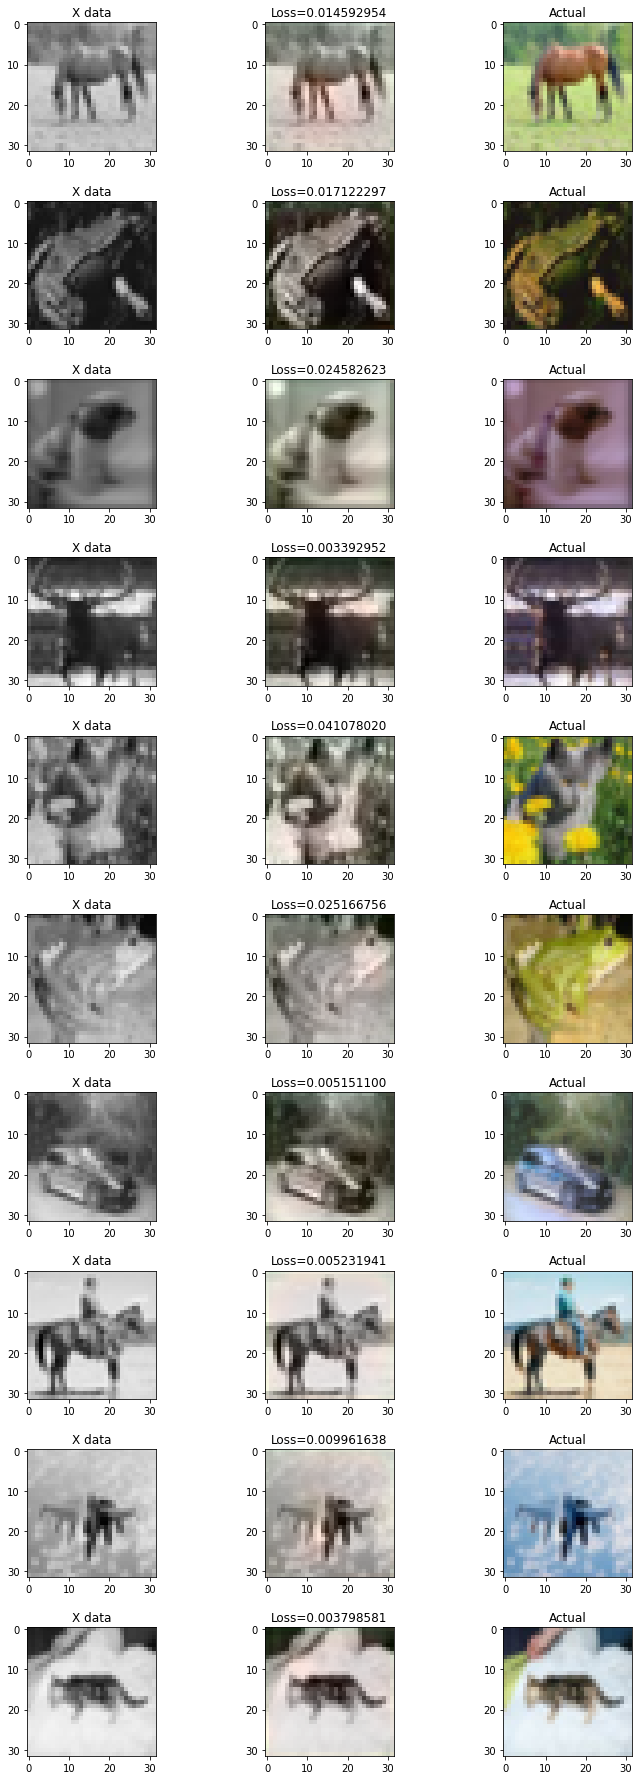

In [167]:
testModel(model14, x_test=data["X_test"], y_test=data["y_test"], criterion=nn.MSELoss())